In [15]:
set.seed(42)

In [16]:
train_set = read.delim("data/train_set.txt", sep = " ")
test_set = read.delim("data/test_set.txt", sep = " ")

In [17]:
head(train_set)

,ff,t,td,hu,dd,precip_log,ws_arome,p3031_arome,u10_arome,v10_arome,⋯,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,-0.08621305,1.164777,0.9105351,-0.79823471,0.5200537,-0.82039852,-0.03659526,0.5297853,0.8019527,0.4007581,⋯,0,0,0,1,0,0,0,0,0,0
2,-0.21529566,-1.471529,-1.6613332,-0.45471837,0.6958876,0.07889537,-0.25766440,1.3231433,0.5568977,-0.8887086,⋯,1,0,0,0,0,0,0,0,0,0
4,-1.46867996,0.129100,-0.1875101,-1.05685344,0.1290120,-0.82039852,-1.31752316,-0.8278199,-0.6050438,-0.6937063,⋯,0,0,1,0,0,0,0,0,0,0
5,1.02840090,-1.238485,-1.4212403,-0.49103295,1.0222052,0.26943290,0.46462317,1.0634977,1.1864348,-0.7170438,⋯,0,0,0,0,0,0,0,0,0,0
6,-1.46553799,-1.273800,-1.2888096,0.07576901,-0.8504800,-0.61244731,-1.27793928,-0.5881897,-0.4321987,0.1073955,⋯,0,0,0,0,0,0,0,0,0,1
8,2.36216728,-1.243795,-1.3614883,-0.33792281,-2.0645970,-0.82039852,1.53127621,-2.0125623,-2.3869380,-1.7343155,⋯,1,0,0,0,0,0,0,0,0,0


We define here all the explicative variables

In [18]:
exp_var = setdiff(names(train_set), c("rain", "rain_log", "rain_class"))

### 0.1. Performance Evaluation methods and Metrics

We define as below some utility functions for comparing the performance of different methods

#### Function to calculate error using MAPE

Error is calculated using 
$$MAPE = \frac{100}{n} \sum_{i =1}^{n} \frac{|Y_i - \hat{Y_i}|}{|Y_i|}$$

Which is more robust then the $l2-norm$ for dealing with outliers

In [19]:
library(MLmetrics)

In [151]:
# MAPE = function(y, y_hat, eps = 1e-10){
#     # y = as.numeric(y)
#     # y_hat = as.numeric(y_hat)
#     mape = 100*mean(abs((y - y_hat))/(max(abs(y), eps)))
#     return(mape)
# }

#### Funtion to calculate quadratic error

In [21]:
# MSE = function(y, y_hat){
#     mse = mean((y - y_hat)**2)
#     return(mse)
# }

#### Function to transform predicted rain values in log scale to original sclale 

In [22]:
to_rain = function(rain_log){
    return(exp(rain_log) - 1)
}

#### Function to transform rain values to rain class

Here in this regression setting, the outputs are numerical values. We will use these values to transform to the rain class for the classification problem. Since in the classification problem, we set the output to be `no_rain` if the `rain == 0`, and etc,... but in the regression setting, we allow here some perturbations `eps`.

In [23]:
to_class = function(rain, eps = 1e-2 ){
    myrain = (rain <= eps)*0 + (rain > eps)*(rain <= 2 )*1 + (rain > 2)*2
    myrain[myrain == 0] = 'no_rain'
    myrain[myrain == 1] = 'low_rain'
    myrain[myrain == 2] = 'high_rain'
    return(myrain)
}

#### Function to create the confusion matrix for the classification context

In [24]:
confusion_matrix = function(pred_class, true_class){
    tab = table(pred_class, true_class)
    print("Confusion matrix")
    print(tab)
    acc = sum(diag(tab)) / sum(tab)
    print(paste("Prediction accuracy : ", acc))
}

## 1. Linear Regression

In [25]:
library(glmnet)
library(Rcpp)
library(ellipse)
library(leaps)
library(MASS)

library(plotly)
library(ggplot2)     
library(gridExtra)   
library(ggfortify)   
library(ggcorrplot) 

library(dplyr)

In [26]:
head(train_set)

,ff,t,td,hu,dd,precip_log,ws_arome,p3031_arome,u10_arome,v10_arome,⋯,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,-0.08621305,1.164777,0.9105351,-0.79823471,0.5200537,-0.82039852,-0.03659526,0.5297853,0.8019527,0.4007581,⋯,0,0,0,1,0,0,0,0,0,0
2,-0.21529566,-1.471529,-1.6613332,-0.45471837,0.6958876,0.07889537,-0.25766440,1.3231433,0.5568977,-0.8887086,⋯,1,0,0,0,0,0,0,0,0,0
4,-1.46867996,0.129100,-0.1875101,-1.05685344,0.1290120,-0.82039852,-1.31752316,-0.8278199,-0.6050438,-0.6937063,⋯,0,0,1,0,0,0,0,0,0,0
5,1.02840090,-1.238485,-1.4212403,-0.49103295,1.0222052,0.26943290,0.46462317,1.0634977,1.1864348,-0.7170438,⋯,0,0,0,0,0,0,0,0,0,0
6,-1.46553799,-1.273800,-1.2888096,0.07576901,-0.8504800,-0.61244731,-1.27793928,-0.5881897,-0.4321987,0.1073955,⋯,0,0,0,0,0,0,0,0,0,1
8,2.36216728,-1.243795,-1.3614883,-0.33792281,-2.0645970,-0.82039852,1.53127621,-2.0125623,-2.3869380,-1.7343155,⋯,1,0,0,0,0,0,0,0,0,0


In [27]:
y_train = train_set[,"rain"]
y_train_log = train_set[, "rain_log"]
y_train_class = train_set[, "rain_class"]

y_test = test_set[,"rain"]
y_test_log = test_set[, "rain_log"]
y_test_class = test_set[, "rain_class"]

### 1.1. Linear regression without variable selection, applying to the `rain_log` reponse

In [154]:
lin.reg.log = lm(rain_log ~ ., data = train_set[,c(exp_var, "rain_log")])
summary(lin.reg.log)


Call:
lm(formula = rain_log ~ ., data = train_set[, c(exp_var, "rain_log")])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2655 -0.4517 -0.1343  0.3067  2.3558 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.96546    0.14215   6.792 3.01e-11 ***
ff            0.16300    0.13133   1.241 0.215085    
t            -2.85956    1.22615  -2.332 0.020072 *  
td            2.01236    1.16894   1.722 0.085747 .  
hu           -0.76002    0.42961  -1.769 0.077459 .  
dd           -0.05309    0.11331  -0.469 0.639601    
precip_log    0.16740    0.05873   2.850 0.004540 ** 
ws_arome     -0.31402    0.14732  -2.132 0.033507 *  
p3031_arome   0.01991    0.11823   0.168 0.866313    
u10_arome     0.23410    0.06648   3.521 0.000467 ***
v10_arome     0.20739    0.04309   4.813 1.95e-06 ***
t2m_arome     2.74332    1.19641   2.293 0.022247 *  
d2m_arome    -1.90265    1.09403  -1.739 0.082601 .  
r_arome       0.62745    0.38823   1.616 0.106655    
tp_

#### Training error
As a regular setting, the solution of this regression problem is a minimiser of a least square problem, so we will look at the $l_2$ error during training but also the MAPE to see the corresponding error.

In [155]:
print('TRAINING ERROR IN LOG SCALE')
print(paste('Mean Square Error : ', mean(lin.reg.log$residual**2)))
print(paste('MAPE : ', MAPE(lin.reg.log$fitted.values, y_train_log)))

pred_class = to_class(lin.reg.log$fitted.values, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

[1] "TRAINING ERROR IN LOG SCALE"
[1] "Mean Square Error :  0.493535364891652"
[1] "MAPE :  21.6838152195978"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        13        1       1
  low_rain        142      216     146
  no_rain           0       17      14
[1] "Prediction accuracy :  0.441818181818182"


But we notice that the reponse variable is in the log scale, so we will convert it to the original scale for comparison purposes

In [30]:
print('TRAING ERROR')
print(paste('Mean Square Error : ', MSE(to_rain(lin.reg.log$fitted.values), y_train)))
print(paste('MAPE : ', MAPE(to_rain(lin.reg.log$fitted.values), y_train)))

pred_class = to_class(to_rain(lin.reg.log$fitted.values), eps = 0.01)
confusion_matrix(pred_class, y_train_class)

[1] "TRAING ERROR"
[1] "Mean Square Error :  15.9855859570724"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        81       26       7
  low_rain         74      191     140
  no_rain           0       17      14
[1] "Prediction accuracy :  0.52"


    The training error is quite large, it seems that the ordinary linear model does not perform well on this data set. Let's take a look at the test error, in both scales.

#### Test error

In [31]:
y_predict_log = predict(lin.reg.log, newdata = test_set)
y_predict = to_rain(y_predict_log)


print('TEST ERROR IN LOG SCALE')
print(paste('Mean Square Error : ', MSE(y_predict_log, y_test_log)))
print(paste('MAPE : ', MAPE(y_predict_log, y_test_log)))
pred_class = to_class(y_predict_log, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

print('TEST ERROR')
print(paste('Mean Square Error : ', MSE(y_predict, y_test)))
print(paste('MAPE : ', MAPE(y_predict, y_test)))
pred_class = to_class(y_predict, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "TEST ERROR IN LOG SCALE"
[1] "Mean Square Error :  0.571967970075163"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain         8        1       0
  low_rain         23       55      45
  no_rain           2        2       2
[1] "Prediction accuracy :  0.471014492753623"
[1] "TEST ERROR"
[1] "Mean Square Error :  18.3631364775563"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        23       11       7
  low_rain          8       45      38
  no_rain           2        2       2
[1] "Prediction accuracy :  0.507246376811594"


    The test errors in both scale are quite large, espectially in MAPE  

#### The residual plot

Warning message in all(hii == 0) || diff(hii) < 1e-10 * mean(hii, na.rm = TRUE):
“‘length(x) = 549 > 1’ dans la conversion automatique vers ‘logical(1)’”


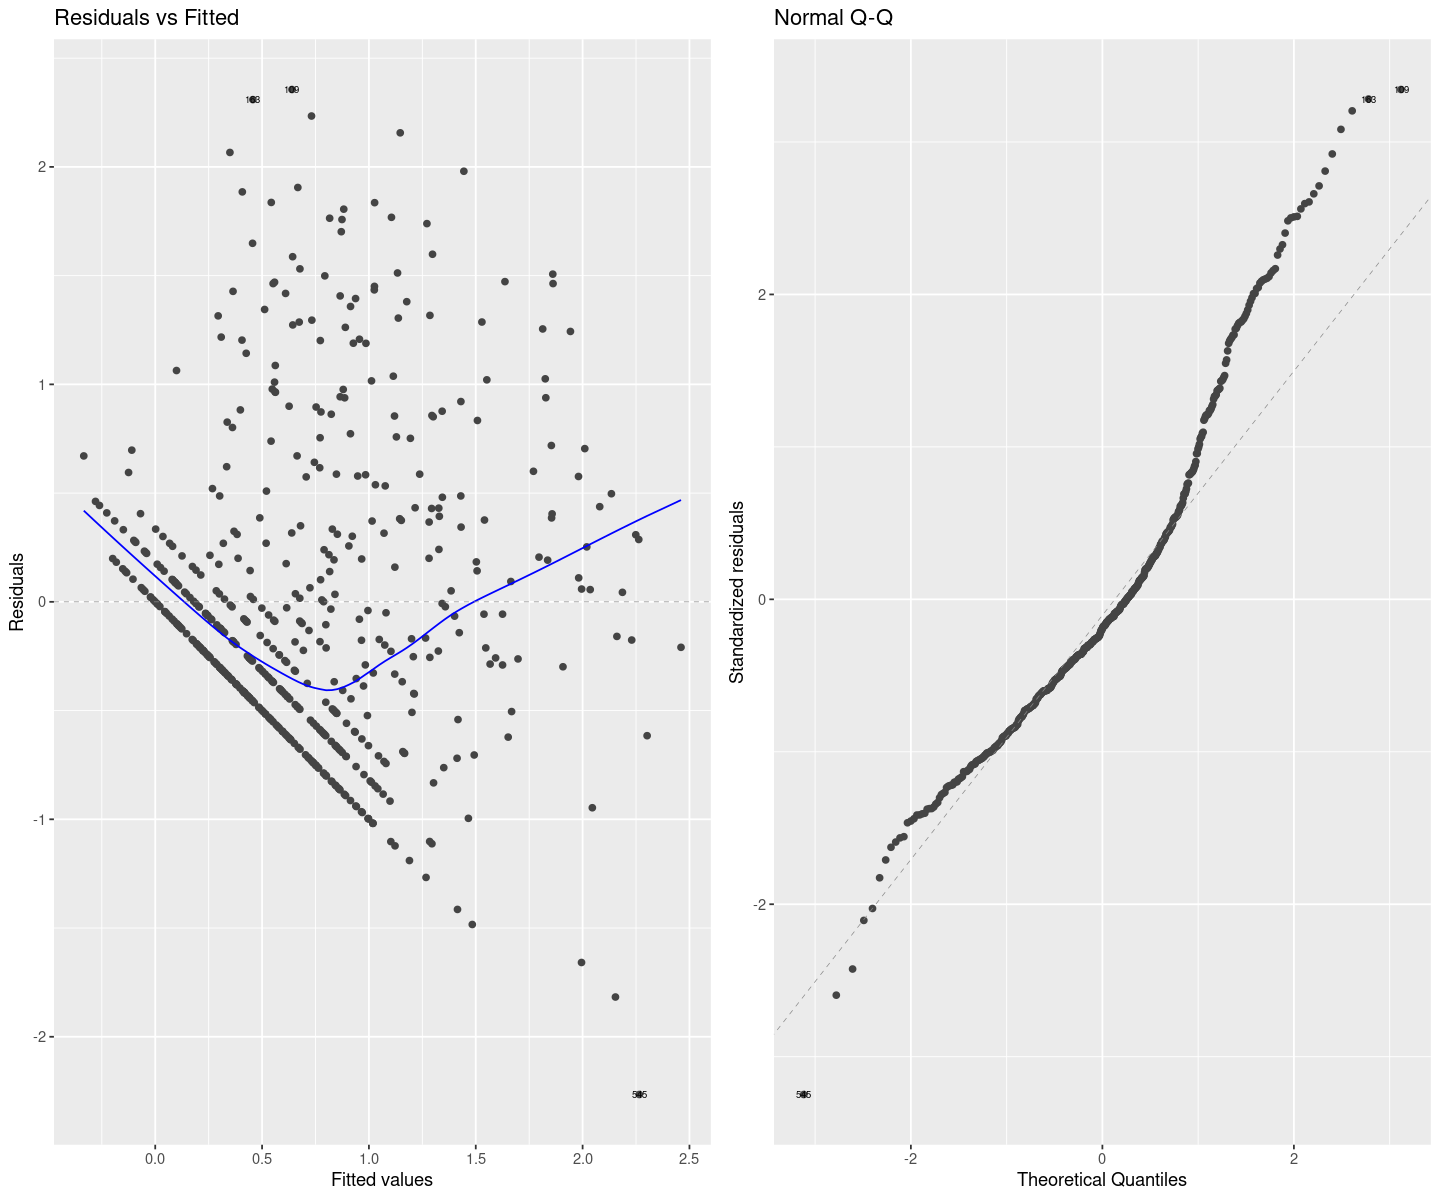

In [32]:
options(repr.plot.width = 12, repr.plot.height = 10)
autoplot(lin.reg.log, which=c(1,2), label.size=2)    

### 1.2. Linear regression without variable selection, applying to the `rain` reponse

In [33]:
lin.reg = lm(rain ~ ., data = train_set[,c(exp_var, "rain")])
summary(lin.reg)


Call:
lm(formula = rain ~ ., data = train_set[, c(exp_var, "rain")])

Residuals:
    Min      1Q  Median      3Q     Max 
-8.6959 -2.1731 -0.7763  0.6184 23.7098 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.496821   0.769383   4.545 6.83e-06 ***
ff             0.709571   0.710825   0.998  0.31863    
t            -10.249199   6.636738  -1.544  0.12312    
td             7.053990   6.327077   1.115  0.26541    
hu            -2.575633   2.325329  -1.108  0.26853    
dd            -0.713278   0.613300  -1.163  0.24535    
precip_log     0.740423   0.317892   2.329  0.02023 *  
ws_arome      -1.243244   0.797383  -1.559  0.11956    
p3031_arome    0.476998   0.639958   0.745  0.45639    
u10_arome      1.034278   0.359846   2.874  0.00422 ** 
v10_arome      1.002884   0.233210   4.300 2.03e-05 ***
t2m_arome     12.630014   6.475783   1.950  0.05167 .  
d2m_arome     -9.511573   5.921589  -1.606  0.10882    
r_arome        2.975995   2.101331   

#### Training error

In [34]:
print('TRAING ERROR')
print(paste('Mean Square Error : ', mean(lin.reg$residual**2)))
print(paste('MAPE : ', MAPE(lin.reg$fitted.values, y_train)))

pred_class = to_class(lin.reg$fitted.values, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

[1] "TRAING ERROR"
[1] "Mean Square Error :  14.4590378372337"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       126      107      51
  low_rain         28       88      73
  no_rain           1       39      37
[1] "Prediction accuracy :  0.456363636363636"


Warning message in all(hii == 0) || diff(hii) < 1e-10 * mean(hii, na.rm = TRUE):
“‘length(x) = 549 > 1’ dans la conversion automatique vers ‘logical(1)’”


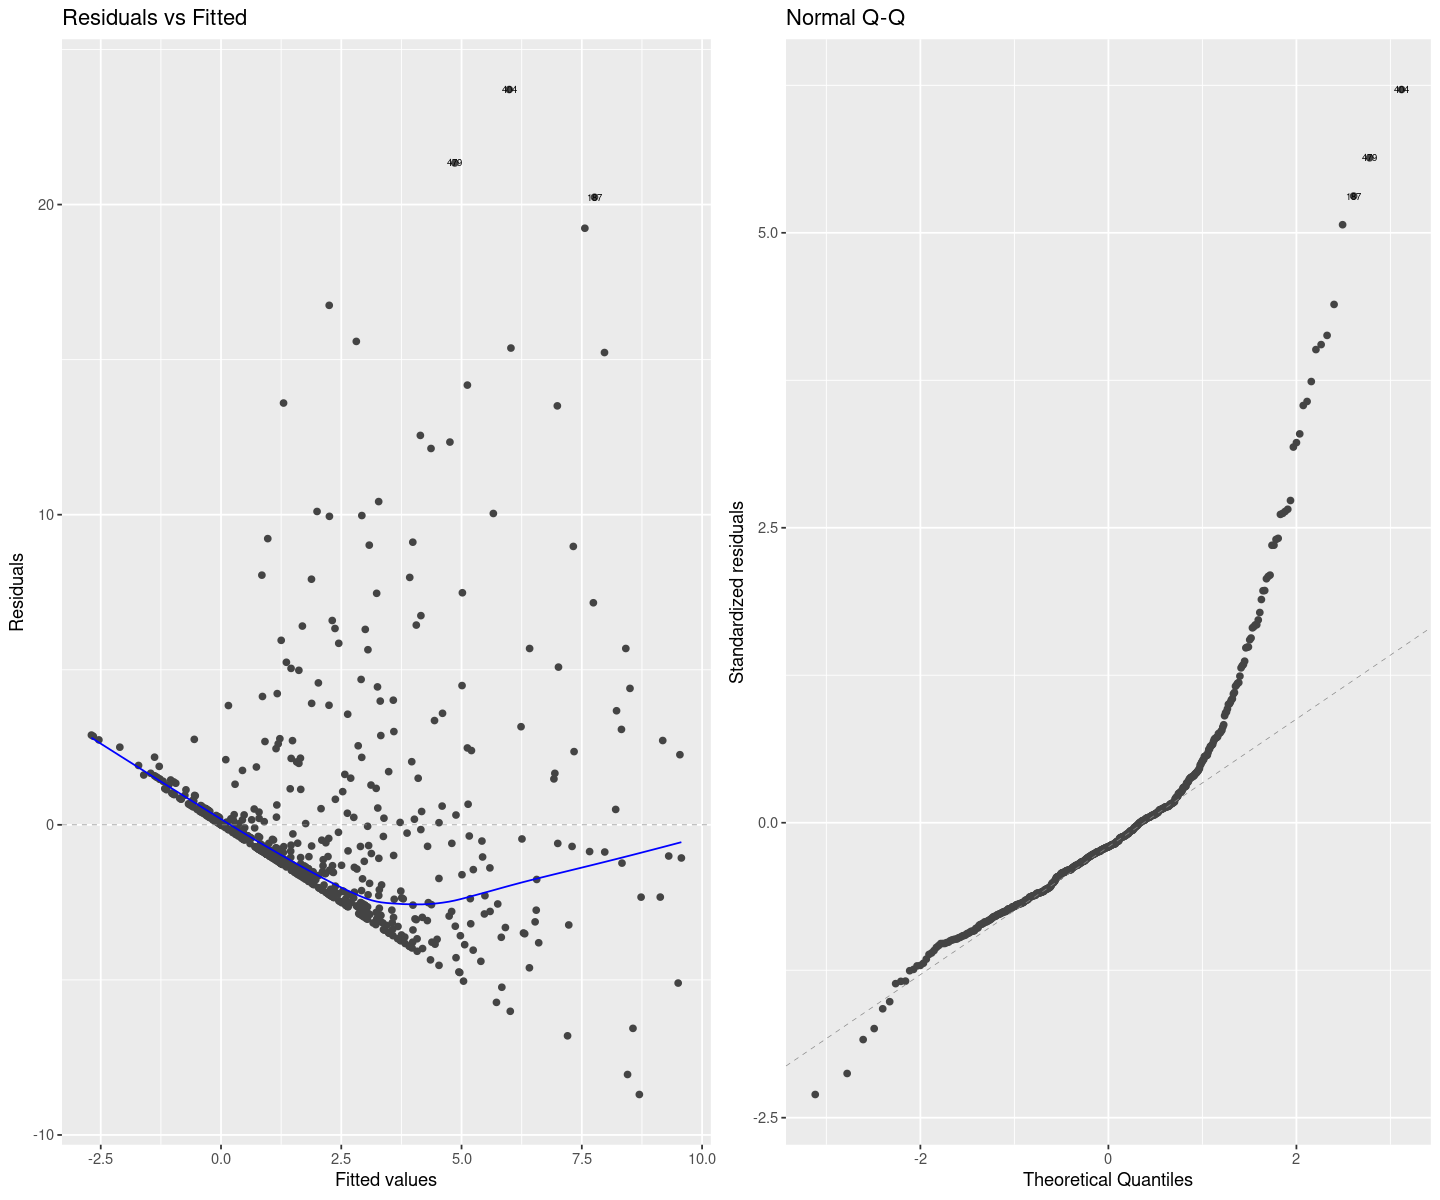

In [35]:
options(repr.plot.width = 12, repr.plot.height = 10)
autoplot(lin.reg,which=c(1,2),label.size=2)    

#### Test error

In [36]:
y_predict = predict(lin.reg, newdata = test_set)

print('TEST ERROR')
print(paste('Mean Square Error : ', MSE(y_predict, y_test)))
print(paste('MAPE : ', MAPE(y_predict, y_test)))

pred_class = to_class(y_predict, eps = 0.01)
confusion_matrix(pred_class, y_test_class)


[1] "TEST ERROR"
[1] "Mean Square Error :  21.3125251406604"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        29       28      21
  low_rain          2       24      18
  no_rain           2        6       8
[1] "Prediction accuracy :  0.442028985507246"


    We can see that, in the test set, the MAPE is smaller in linear regression with `rain` reponse than `rain_log`, but MSE is greater.

## 2. Variable selection

### 2.1 Variable selection for `rain_log` reponse

In this section, we will use some criterias such as BIC, Cp-Mallow and R2 score to determine whether a variable is useful or not. 

In [37]:
select.lin.reg.log <- regsubsets(rain_log ~., data = test_set[,c(exp_var, "rain_log")], nvmax=30, method="forward")
res.slr.log = summary(select.lin.reg.log)
res.slr.log

Subset selection object
Call: regsubsets.formula(rain_log ~ ., data = test_set[, c(exp_var, 
    "rain_log")], nvmax = 30, method = "forward")
26 Variables  (and intercept)
             Forced in Forced out
ff               FALSE      FALSE
t                FALSE      FALSE
td               FALSE      FALSE
hu               FALSE      FALSE
dd               FALSE      FALSE
precip_log       FALSE      FALSE
ws_arome         FALSE      FALSE
p3031_arome      FALSE      FALSE
u10_arome        FALSE      FALSE
v10_arome        FALSE      FALSE
t2m_arome        FALSE      FALSE
d2m_arome        FALSE      FALSE
r_arome          FALSE      FALSE
tp_arome_log     FALSE      FALSE
msl_arome        FALSE      FALSE
month2           FALSE      FALSE
month3           FALSE      FALSE
month4           FALSE      FALSE
month5           FALSE      FALSE
month6           FALSE      FALSE
month7           FALSE      FALSE
month8           FALSE      FALSE
month9           FALSE      FALSE
month10    

    We will look at how many important variables are retained by each creteria. 

In [38]:
str(data.frame(R2_Score = which.max(res.slr.log$adjr2), Cp_Mallow = which.min(res.slr.log$cp), BIC = which.min(res.slr.log$bic) ))

'data.frame':	1 obs. of  3 variables:
 $ R2_Score : int 10
 $ Cp_Mallow: int 7
 $ BIC      : int 2


    We retain 10, 7 and 2 variables for R2, Cp and BIC criterion respectively.

We'll see  which variables are retained

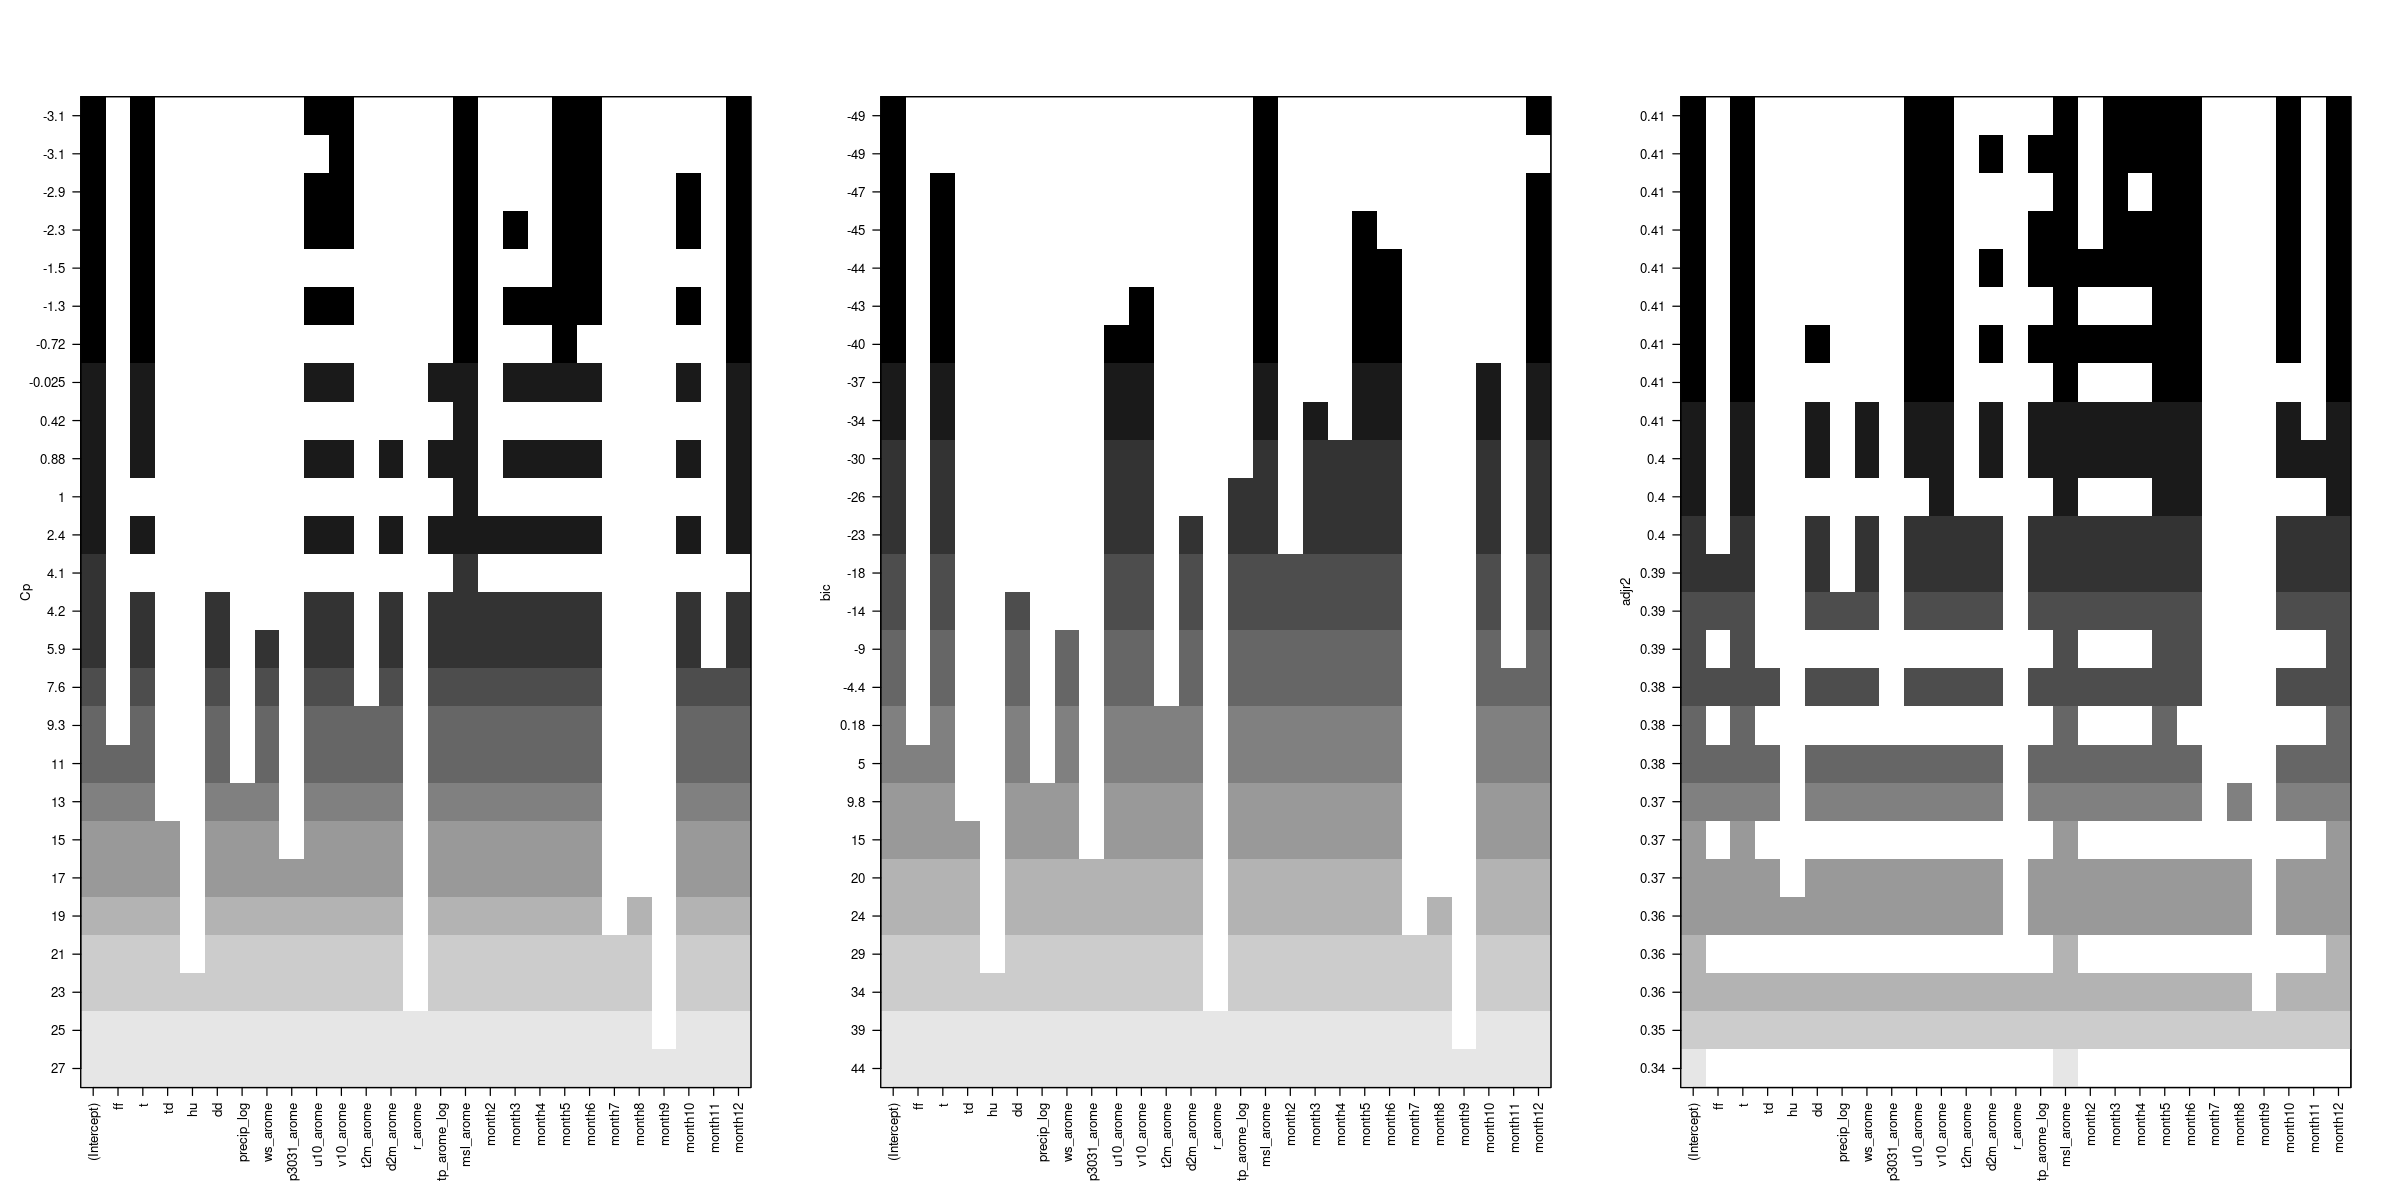

In [39]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(1,3))
plot(select.lin.reg.log, scale = "Cp")
plot(select.lin.reg.log, scale = "bic")
plot(select.lin.reg.log, scale = "adjr2")

By looking at these graphs, and considering the all 7 criterions, we decided to retain a linear model of 8 variables:
`t`, `u10_arome`, `v10_arome`, `tp_arome_log`, `msl_arome` and `month12`, 

In [40]:
retained.var.log = c("t", "u10_arome", "v10_arome", "tp_arome_log", "msl_arome", "month12")

In this case, we used `month1` (Jan.) as the reference.


#### Fit the linear model with selected variables

In [41]:
selected.lin.reg.log = lm(rain_log ~ t + u10_arome + v10_arome + tp_arome_log + msl_arome + month12, data = train_set[,c(retained.var.log, "rain_log")])
summary(selected.lin.reg.log)


Call:
lm(formula = rain_log ~ t + u10_arome + v10_arome + tp_arome_log + 
    msl_arome + month12, data = train_set[, c(retained.var.log, 
    "rain_log")])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0636 -0.4770 -0.1398  0.2834  2.5283 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.72576    0.03260  22.260  < 2e-16 ***
t            -0.15521    0.03382  -4.590 5.52e-06 ***
u10_arome     0.18600    0.03672   5.065 5.60e-07 ***
v10_arome     0.16617    0.03438   4.834 1.75e-06 ***
tp_arome_log -0.01541    0.04362  -0.353   0.7240    
msl_arome    -0.30046    0.04036  -7.444 3.85e-13 ***
month12       0.21119    0.12274   1.721   0.0859 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7309 on 543 degrees of freedom
Multiple R-squared:  0.3123,	Adjusted R-squared:  0.3047 
F-statistic:  41.1 on 6 and 543 DF,  p-value: < 2.2e-16


#### Training error

In [42]:
print('TRAING ERROR IN LOG SCALE')
print(paste('Mean Square Error : ', mean(selected.lin.reg.log$residual**2)))
print(paste('MAPE : ', MAPE(selected.lin.reg.log$fitted.values, y_train_log)))

pred_class = to_class(selected.lin.reg.log$fitted.values, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

[1] "TRAING ERROR IN LOG SCALE"
[1] "Mean Square Error :  0.527457807720186"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        11        1       1
  low_rain        144      225     149
  no_rain           0        8      11
[1] "Prediction accuracy :  0.449090909090909"


In [43]:
print('TRAINING ERROR')
print(paste('Mean Square Error : ', MSE(to_rain(selected.lin.reg.log$fitted.values), y_train)))
print(paste('MAPE : ', MAPE(to_rain(selected.lin.reg.log$fitted.values), y_train)))

pred_class = to_class(to_rain(selected.lin.reg.log$fitted.values), eps = 0.01)
confusion_matrix(pred_class, y_train_class)

[1] "TRAINING ERROR"
[1] "Mean Square Error :  16.7318645844248"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        70       26       7
  low_rain         85      200     143
  no_rain           0        8      11
[1] "Prediction accuracy :  0.510909090909091"


    We can notice that the training MAPE is slightly decreased in this selected model

#### Test error

In [44]:
y_predict_log = predict(selected.lin.reg.log, newdata = test_set)
y_predict = to_rain(y_predict_log)


print('TEST ERROR IN LOG SCALE')
print(paste('Mean Square Error : ', MSE(y_predict_log, y_test_log)))
print(paste('MAPE : ', MAPE(y_predict_log, y_test_log)))

pred_class = to_class(y_predict_log, eps = 0.01)
confusion_matrix(pred_class, y_test_class)


print('TEST ERROR')
print(paste('Mean Square Error : ', MSE(y_predict, y_test)))
print(paste('MAPE : ', MAPE(y_predict, y_test)))

pred_class = to_class(y_predict, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "TEST ERROR IN LOG SCALE"
[1] "Mean Square Error :  0.50143160860573"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain         6        0       0
  low_rain         27       58      47
[1] "Prediction accuracy :  0.463768115942029"
[1] "TEST ERROR"
[1] "Mean Square Error :  18.3125035476811"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        23       11       4
  low_rain         10       47      43
[1] "Prediction accuracy :  0.507246376811594"



The MAPE in test set is dramatically descresed comparing to the linear model with `rain_log` reponse, but it's still greater than the linear model with `rain` reponse. It seems that this transformation to ``rain_log` does perfom very well, even when it makes the reponse to be more gaussian. 

### 2.1 Variable selection for `rain` reponse

In [45]:
select.lin.reg <- regsubsets(rain ~., data = test_set[,c(exp_var, "rain")], nvmax=30, method="forward")
res.slr = summary(select.lin.reg)
res.slr

Subset selection object
Call: regsubsets.formula(rain ~ ., data = test_set[, c(exp_var, "rain")], 
    nvmax = 30, method = "forward")
26 Variables  (and intercept)
             Forced in Forced out
ff               FALSE      FALSE
t                FALSE      FALSE
td               FALSE      FALSE
hu               FALSE      FALSE
dd               FALSE      FALSE
precip_log       FALSE      FALSE
ws_arome         FALSE      FALSE
p3031_arome      FALSE      FALSE
u10_arome        FALSE      FALSE
v10_arome        FALSE      FALSE
t2m_arome        FALSE      FALSE
d2m_arome        FALSE      FALSE
r_arome          FALSE      FALSE
tp_arome_log     FALSE      FALSE
msl_arome        FALSE      FALSE
month2           FALSE      FALSE
month3           FALSE      FALSE
month4           FALSE      FALSE
month5           FALSE      FALSE
month6           FALSE      FALSE
month7           FALSE      FALSE
month8           FALSE      FALSE
month9           FALSE      FALSE
month10          FA

In [46]:
str(data.frame(R2_Score = which.max(res.slr$adjr2), Cp_Mallow = which.min(res.slr$cp), BIC = which.min(res.slr$bic) ))

'data.frame':	1 obs. of  3 variables:
 $ R2_Score : int 7
 $ Cp_Mallow: int 4
 $ BIC      : int 2


We retain 7, 4 and 2 variables for R2, Cp and BIC criterion respectively

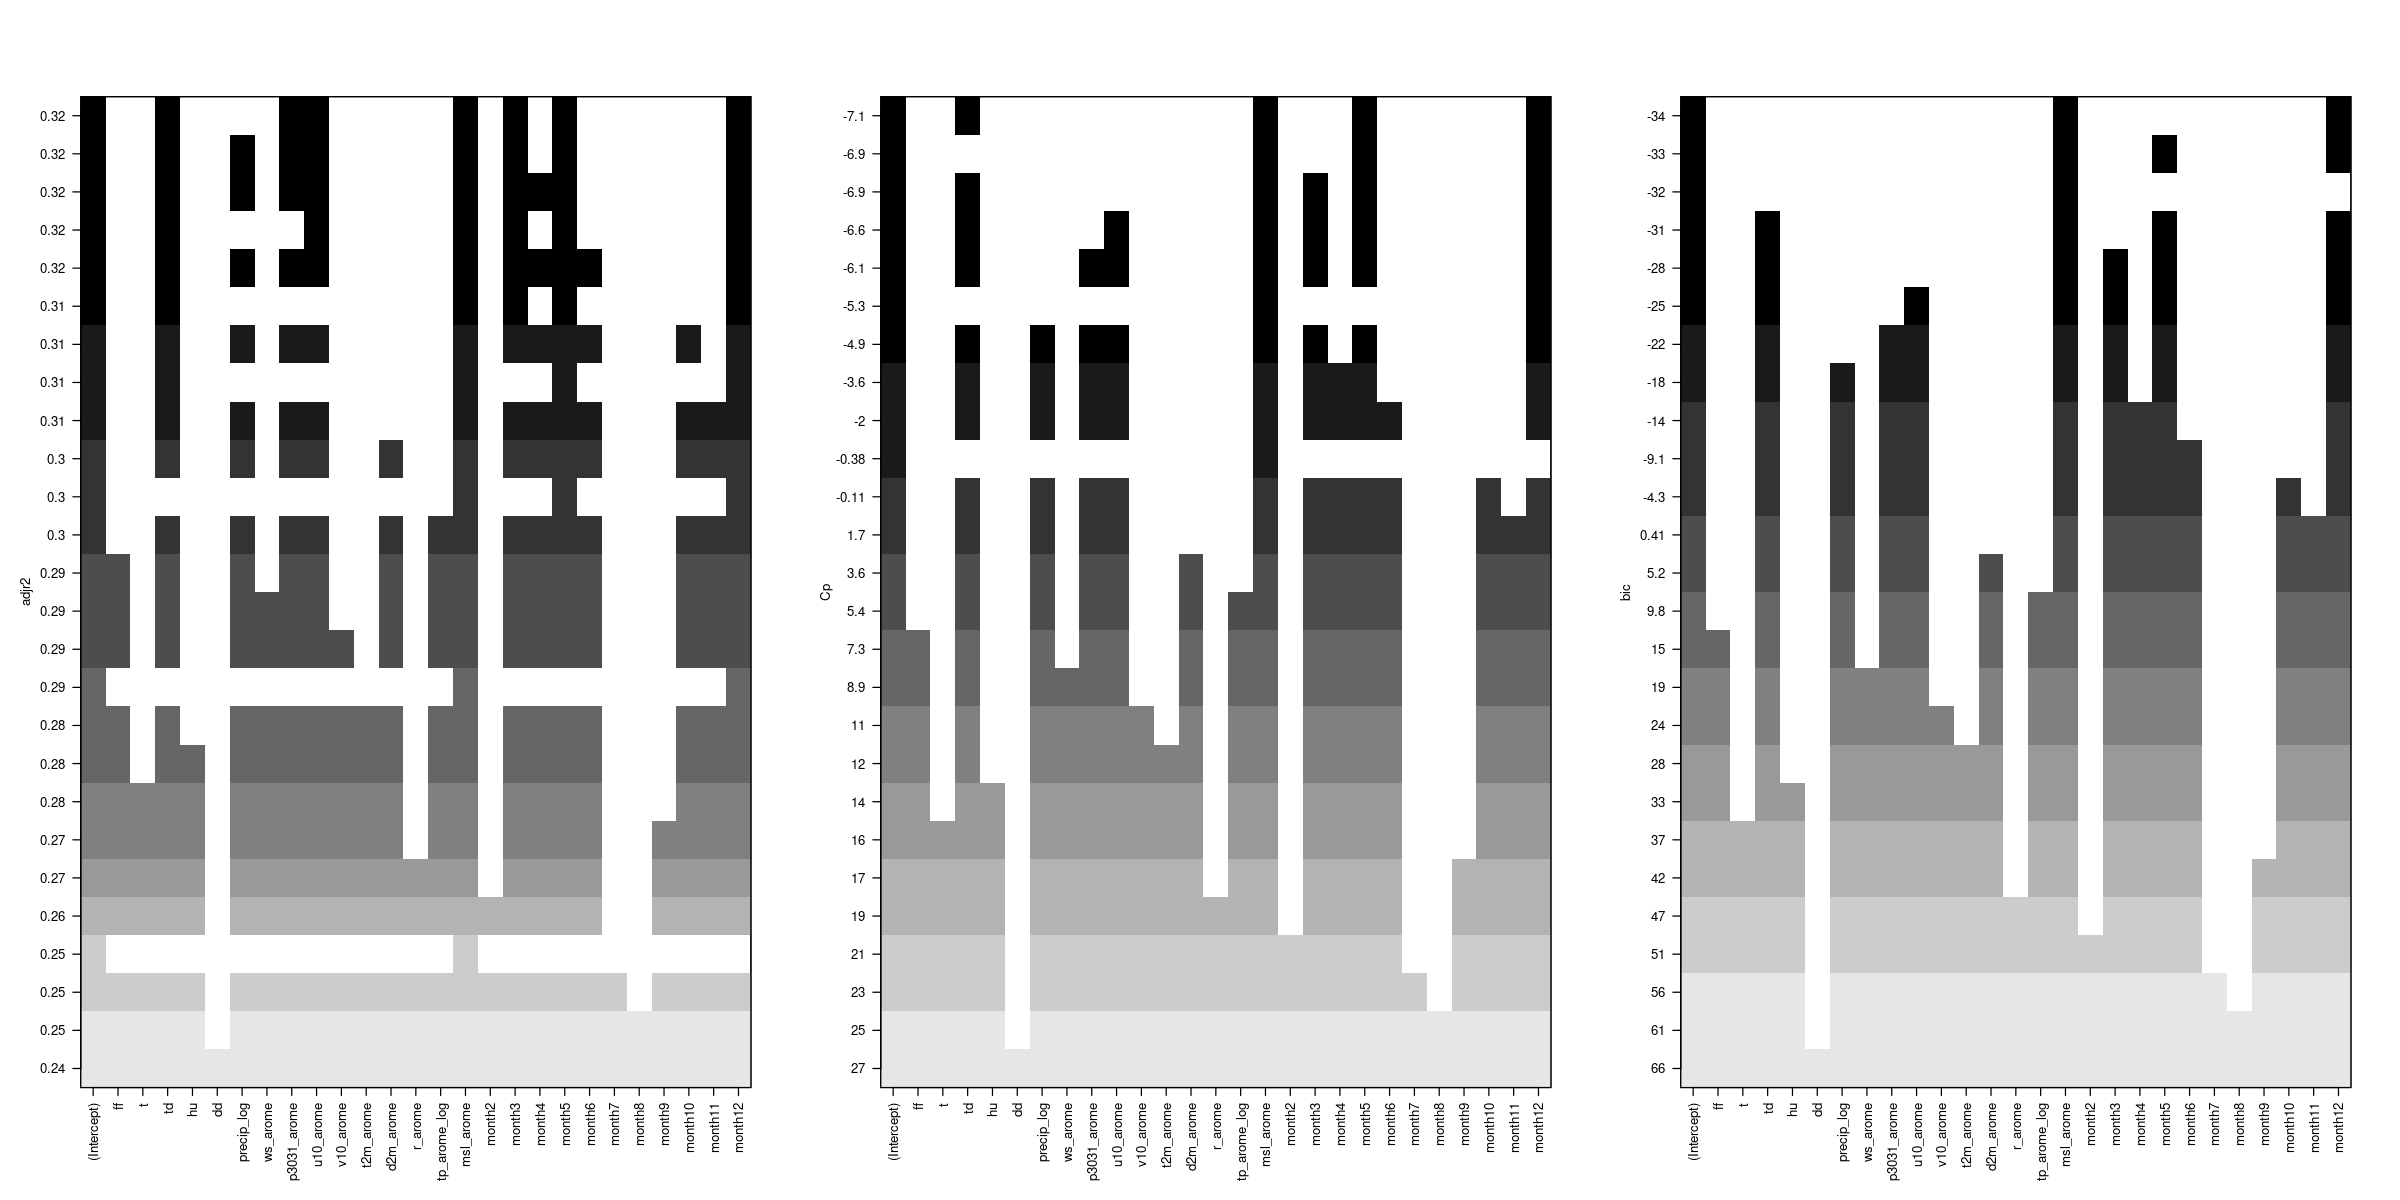

In [47]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(1,3))
plot(select.lin.reg, scale = "adjr2")
plot(select.lin.reg, scale = "Cp")
plot(select.lin.reg, scale = "bic")


In [48]:
names(train_set)

[1] "ff"           "t"            "td"           "hu"           "dd"          
 [6] "precip_log"   "ws_arome"     "p3031_arome"  "u10_arome"    "v10_arome"   
[11] "t2m_arome"    "d2m_arome"    "r_arome"      "tp_arome_log" "msl_arome"   
[16] "rain"         "rain_class"   "rain_log"     "month2"       "month3"      
[21] "month4"       "month5"       "month6"       "month7"       "month8"      
[26] "month9"       "month10"      "month11"      "month12"

    We will test 3 models corresponding to the the creterions and compare them

By looking at these graphs, and considering the all 3 criterions, we decided to retain a linear model of 6 variables:
`td`, `u10_arome`, `v10_arome`, `precip_log`, `msl_arome` and `month12`

In [49]:
retained.var = c("msl_arome", "month12")

In this case, we used `month1` (Jan.) as the reference.


#### Linear model for selected variables

In [50]:
exp_var = setdiff(names(train_set), c("rain", "rain_log", "rain_class"))
exp_var

[1] "ff"           "t"            "td"           "hu"           "dd"          
 [6] "precip_log"   "ws_arome"     "p3031_arome"  "u10_arome"    "v10_arome"   
[11] "t2m_arome"    "d2m_arome"    "r_arome"      "tp_arome_log" "msl_arome"   
[16] "month2"       "month3"       "month4"       "month5"       "month6"      
[21] "month7"       "month8"       "month9"       "month10"      "month11"     
[26] "month12"

#### Model with variables selected by R2 Score

In [51]:
selected.lin.reg = lm(rain ~ td + p3031_arome + u10_arome + msl_arome + month3 + month5 + month12, data = train_set[,c(exp_var, "rain")])
summary(selected.lin.reg)


Call:
lm(formula = rain ~ td + p3031_arome + u10_arome + msl_arome + 
    month3 + month5 + month12, data = train_set[, c(exp_var, 
    "rain")])

Residuals:
    Min      1Q  Median      3Q     Max 
-9.2680 -1.8857 -0.8714  0.2256 25.1633 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.3580     0.1986  11.872  < 2e-16 ***
td           -0.5324     0.1817  -2.930  0.00353 ** 
p3031_arome  -0.5309     0.2863  -1.854  0.06423 .  
u10_arome     1.3561     0.3068   4.420 1.19e-05 ***
msl_arome    -1.3694     0.1884  -7.267 1.29e-12 ***
month3        0.4323     0.6453   0.670  0.50322    
month5       -0.5458     0.6237  -0.875  0.38186    
month12       1.1060     0.6641   1.666  0.09638 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.003 on 542 degrees of freedom
Multiple R-squared:  0.2007,	Adjusted R-squared:  0.1904 
F-statistic: 19.44 on 7 and 542 DF,  p-value: < 2.2e-16


In [52]:
print('TRAING ERROR')
print(paste('Mean Square Error : ', MSE(selected.lin.reg$fitted.values, y_train)))
print(paste('MAPE : ', MAPE(selected.lin.reg$fitted.values, y_train)))

pred_class = to_class(selected.lin.reg$fitted.values, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

[1] "TRAING ERROR"
[1] "Mean Square Error :  15.7905851795013"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       121       97      49
  low_rain         33      125      99
  no_rain           1       12      13
[1] "Prediction accuracy :  0.470909090909091"


In [53]:
y_predict = predict(selected.lin.reg, newdata = test_set)

print('TEST ERROR')
print(paste('Mean Square Error : ', MSE(y_predict, y_test)))
print(paste('MAPE : ', MAPE(y_predict, y_test)))

pred_class = to_class(y_predict, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "TEST ERROR"
[1] "Mean Square Error :  19.3827900641636"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        30       24      13
  low_rain          2       34      32
  no_rain           1        0       2
[1] "Prediction accuracy :  0.478260869565217"


#### Model with variables selected by Cp

In [54]:
selected.lin.reg = lm(rain ~ td + msl_arome + month5 + month12, data = train_set[,c(exp_var, "rain")])
summary(selected.lin.reg)


Call:
lm(formula = rain ~ td + msl_arome + month5 + month12, data = train_set[, 
    c(exp_var, "rain")])

Residuals:
    Min      1Q  Median      3Q     Max 
-9.2605 -1.9671 -0.9591  0.0854 25.7952 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.4418     0.1913  12.761   <2e-16 ***
td           -0.4049     0.1777  -2.279   0.0230 *  
msl_arome    -1.7294     0.1794  -9.639   <2e-16 ***
month5       -1.2846     0.6203  -2.071   0.0388 *  
month12       1.2513     0.6709   1.865   0.0627 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.093 on 545 degrees of freedom
Multiple R-squared:  0.1597,	Adjusted R-squared:  0.1535 
F-statistic: 25.89 on 4 and 545 DF,  p-value: < 2.2e-16


In [55]:
print('TRAING ERROR')
print(paste('Mean Square Error : ', MSE(selected.lin.reg$fitted.values, y_train)))
print(paste('MAPE : ', MAPE(selected.lin.reg$fitted.values, y_train)))

[1] "TRAING ERROR"
[1] "Mean Square Error :  16.6007565321759"
[1] "MAPE :  Inf"


In [56]:
y_predict = predict(selected.lin.reg, newdata = test_set)

print('TEST ERROR')
print(paste('Mean Square Error : ', MSE(y_predict, y_test)))
print(paste('MAPE : ', MAPE(y_predict, y_test)))

pred_class = to_class(y_predict, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "TEST ERROR"
[1] "Mean Square Error :  19.6902803085938"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        31       25      20
  low_rain          1       32      26
  no_rain           1        1       1
[1] "Prediction accuracy :  0.463768115942029"


#### Model with variables selected by BIC

In [57]:
selected.lin.reg = lm(rain ~ msl_arome + month12, data = train_set[,c(exp_var, "rain")])
summary(selected.lin.reg)


Call:
lm(formula = rain ~ msl_arome + month12, data = train_set[, c(exp_var, 
    "rain")])

Residuals:
    Min      1Q  Median      3Q     Max 
-8.8819 -2.0878 -1.0142  0.3469 26.2930 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.2958     0.1832  12.533   <2e-16 ***
msl_arome    -1.7035     0.1799  -9.467   <2e-16 ***
month12       1.6843     0.6596   2.553   0.0109 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.124 on 547 degrees of freedom
Multiple R-squared:  0.1436,	Adjusted R-squared:  0.1405 
F-statistic: 45.87 on 2 and 547 DF,  p-value: < 2.2e-16


In [58]:
print('TRAING ERROR')
print(paste('Mean Square Error : ', MSE(selected.lin.reg$fitted.values, y_train)))
print(paste('MAPE : ', MAPE(selected.lin.reg$fitted.values, y_train)))

[1] "TRAING ERROR"
[1] "Mean Square Error :  16.9178860456835"
[1] "MAPE :  Inf"


In [59]:
y_predict = predict(selected.lin.reg, newdata = test_set)

print('TEST ERROR')
print(paste('Mean Square Error : ', MSE(y_predict, y_test)))
print(paste('MAPE : ', MAPE(y_predict, y_test)))

pred_class = to_class(y_predict, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "TEST ERROR"
[1] "Mean Square Error :  19.4248301397696"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        30       25      21
  low_rain          3       33      24
  no_rain           0        0       2
[1] "Prediction accuracy :  0.471014492753623"


    This is the simplest model since the beginning with just 2 explicative variables but 
    we got the smallest MAPE in the test set from the beginning.

    Simple makes perfect!

## 2. Linear regression with penalty - Rigde and Lasso

    we have seen in the last section that the transformation to `rain_log` does not perform well as we expected. So in the following sections, we just use the `rain` as the reponse variable

In [60]:
exp_var = setdiff(names(train_set), c("rain", "rain_log", "rain_class"))
x_train = as.matrix(train_set[,exp_var])
x_test = as.matrix(test_set[, exp_var])
n_var = length(exp_var)

In [61]:
regularisation_path = function(model){
    df = data.frame(
        lambda = rep(model$lambda, n_var),
        theta = as.vector(t(model$beta)),
        variables = rep(exp_var, each = length(model$lambda))
    )

    plt = ggplot(df, aes(x = lambda, y = theta, col = variables)) +
    geom_line() +
    theme(legend.position = "bottom") + theme_minimal()
    return(plt)    
}

In [62]:
param_plot = function(coef){
    names = rownames(coef)
    str = coef[1:length(coef)]
    ord = order(str)
    df = data.frame(theta = names[ord], strength = str[ord])
    df$theta = factor(df$theta, levels = df$theta)

    ggplot(data = df, aes(x = theta, y = strength)) + 
        geom_bar(stat = "identity", fill = "steelblue") +
        coord_flip() +
        theme_minimal()
}

### 2.1. Ridge Regression 

We will fit a Ridge regression model using `glmnet` package, by varying the hyper-parameter `lambda` over the interval $[0,1]$ with a step of $0.001$

In [63]:
lambda_seq = seq(0, 100, by = 0.01)
reg.ridge = glmnet(x = x_train, y = y_train, alpha = 0, lambda = lambda_seq, standardize = TRUE)
summary(reg.ridge)

          Length Class     Mode   
a0         10001 -none-    numeric
beta      260026 dgCMatrix S4     
df         10001 -none-    numeric
dim            2 -none-    numeric
lambda     10001 -none-    numeric
dev.ratio  10001 -none-    numeric
nulldev        1 -none-    numeric
npasses        1 -none-    numeric
jerr           1 -none-    numeric
offset         1 -none-    logical
call           6 -none-    call   
nobs           1 -none-    numeric

We plot as below the regularisation paths, i.e the function $\lambda \mapsto \hat{\theta}_\text{ridge}(\lambda) $

In [64]:
plt.ridge = regularisation_path(reg.ridge)
# ggplotly(plt.ridge)

Now we'll use the cross validation method in order to select the best $\lambda$ by MSE

In [65]:
ridge_cv <- cv.glmnet(x = x_train, y = y_train, alpha = 0, lambda = lambda_seq, standardize = TRUE)
ridge_cv$lambda.min
ridge_cv$lambda.1se


[1] 0.94

[1] 44.76

In [66]:
# plot(ridge_cv)

So the best $\lambda$ is ...

In [67]:
plt.ridge = plt.ridge + 
  geom_vline(xintercept = ridge_cv$lambda.min, color = "black", size=.8) +
  geom_vline(xintercept = ridge_cv$lambda.1se, color = "black", size=.8) +
  xlim(c(0,ridge_cv$lambda.1se + 0.1))
# ggplotly(plt.ridge)

#### Get the best Ridge model from cross-validation

In [68]:
ridge.lamb.min = ridge_cv$lambda.min
ridge.lamb.1se = ridge_cv$lambda.1se

best.ridge.reg = glmnet(x = x_train, y = y_train, alpha = 0, standardize = TRUE)

coef.ridge.min <- coef(best.ridge.reg, s = ridge.lamb.min, exact = TRUE, x = x_train, y = y_train)
coef.ridge.1se <- coef(best.ridge.reg, s = ridge.lamb.1se, exact = TRUE, x = x_train, y = y_train)

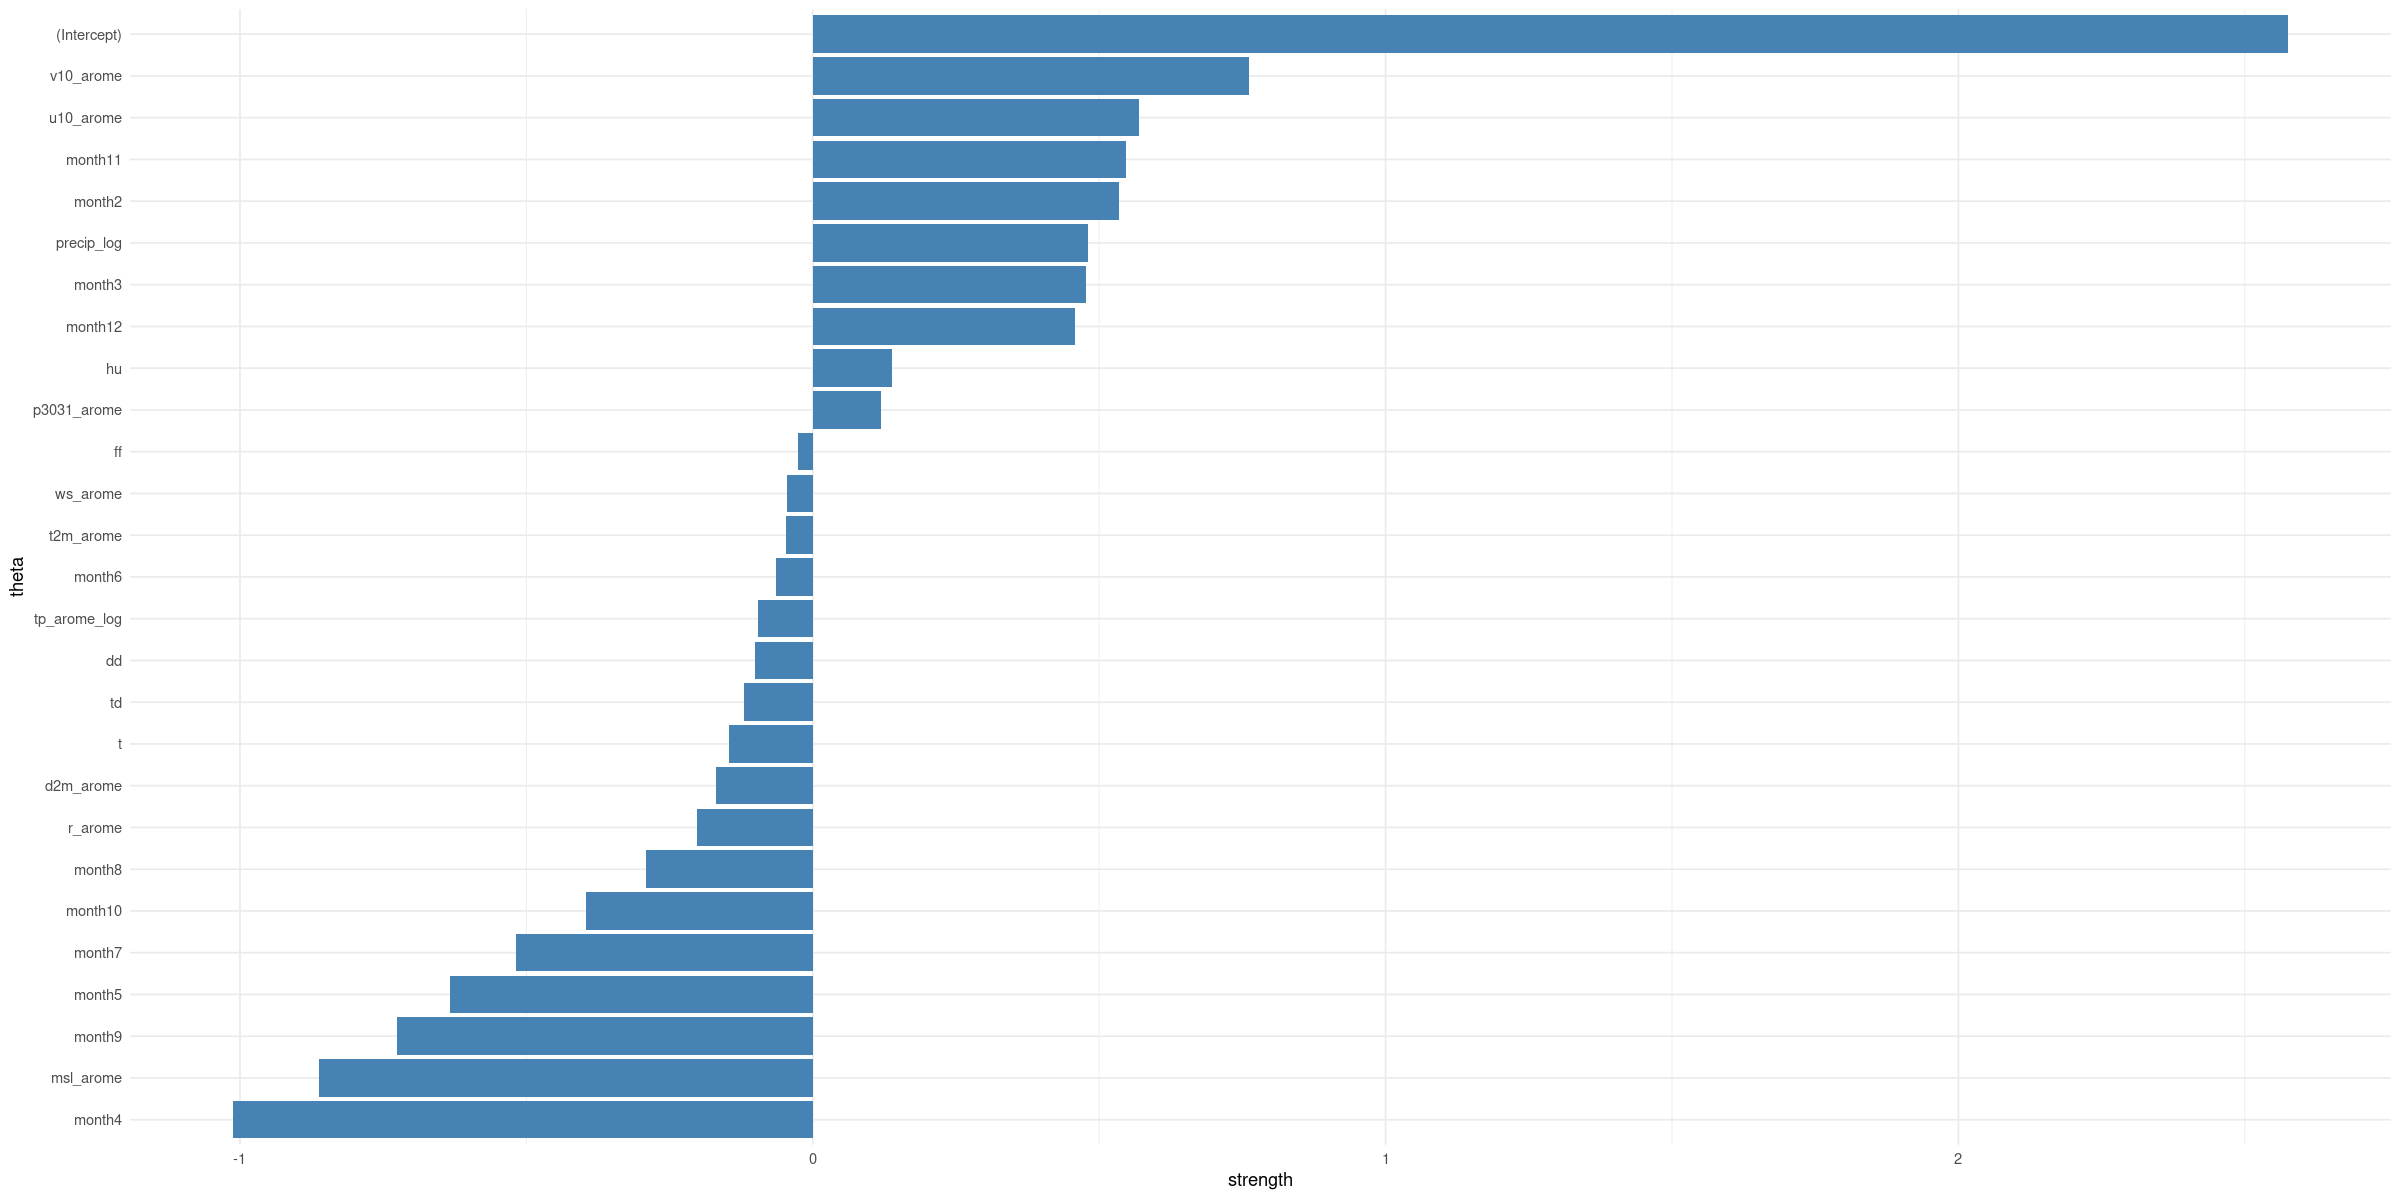

In [69]:
param_plot(coef.ridge.min)

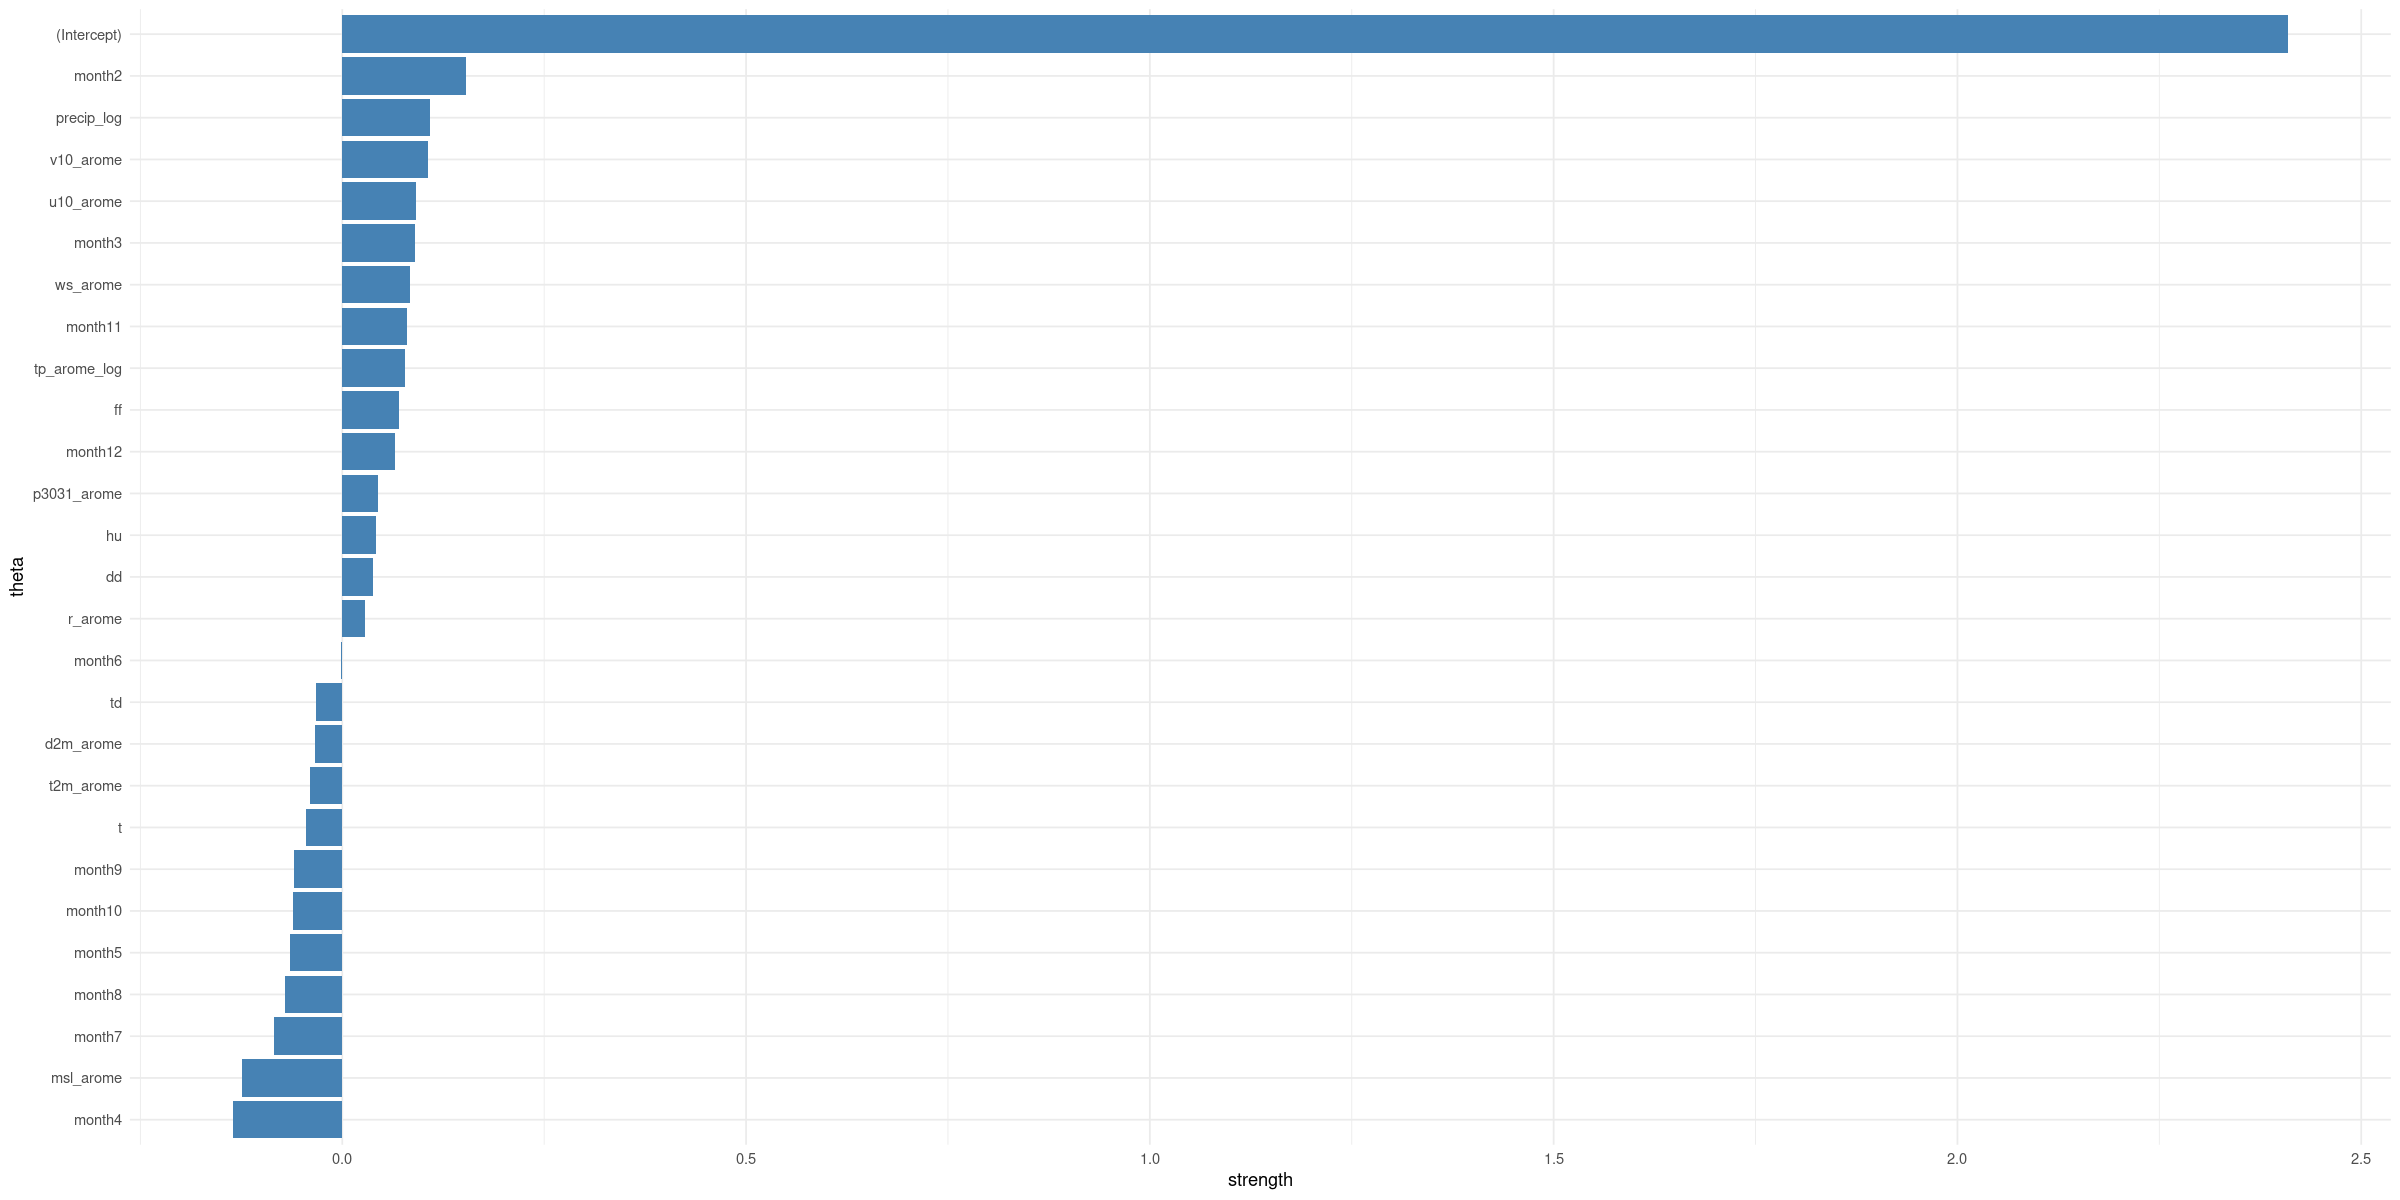

In [70]:
param_plot(coef.ridge.1se)

#### Performance of Rigde Regression

In [71]:
y_predict_train_min = predict(best.ridge.reg, newx = x_train, type = 'response' , s = ridge.lamb.min)
y_predict_test_min = predict(best.ridge.reg, newx = x_test, type = 'response' , s = ridge.lamb.min)

y_predict_train_1se = predict(best.ridge.reg, newx = x_train, type = 'response' , s = ridge.lamb.1se)
y_predict_test_1se = predict(best.ridge.reg, newx = x_test, type = 'response' , s = ridge.lamb.1se)

In [72]:
print('TRAINING ERROR LAMBDA MIN')
print(paste('Mean Square Error : ', MSE(y_predict_train_min, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_min, y_train)))

pred_class = to_class(y_predict_train_min, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

[1] "TRAINING ERROR LAMBDA MIN"
[1] "Mean Square Error :  14.8481104299755"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       127      106      50
  low_rain         28       96      94
  no_rain           0       32      17
[1] "Prediction accuracy :  0.436363636363636"


In [73]:
print('TRAINING ERROR LAMBDA 1SE')
print(paste('Mean Square Error : ', MSE(y_predict_train_1se, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_1se, y_train)))

pred_class = to_class(y_predict_train_1se, eps = 0.01)
confusion_matrix(pred_class, y_train_class)



[1] "TRAINING ERROR LAMBDA 1SE"
[1] "Mean Square Error :  17.7550270695765"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       139      157      96
  low_rain         16       77      65
[1] "Prediction accuracy :  0.392727272727273"


In [74]:
print('TEST ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_test_min, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_min, y_test)))

pred_class = to_class(y_predict_test_min, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "TEST ERROR MIN"
[1] "Mean Square Error :  20.5666383694781"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        30       27      19
  low_rain          1       30      25
  no_rain           2        1       3
[1] "Prediction accuracy :  0.456521739130435"


In [75]:
print('TEST ERROR 1SE')
print(paste('Mean Square Error : ', MSE(y_predict_test_1se, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_1se, y_test)))

pred_class = to_class(y_predict_train_min, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_train_1se, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_test_min, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

pred_class = to_class(y_predict_test_1se, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "TEST ERROR 1SE"
[1] "Mean Square Error :  23.5581119670247"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       127      106      50
  low_rain         28       96      94
  no_rain           0       32      17
[1] "Prediction accuracy :  0.436363636363636"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       139      157      96
  low_rain         16       77      65
[1] "Prediction accuracy :  0.392727272727273"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        30       27      19
  low_rain          1       30      25
  no_rain           2        1       3
[1] "Prediction accuracy :  0.456521739130435"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        31       42      30
  low_rain          2       16      17
[1] "Prediction accuracy :  0.340579710144928"


### 2.2. Lasso Regression

The idea of LASSO (Least Absolute Selection and Shrinkage Operator) Regression is to try to cancel some coefficients of $\theta$ to have a sparse estimator. Mathematically, we add a $l_1$ constraint to our optimization problem.

We proceed this with the same approach as Ridge Regression, with a notice that `alpha = 1` means Lasso regression.

In [76]:
lambda_seq = seq(0, 2, by = 0.001)
reg.lasso <- glmnet(x = x_train, y = y_train, alpha = 1, lambda = lambda_seq, standardize=TRUE)
summary(reg.lasso)

          Length Class     Mode   
a0         2001  -none-    numeric
beta      52026  dgCMatrix S4     
df         2001  -none-    numeric
dim           2  -none-    numeric
lambda     2001  -none-    numeric
dev.ratio  2001  -none-    numeric
nulldev       1  -none-    numeric
npasses       1  -none-    numeric
jerr          1  -none-    numeric
offset        1  -none-    logical
call          6  -none-    call   
nobs          1  -none-    numeric

In [77]:
plt.lasso = regularisation_path(reg.lasso)
# ggplotly(plt.lasso)

In [78]:
lasso_cv <- cv.glmnet(x = x_train, y = y_train, alpha=1, lambda=lambda_seq, standardize=TRUE)
lasso_cv$lambda.min
lasso_cv$lambda.1se

[1] 0.178

[1] 0.868

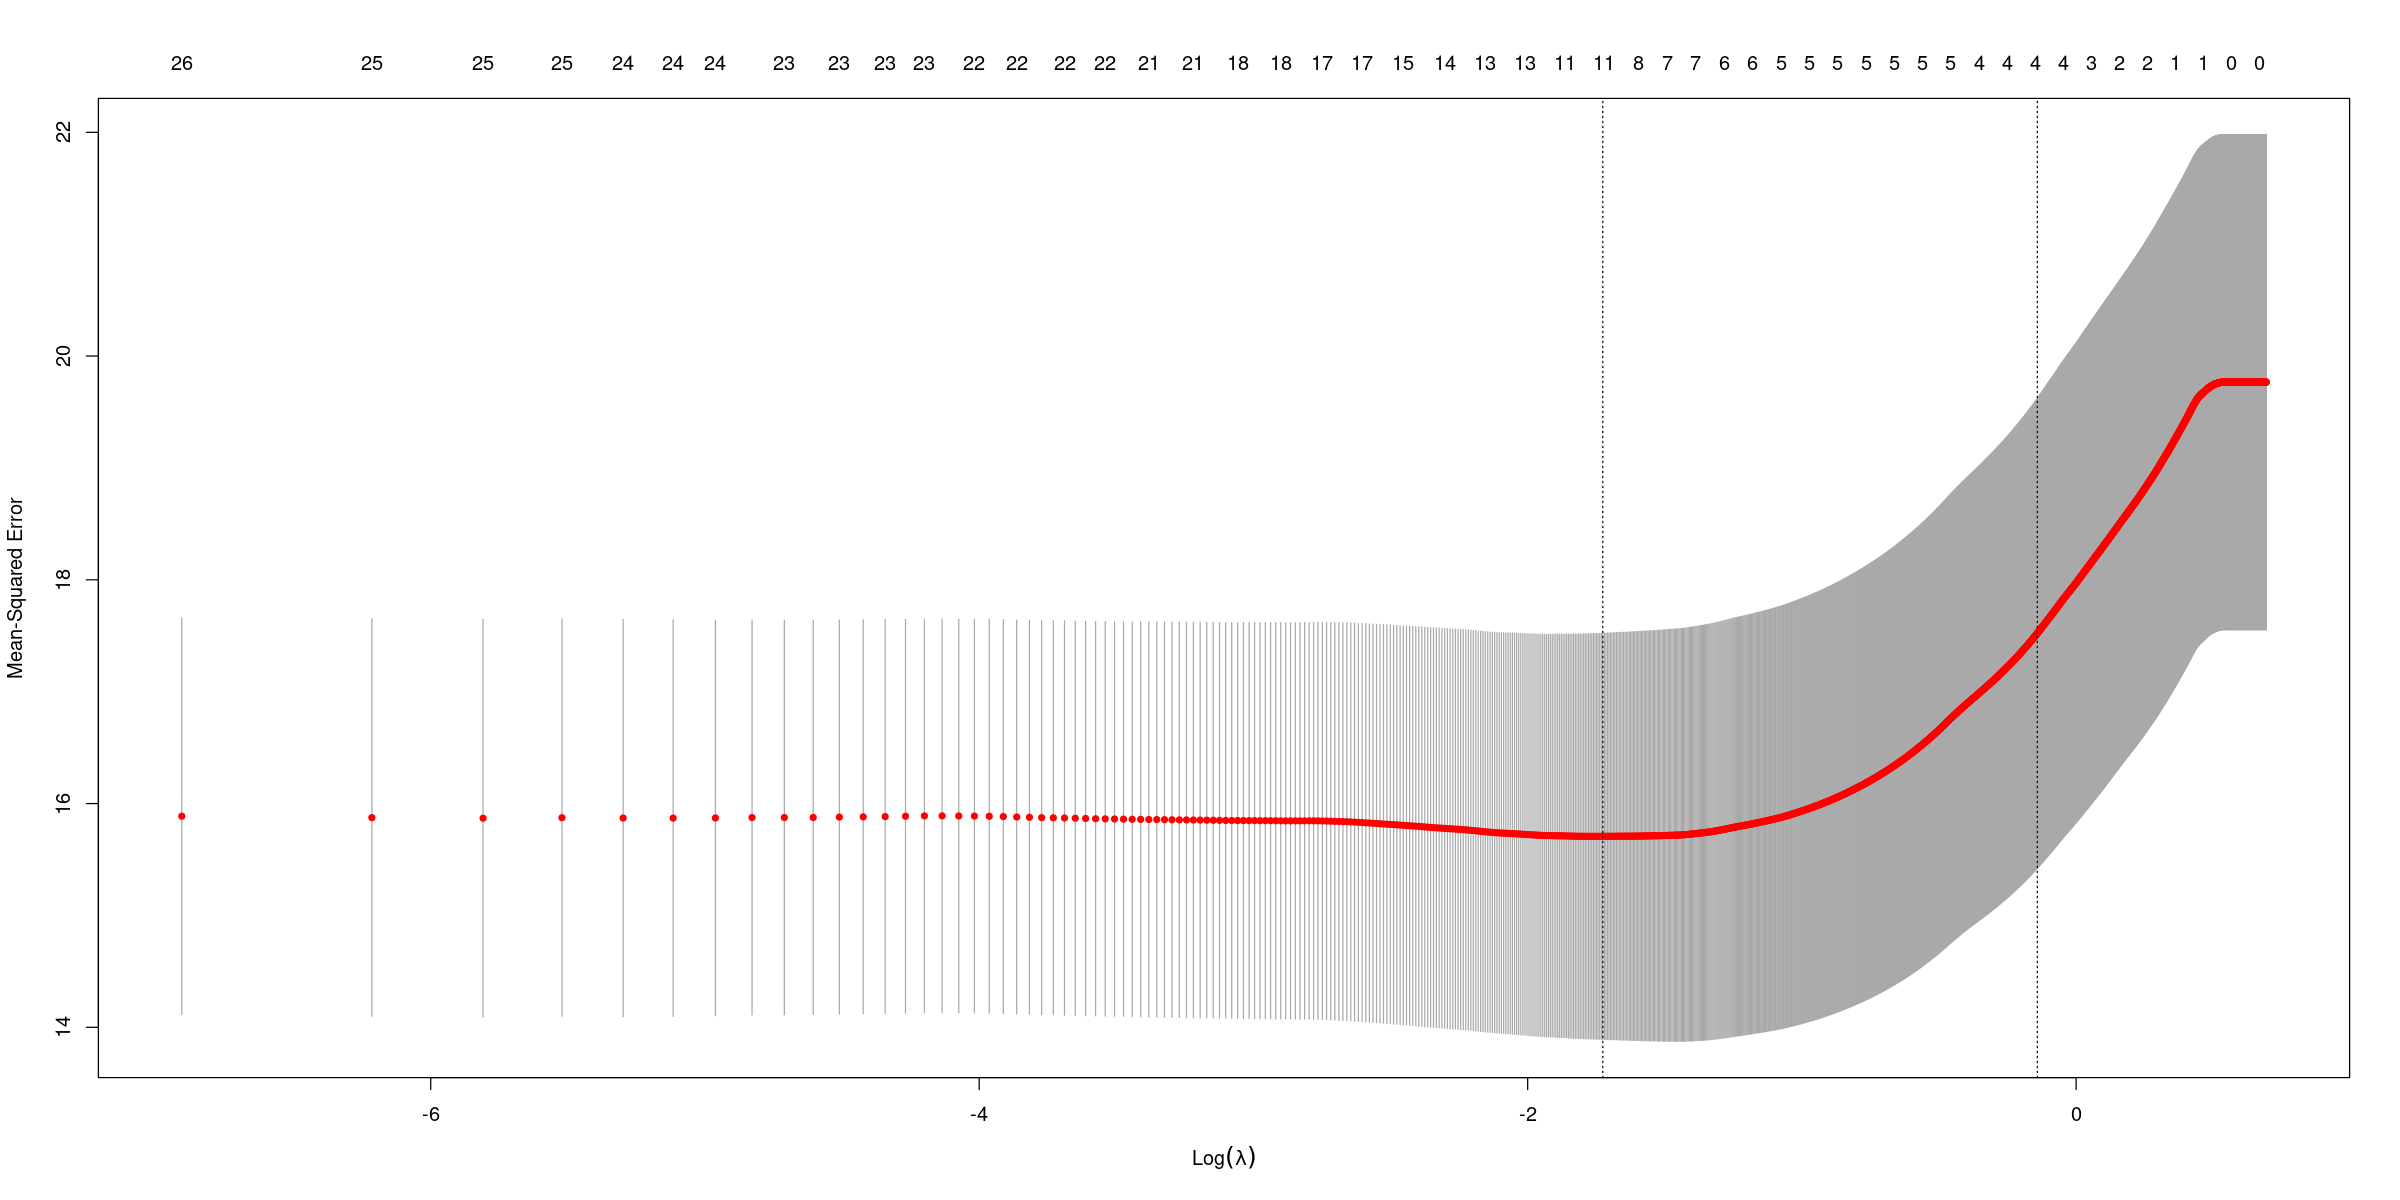

In [79]:
plot(lasso_cv)

In [80]:
plt.lasso = plt.lasso + 
  geom_vline(xintercept = lasso_cv$lambda.min, color = "black", size=.8) +
  geom_text(aes(x=lasso_cv$lambda.min, label="\nlambda.min", y=20), colour="black", angle=90, text=element_text(size=11)) +
  geom_vline(xintercept = lasso_cv$lambda.1se, color = "red", size=.8) +
  geom_text(aes(x=lasso_cv$lambda.1se, label="\nlambda.1se", y=20), colour="red", angle=90, text=element_text(size=11)) +
  xlim(c(0,lasso_cv$lambda.1se+0.5))
# ggplotly(plt.lasso)

Warning message:
“Ignoring unknown parameters: text”
Warning message:
“Ignoring unknown parameters: text”


#### Get the best Lasso model from cross-validation

In [81]:
best.lasso.reg = glmnet(x = x_train, y = y_train, alpha = 0, standardize = TRUE)

lasso.lamb.min = lasso_cv$lambda.min
lasso.lamb.1se = lasso_cv$lambda.1se

coef.lasso.min <- coef(best.lasso.reg, s = lasso.lamb.min, exact = TRUE, x = x_train, y = y_train)
coef.lasso.1se <- coef(best.lasso.reg, s = lasso.lamb.1se, exact = TRUE, x = x_train, y = y_train)



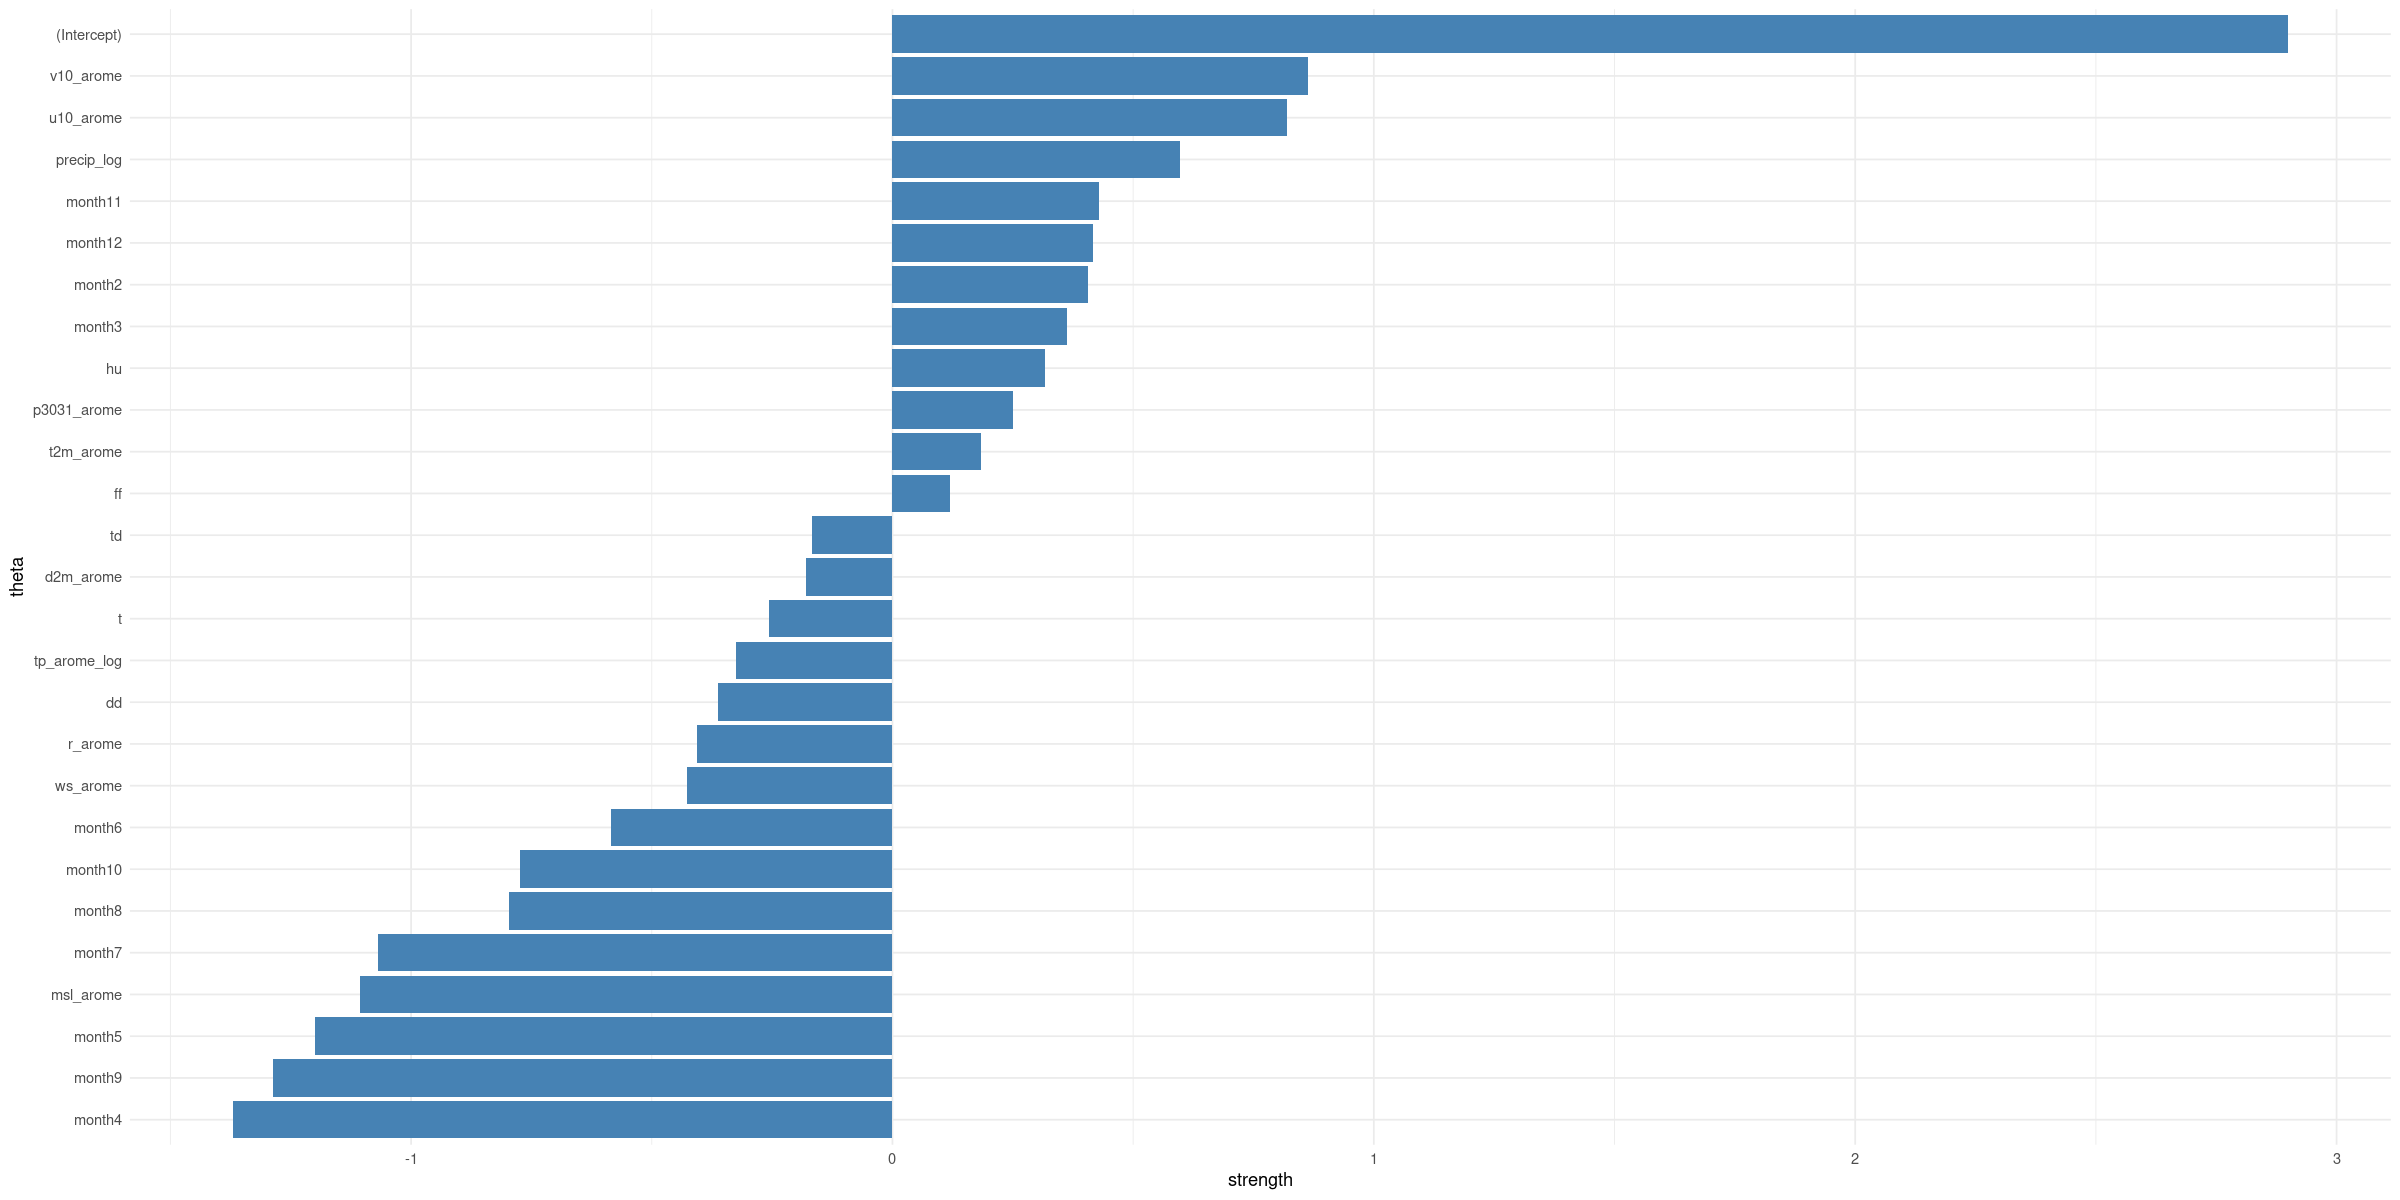

In [82]:
param_plot(coef.lasso.min)

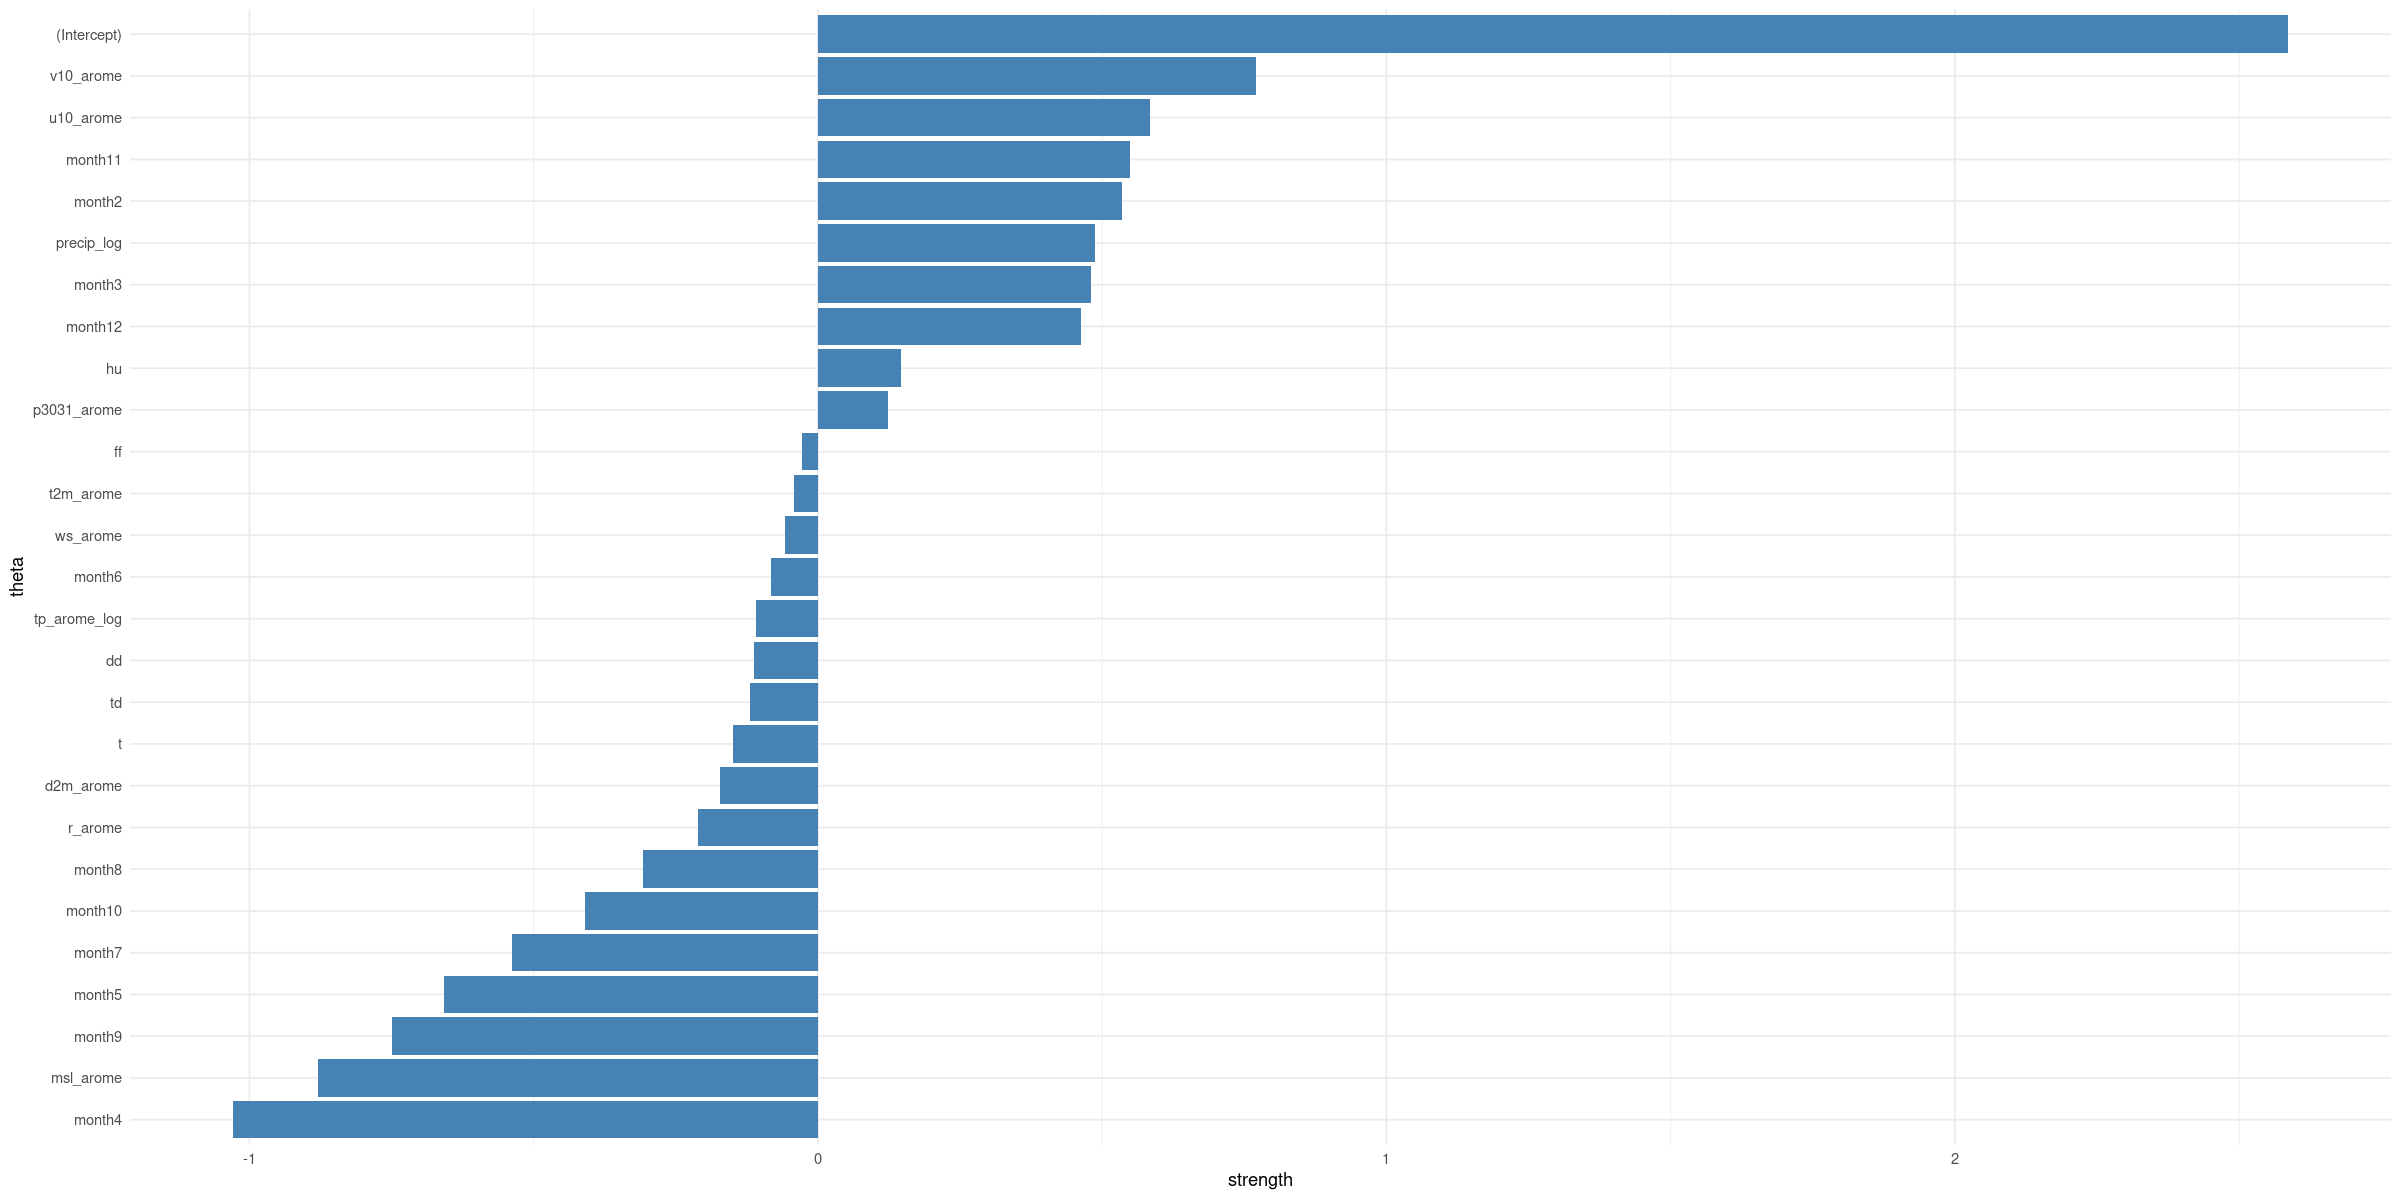

In [83]:
param_plot(coef.lasso.1se)

#### Performance of LASSO Regression

In [84]:
y_predict_train_min = predict(best.lasso.reg, newx = x_train, type = 'response' , s = lasso.lamb.min)
y_predict_test_min = predict(best.lasso.reg, newx = x_test, type = 'response' , s = lasso.lamb.min)

y_predict_train_1se = predict(best.lasso.reg, newx = x_train, type = 'response' , s = lasso.lamb.1se)
y_predict_test_1se = predict(best.lasso.reg, newx = x_test, type = 'response' , s = lasso.lamb.1se)

In [85]:
pred_class = to_class(y_predict_train_min, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_train_1se, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_test_min, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

pred_class = to_class(y_predict_test_1se, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       123      107      52
  low_rain         32       92      82
  no_rain           0       35      27
[1] "Prediction accuracy :  0.44"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       127      107      50
  low_rain         28       95      93
  no_rain           0       32      18
[1] "Prediction accuracy :  0.436363636363636"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        29       28      20
  low_rain          2       27      21
  no_rain           2        3       6
[1] "Prediction accuracy :  0.449275362318841"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        30       27      19
  low_rain          1       30      25
  no_rain           2        1       3
[1] "Prediction accuracy :  0.456521739130435"


In [86]:
print('TRAINING ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_train_min, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_min, y_train)))

[1] "TRAINING ERROR MIN"
[1] "Mean Square Error :  14.6293041417416"
[1] "MAPE :  Inf"


In [87]:
print('TRAINING ERROR ')
print(paste('Mean Square Error : ', MSE(y_predict_train_1se, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_1se, y_train)))

[1] "TRAINING ERROR "
[1] "Mean Square Error :  14.8299020421406"
[1] "MAPE :  Inf"


In [88]:
print('TEST ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_test_min, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_min, y_test)))

[1] "TEST ERROR MIN"
[1] "Mean Square Error :  20.7305547034728"
[1] "MAPE :  Inf"


In [89]:
print('TEST ERROR 1SE')
print(paste('Mean Square Error : ', MSE(y_predict_test_1se, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_1se, y_test)))

[1] "TEST ERROR 1SE"
[1] "Mean Square Error :  20.5656087857771"
[1] "MAPE :  Inf"


### 2.3. Elastic-Net Regression

Elastic-Net regression combines the advantages of ridge regression and Lasso regression

    Firstly we will fit a Elastic-Net with `alpha = 0.5`

In [90]:
lambda_seq = seq(0, 2, by = 0.001)
reg.elas.net <- glmnet(x = x_train, y = y_train, alpha = .5, lambda=lambda_seq, standardize=TRUE)
summary(reg.elas.net)

          Length Class     Mode   
a0         2001  -none-    numeric
beta      52026  dgCMatrix S4     
df         2001  -none-    numeric
dim           2  -none-    numeric
lambda     2001  -none-    numeric
dev.ratio  2001  -none-    numeric
nulldev       1  -none-    numeric
npasses       1  -none-    numeric
jerr          1  -none-    numeric
offset        1  -none-    logical
call          6  -none-    call   
nobs          1  -none-    numeric

In [91]:
plt.net = regularisation_path(reg.elas.net)
# ggplotly(plt.net)

In [92]:
net_cv <- cv.glmnet(x = x_train, y = y_train, alpha=.5, lambda = lambda_seq, standardize=TRUE)
net_cv$lambda.min
net_cv$lambda.1se

[1] 0.272

[1] 2

In [93]:
plt.net = plt.net + 
  geom_vline(xintercept = net_cv$lambda.min, color = "black", size=.8) +
  geom_text(aes(x=net_cv$lambda.min, label="\nlambda.min", y=20), colour="black", angle=90, text=element_text(size=11)) +
  geom_vline(xintercept = net_cv$lambda.1se, color = "red", size=.8) +
  geom_text(aes(x=net_cv$lambda.1se, label="\nlambda.1se", y=20), colour="red", angle=90, text=element_text(size=11)) +
  xlim(c(0,net_cv$lambda.1se + 0.2))
# ggplotly(plt.net)

Warning message:
“Ignoring unknown parameters: text”
Warning message:
“Ignoring unknown parameters: text”


#### Get the best Elastic-Net model from cross-validation

In [94]:
net.lamb.min = net_cv$lambda.min
net.lamb.1se = net_cv$lambda.1se

best.elas.net = glmnet(x = x_train, y = y_train, alpha = 0.5, standardize = TRUE)

coef.net.min <- coef(best.elas.net, s = net.lamb.min, exact = TRUE, x = x_train, y = y_train)
coef.net.1se <- coef(best.elas.net, s = net.lamb.1se, exact = TRUE, x = x_train, y = y_train)


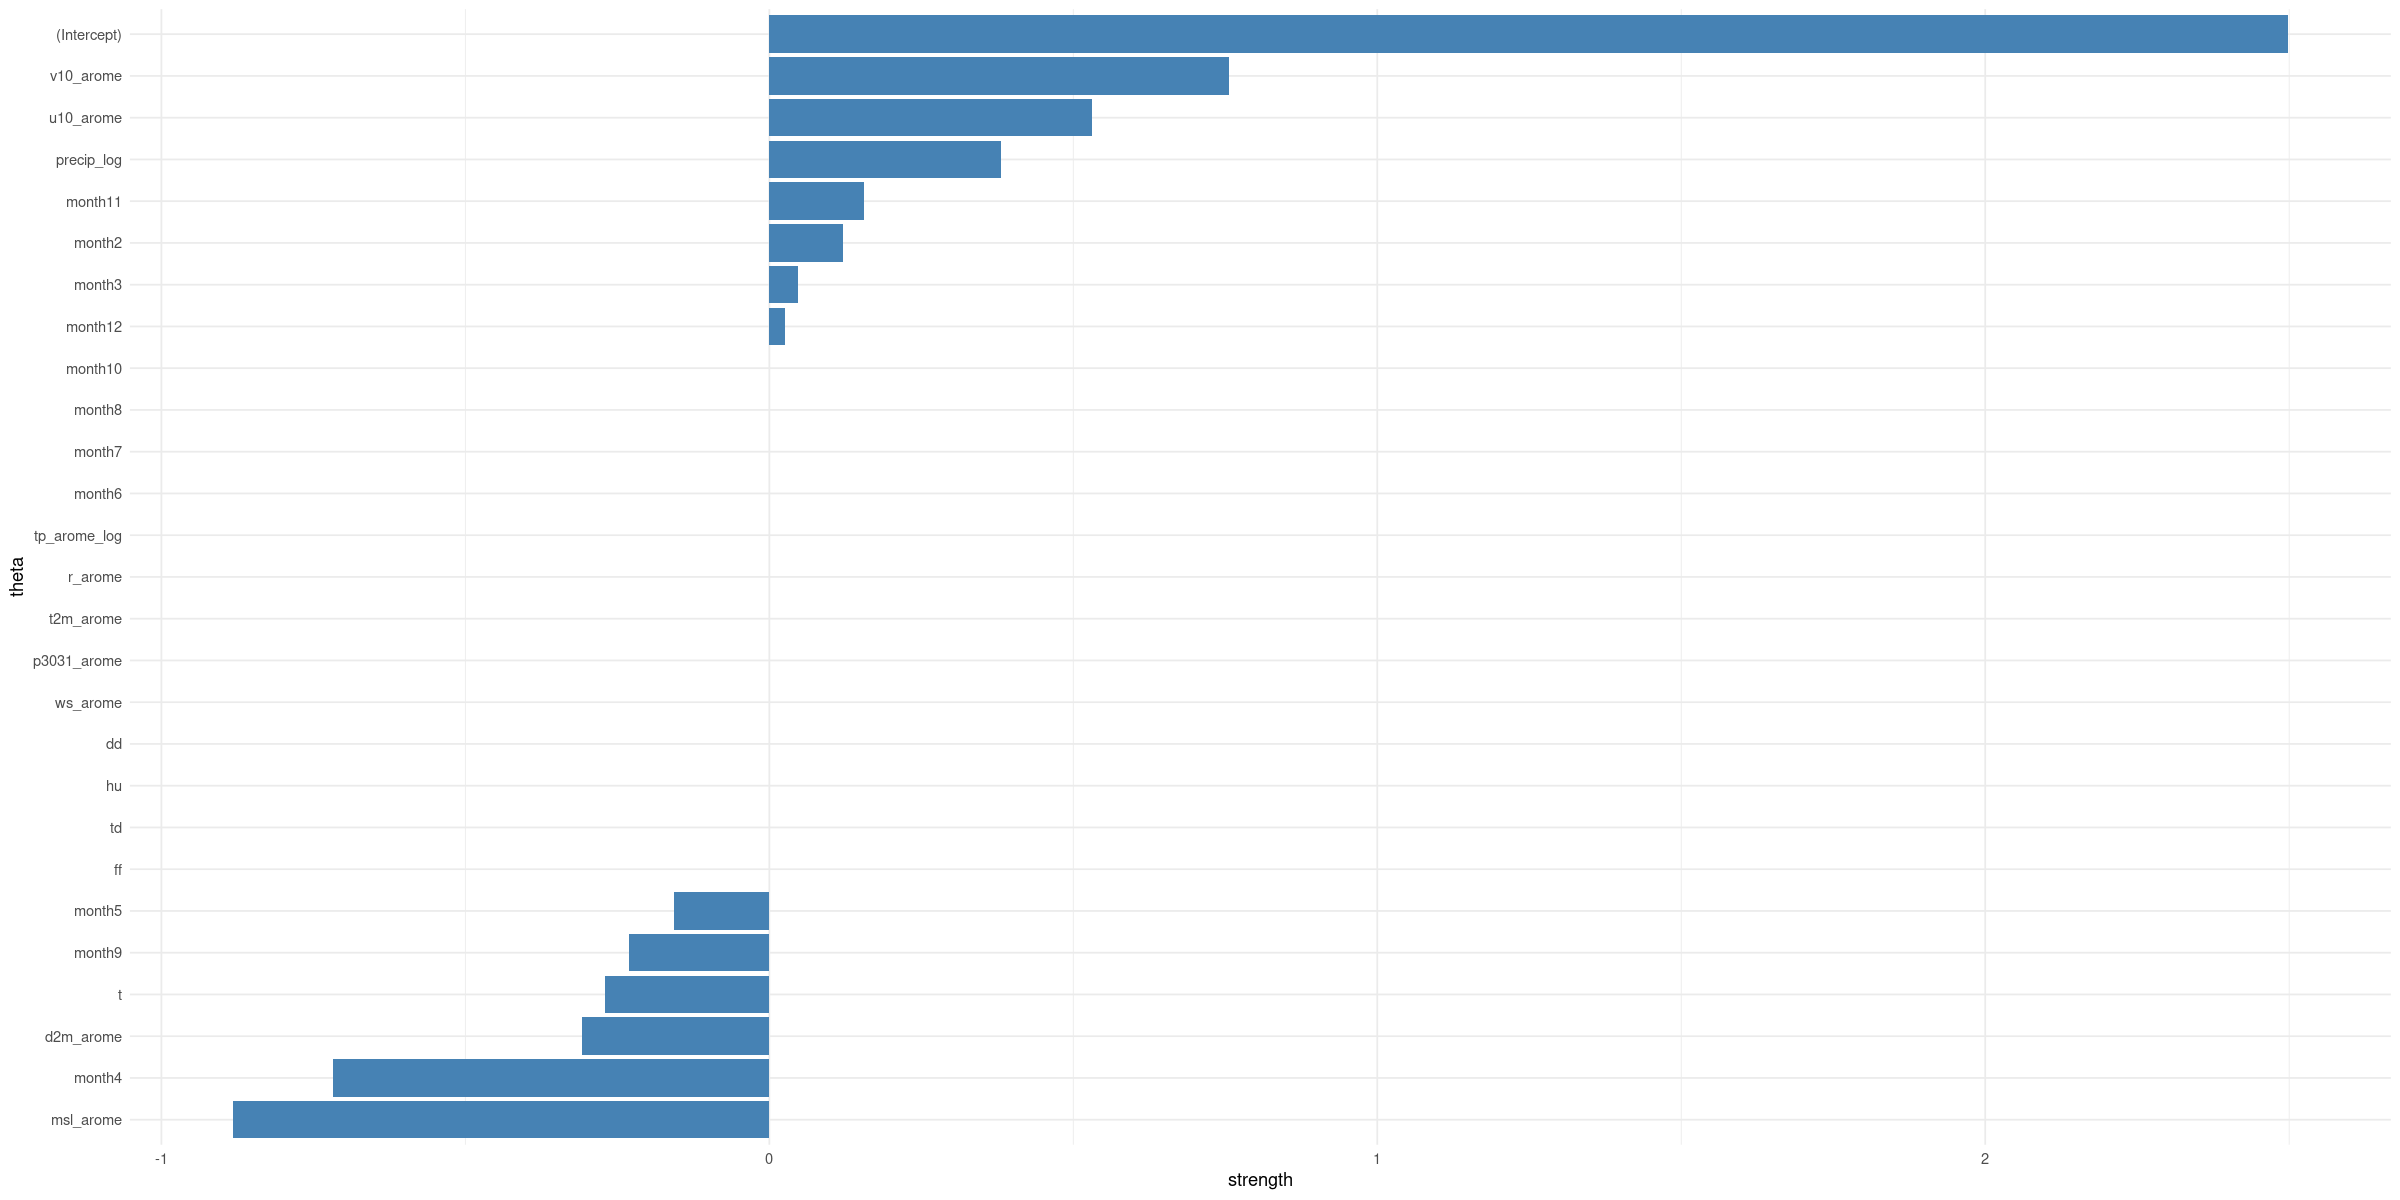

In [95]:
param_plot(coef.net.min)

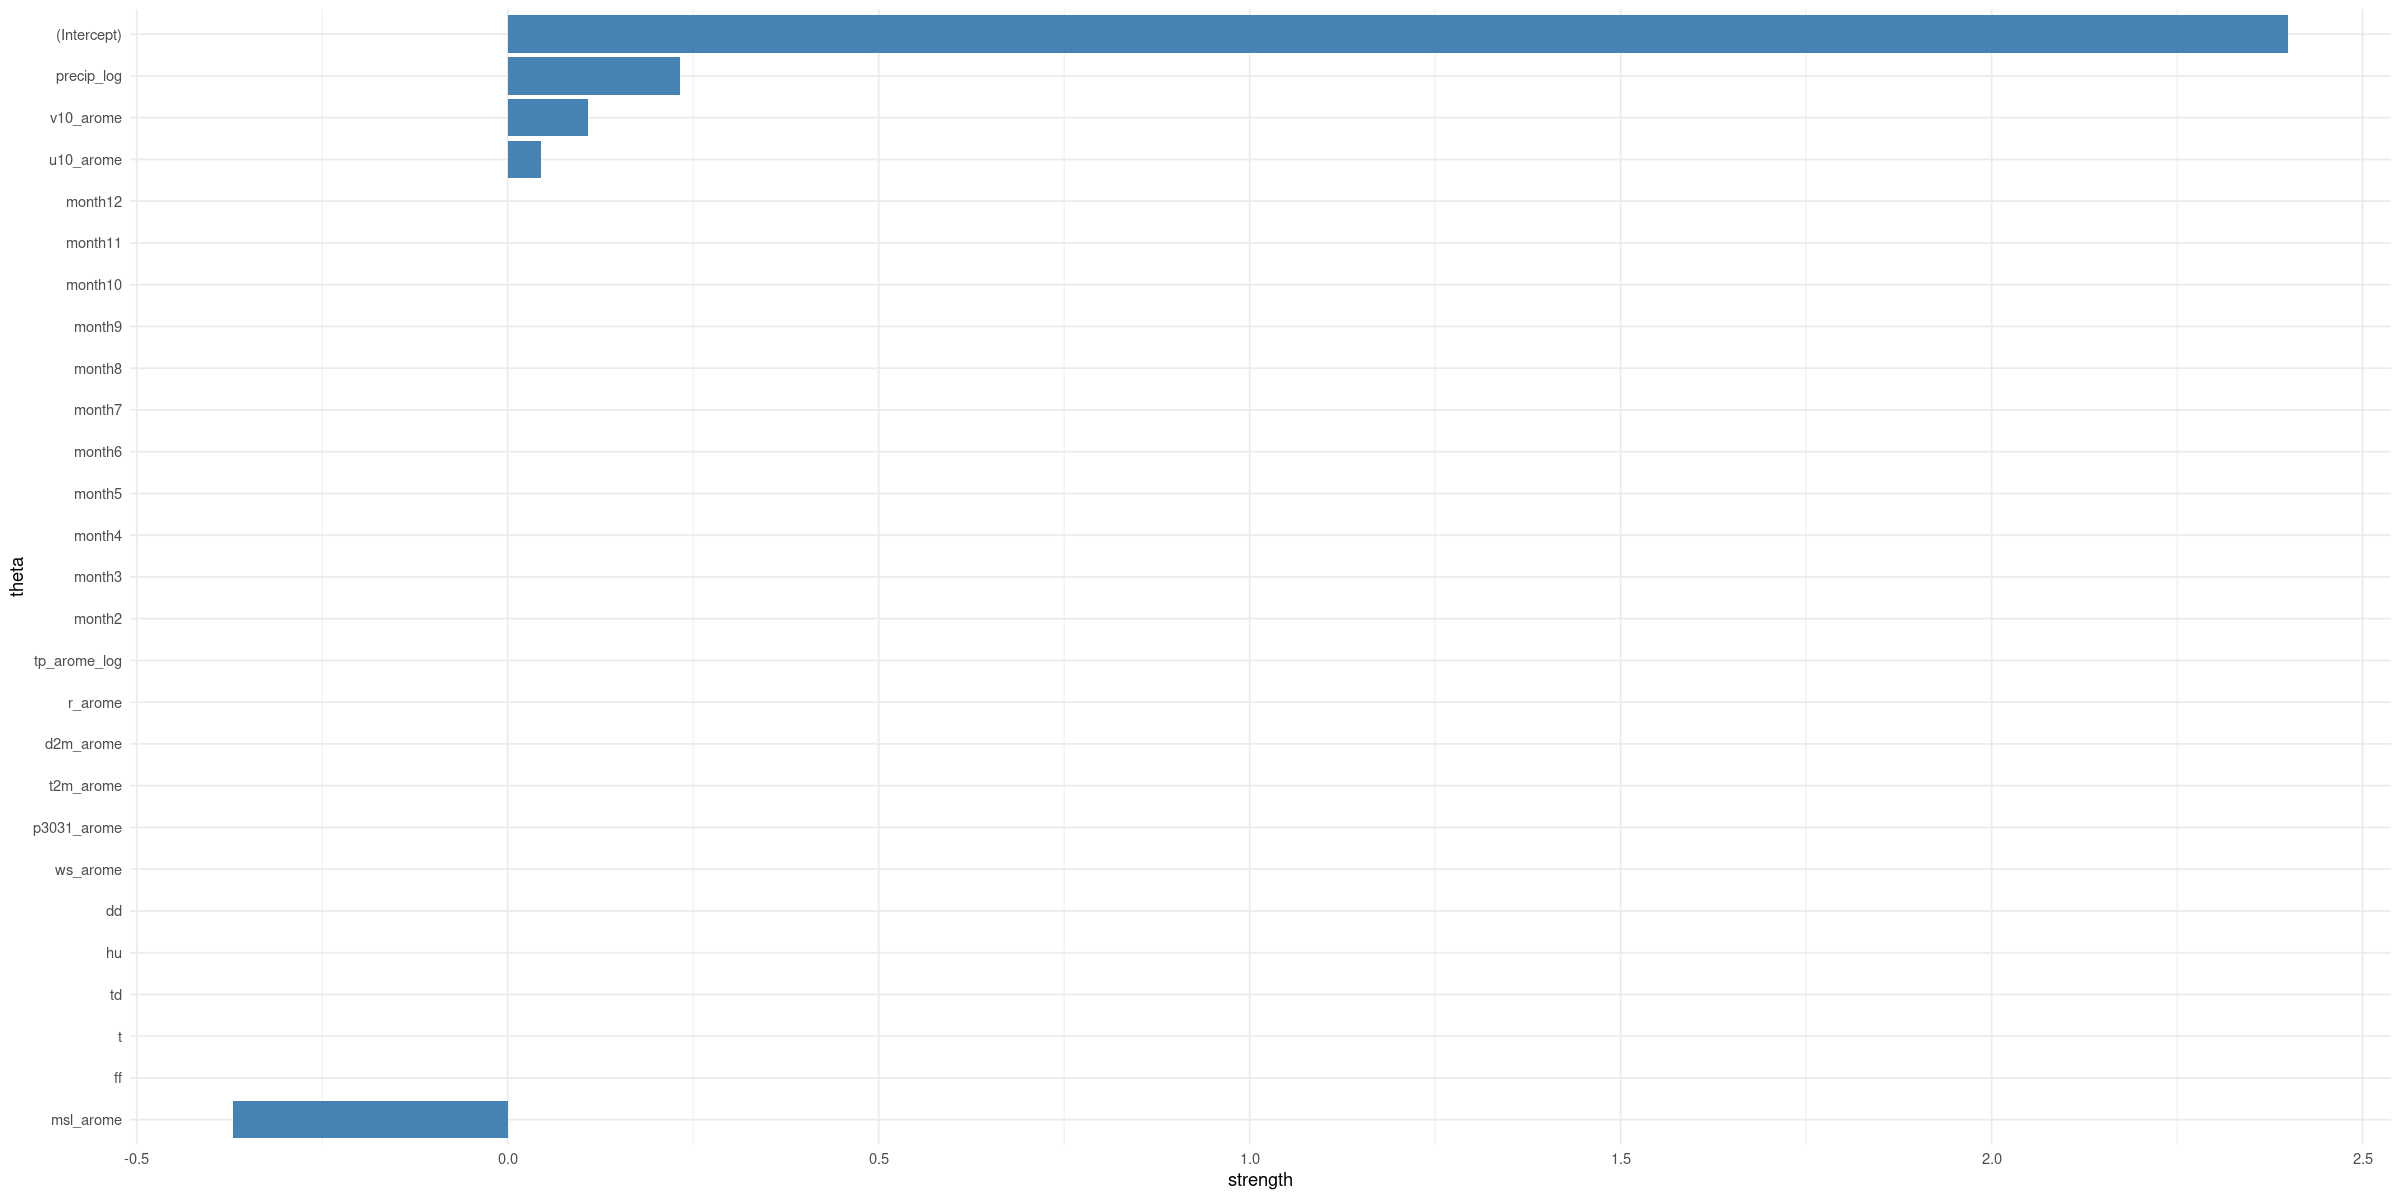

In [96]:
param_plot(coef.net.1se)

#### Performance of Elastic-Net Regression

In [97]:
y_predict_train_min = predict(best.elas.net, newx = x_train, type = 'response' , s = net.lamb.min)
y_predict_test_min = predict(best.elas.net, newx = x_test, type = 'response' , s = net.lamb.min)

y_predict_train_1se = predict(best.elas.net, newx = x_train, type = 'response' , s = net.lamb.1se)
y_predict_test_1se = predict(best.elas.net, newx = x_test, type = 'response' , s = net.lamb.1se)

In [98]:
pred_class = to_class(y_predict_train_min, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_train_1se, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_test_min, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

pred_class = to_class(y_predict_test_1se, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       130      106      49
  low_rain         25      104      98
  no_rain           0       24      14
[1] "Prediction accuracy :  0.450909090909091"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       148      156      97
  low_rain          7       78      64
[1] "Prediction accuracy :  0.410909090909091"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        29       27      19
  low_rain          3       31      25
  no_rain           1        0       3
[1] "Prediction accuracy :  0.456521739130435"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        32       38      31
  low_rain          1       20      16
[1] "Prediction accuracy :  0.376811594202899"


In [99]:
print('TRAINING ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_train_min, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_min, y_train)))

[1] "TRAINING ERROR MIN"
[1] "Mean Square Error :  15.0752598956148"
[1] "MAPE :  Inf"


In [100]:
print('TRAINING ERROR 1SE')
print(paste('Mean Square Error : ', MSE(y_predict_train_1se, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_1se, y_train)))

[1] "TRAINING ERROR 1SE"
[1] "Mean Square Error :  17.83154001858"
[1] "MAPE :  Inf"


In [101]:
print('TEST ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_test_min, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_min, y_test)))

[1] "TEST ERROR MIN"
[1] "Mean Square Error :  20.180947630593"
[1] "MAPE :  Inf"


In [102]:
print('TEST ERROR 1SE')
print(paste('Mean Square Error : ', MSE(y_predict_test_1se, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_1se, y_test)))

[1] "TEST ERROR 1SE"
[1] "Mean Square Error :  23.129828074357"
[1] "MAPE :  Inf"


    Even the training MSE using 1se coef is greater, but the MAPE is smaller in both train set and test set

### Comparison of Rigde, Lasso and Elastic Net

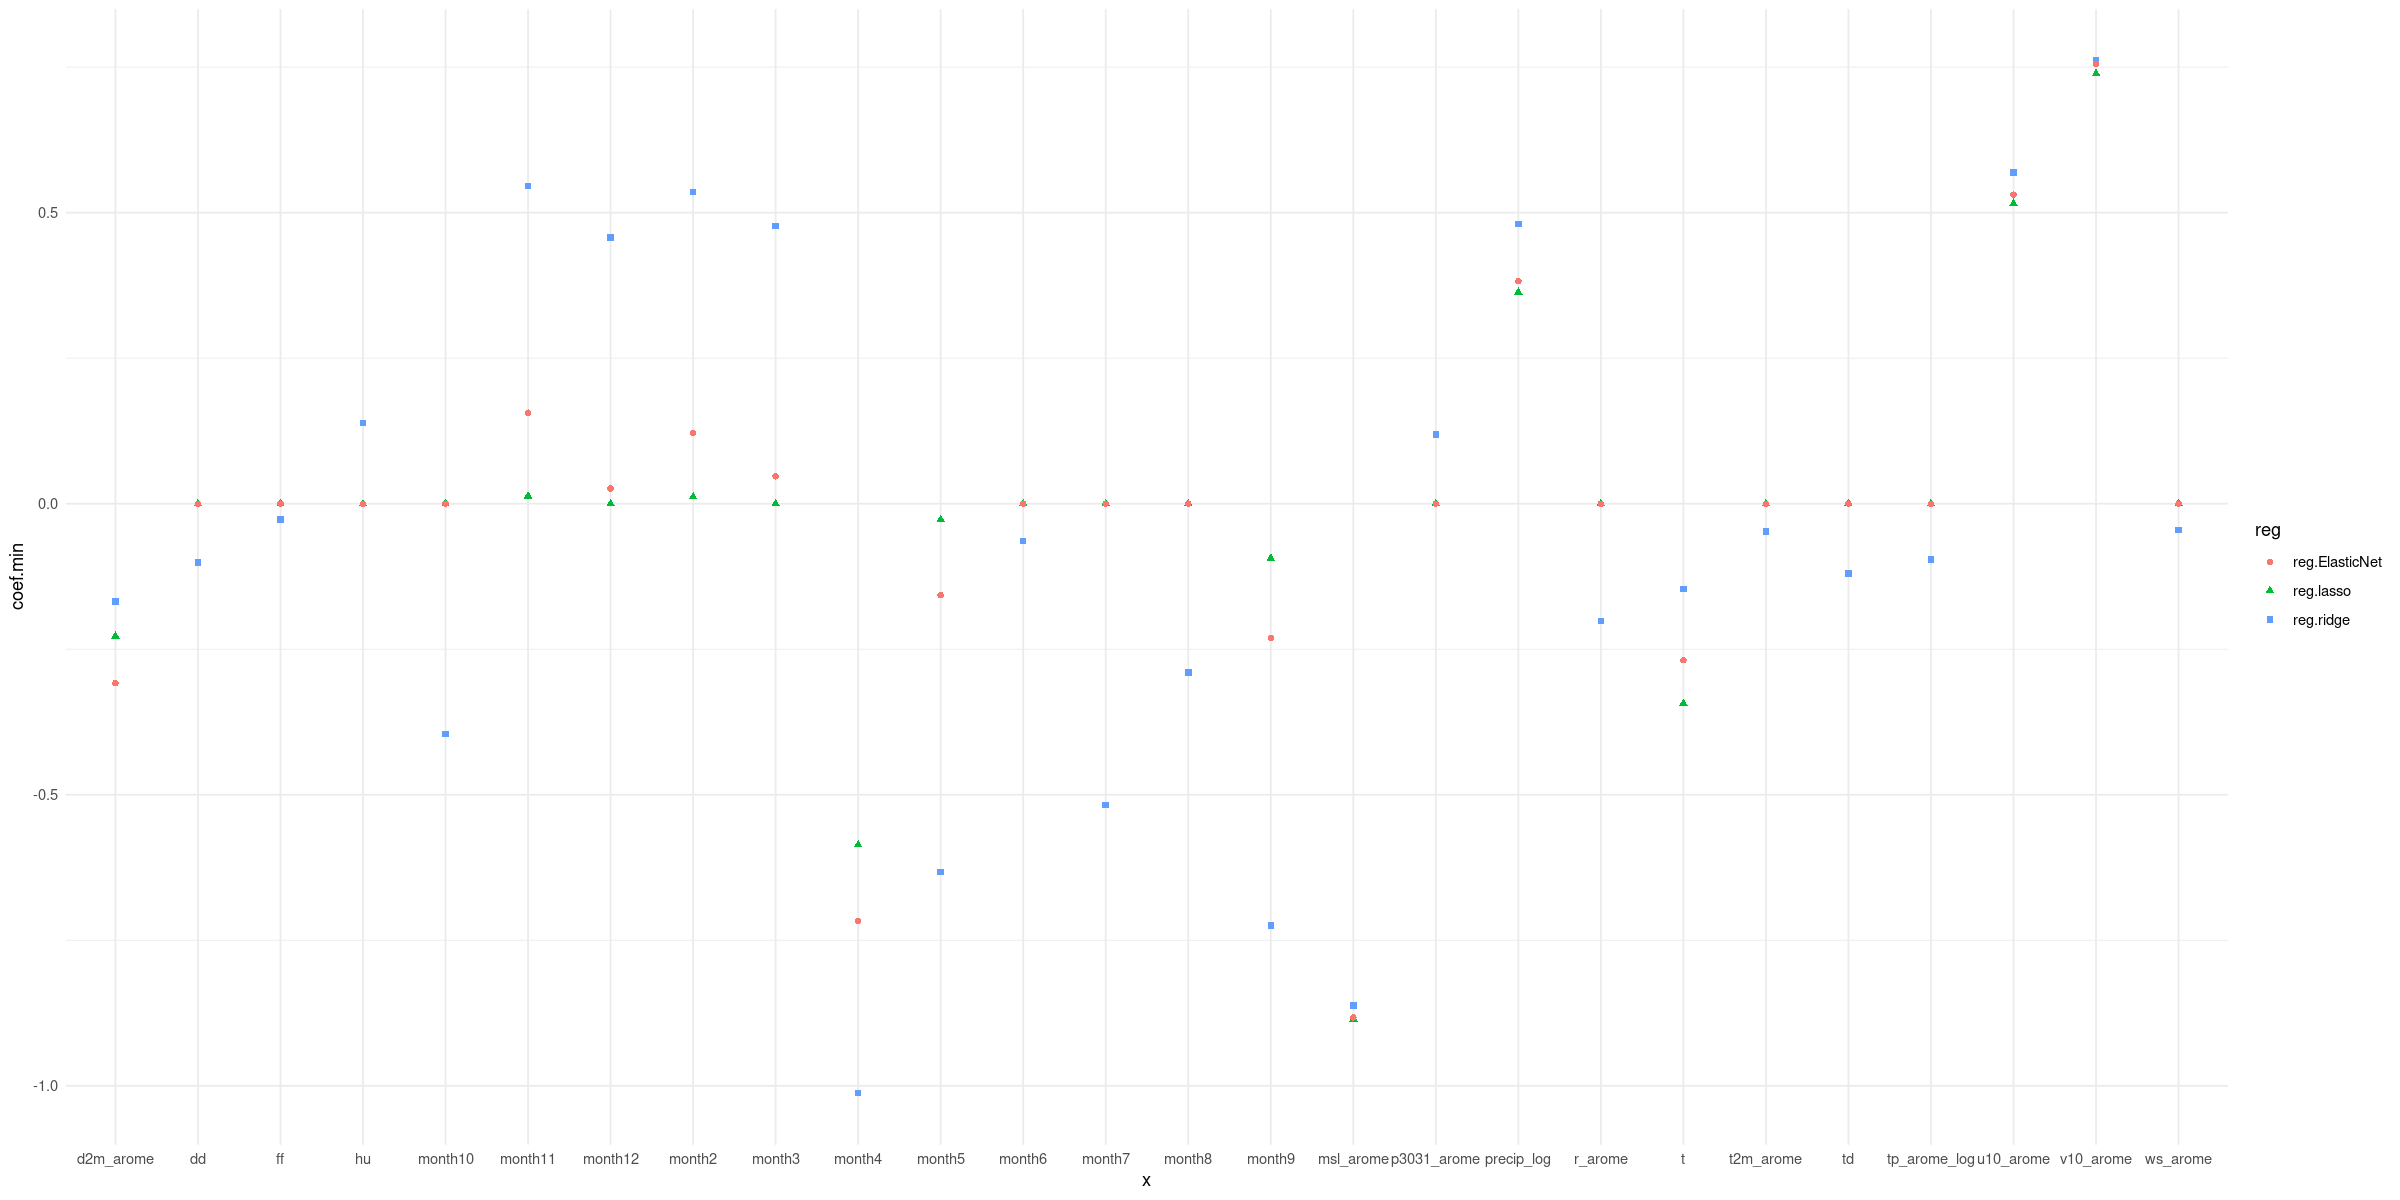

In [103]:
nc = ncol(x_train)
df = data.frame(
  x = rep(exp_var,3),
  coef.min = c(as.vector(coef(ridge_cv, s = ridge_cv$lambda.min)[-1]),
         as.vector(coef(lasso_cv, s = lasso_cv$lambda.min)[-1]),
         as.vector(coef(net_cv, s = net_cv$lambda.min)[-1])),
  reg = c(rep("reg.ridge", nc),
        rep("reg.lasso", nc),
        rep("reg.ElasticNet", nc))
  )

ggplot(df)+
  geom_point(aes(x = x, y = coef.min, col = reg, shape = reg))+
  theme_minimal()

## 3. Poisson Regression

Since the distribution of the `rain` reponse is very similar to a Poisson distribution, so we'll try to fit it with a poisson regression in this section 

### 3.1. Simple Poisson regression

In [104]:
options(warn=-1)

In [105]:
exp_var = setdiff(names(train_set), c('rain', 'rain_log', 'rain_class'))

In [106]:
poisson.reg = glm(rain ~ . , family = "poisson", data = train_set[, c(exp_var, "rain")])
summary(poisson.reg)


Call:
glm(formula = rain ~ ., family = "poisson", data = train_set[, 
    c(exp_var, "rain")])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0061  -1.4994  -0.8723   0.1147   8.1080  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.77965    0.11567   6.740 1.58e-11 ***
ff            0.31883    0.11613   2.745 0.006043 ** 
t            -6.26862    1.44319  -4.344 1.40e-05 ***
td            4.47207    1.38604   3.227 0.001253 ** 
hu           -1.67794    0.48062  -3.491 0.000481 ***
dd           -0.56597    0.14659  -3.861 0.000113 ***
precip_log    0.20108    0.05288   3.803 0.000143 ***
ws_arome     -0.69972    0.12970  -5.395 6.86e-08 ***
p3031_arome   0.72289    0.15082   4.793 1.64e-06 ***
u10_arome     0.39071    0.06438   6.068 1.29e-09 ***
v10_arome     0.59110    0.04485  13.181  < 2e-16 ***
t2m_arome     7.48030    1.34330   5.569 2.57e-08 ***
d2m_arome    -5.68139    1.25195  -4.538 5.68e-06 ***
r_arome       1.892

#### Trainint error and Test error

In [107]:
print('TRAING ERROR')
print(paste('Mean Square Error : ', MSE(poisson.reg$fitted.values, y_train)))
print(paste('MAPE : ', MAPE(poisson.reg$fitted.values, y_train)))

[1] "TRAING ERROR"
[1] "Mean Square Error :  13.9332687615474"
[1] "MAPE :  Inf"


In [108]:
y_predict = predict(poisson.reg, newdata = test_set)

print('TEST ERROR')
print(paste('Mean Square Error : ', MSE(y_predict, y_test)))
print(paste('MAPE : ', MAPE(y_predict, y_test)))

pred_class = to_class(y_predict, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "TEST ERROR"
[1] "Mean Square Error :  26.5721594583517"
[1] "MAPE :  Inf"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain         9        3       0
  low_rain         22       38      25
  no_rain           2       17      22
[1] "Prediction accuracy :  0.5"


### 3.2. Poisson regression with $l_1$ regularisation

In [109]:
lambda_seq = seq(0, 3, by = 0.001)
poisson.reg.l1 = cv.glmnet(x = x_train, y = y_train, family = 'poisson', alpha = 1, lambda = lambda_seq, type.measure = 'mse')

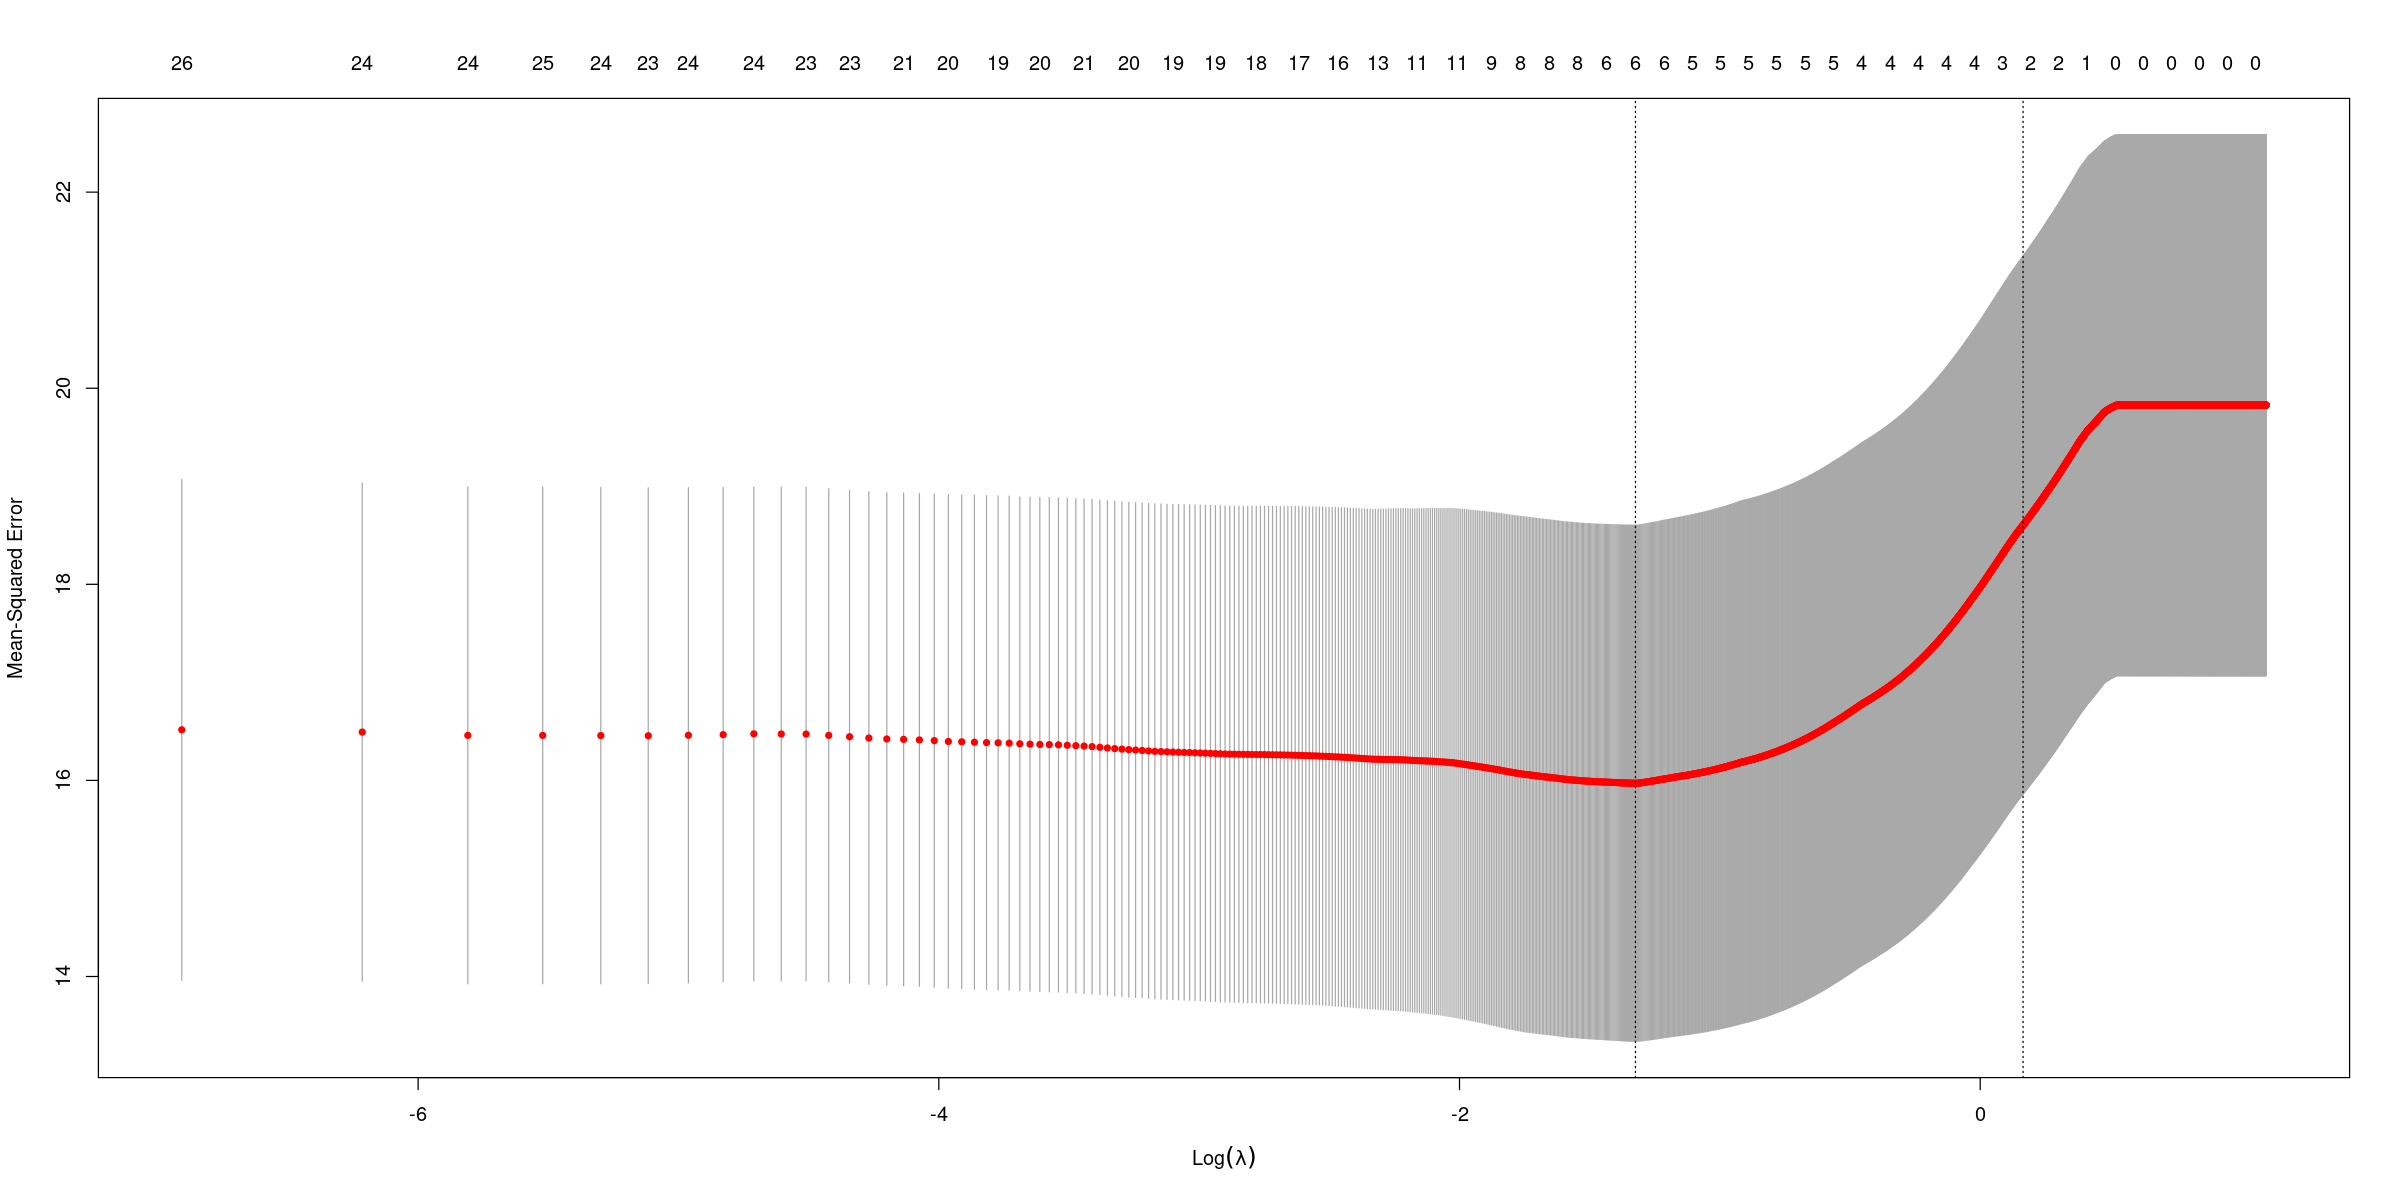

In [110]:
plot(poisson.reg.l1)

In [111]:
poisson.reg.l1$lambda.min
poisson.reg.l1$lambda.1se

[1] 0.266

[1] 1.179

In [112]:
best.poisson.l1 = cv.glmnet(x = x_train, y = y_train, family = 'poisson', alpha = 1, type.measure = 'mse')

poisson.l1.lamb.min = poisson.reg.l1$lambda.min
poisson.l1.lamb.1se = poisson.reg.l1$lambda.1se

coef.poisson.l1.min = coef(best.poisson.l1, s = poisson.l1.lamb.min, exact = TRUE, x = x_train, y = y_train)
coef.poisson.l1.1se = coef(best.poisson.l1, s = poisson.l1.lamb.1se, exact = TRUE, x = x_train, y = y_train)


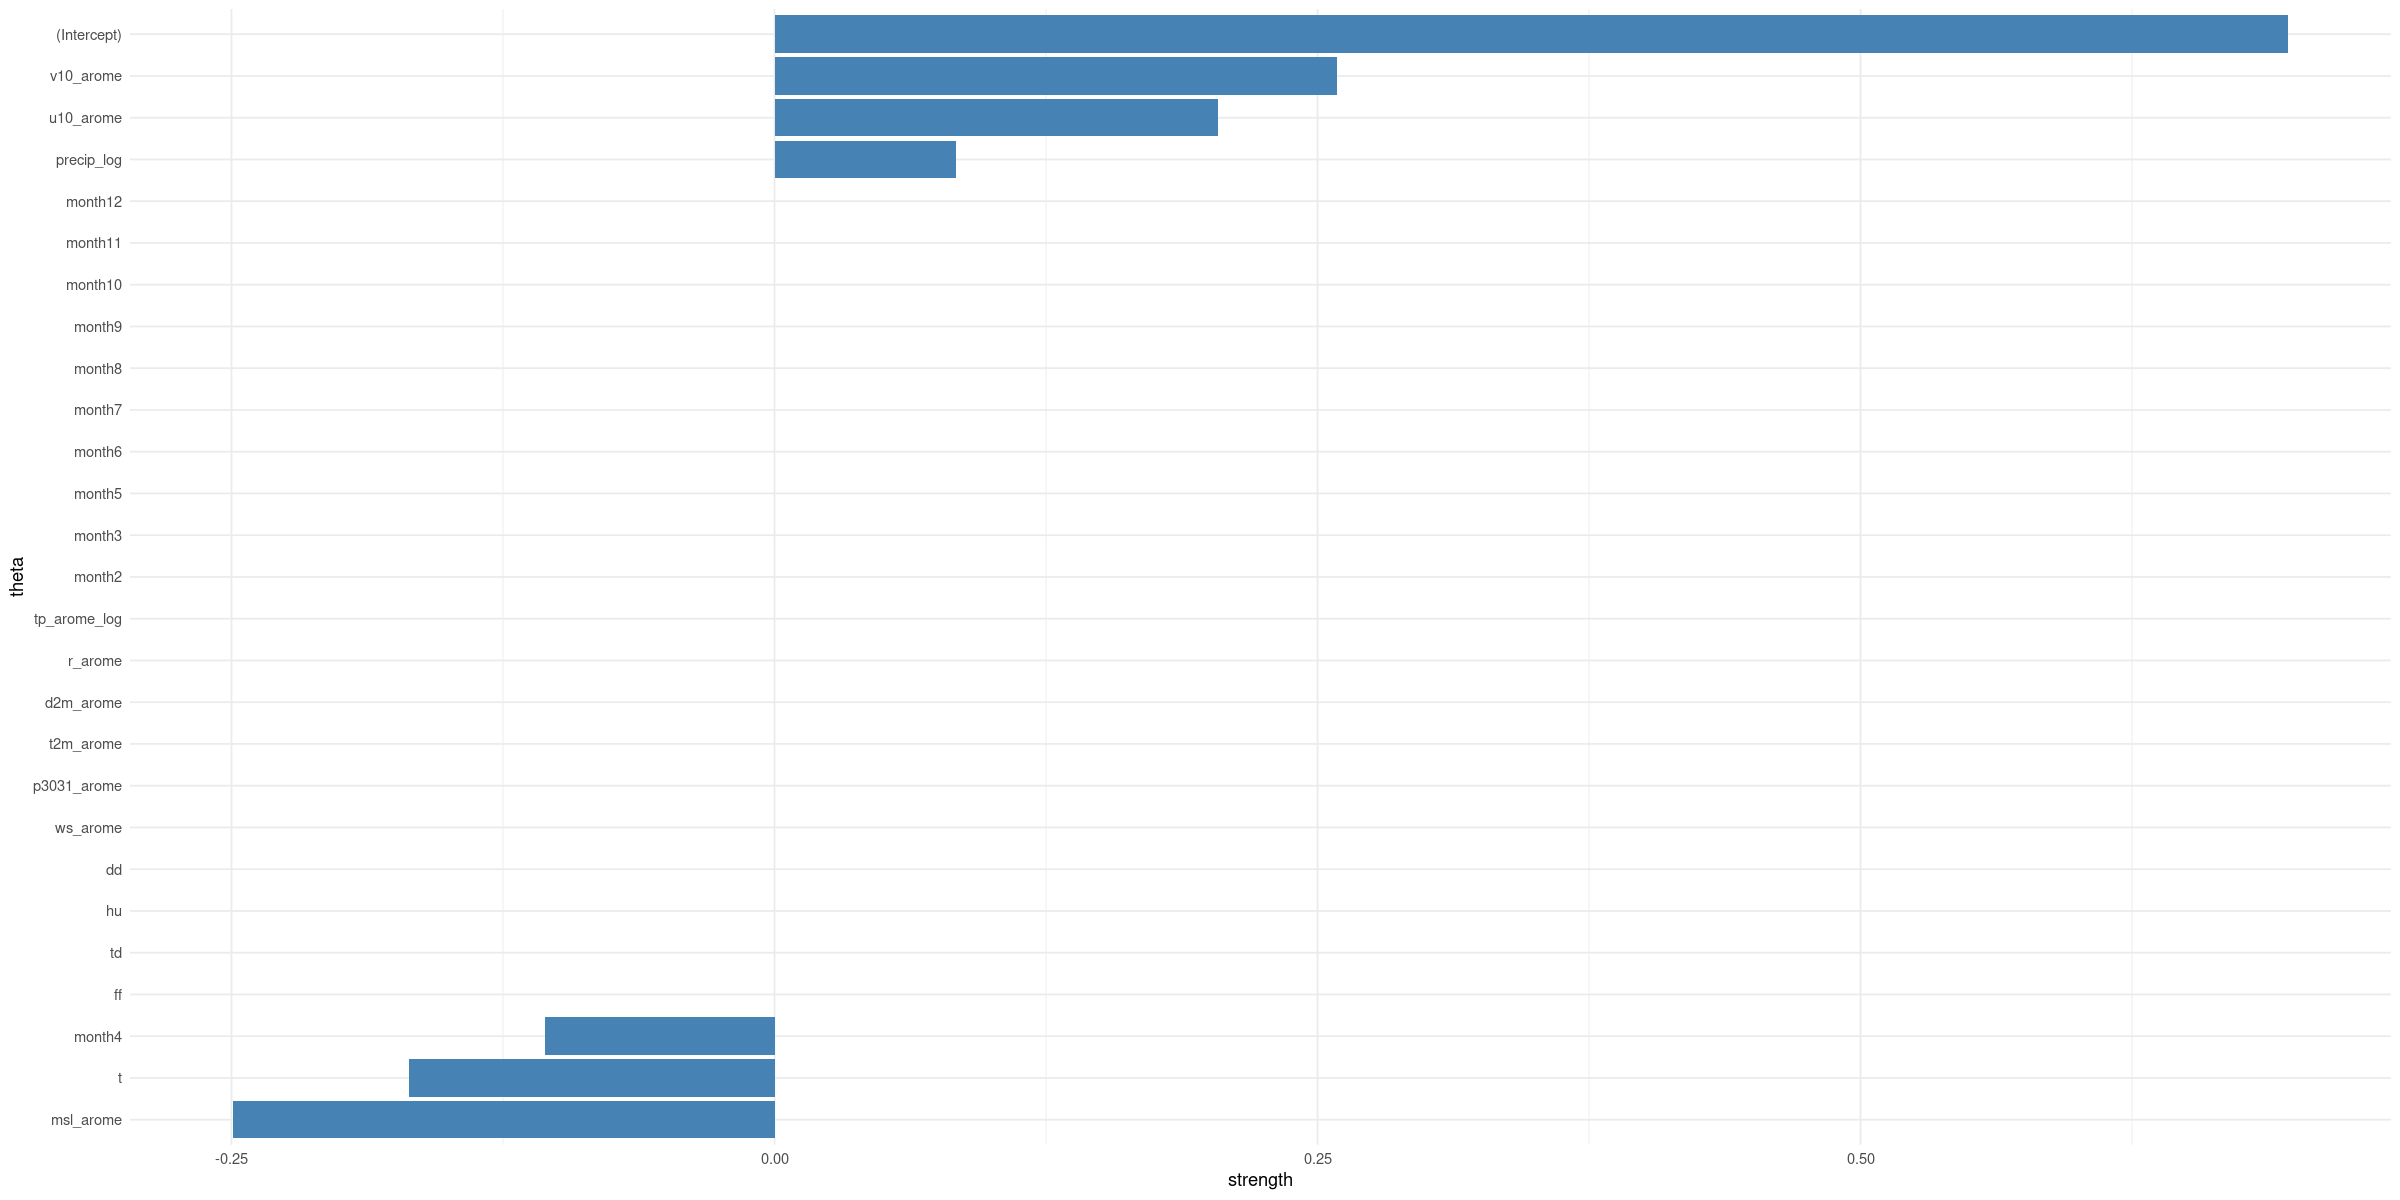

In [113]:
param_plot(coef.poisson.l1.min)

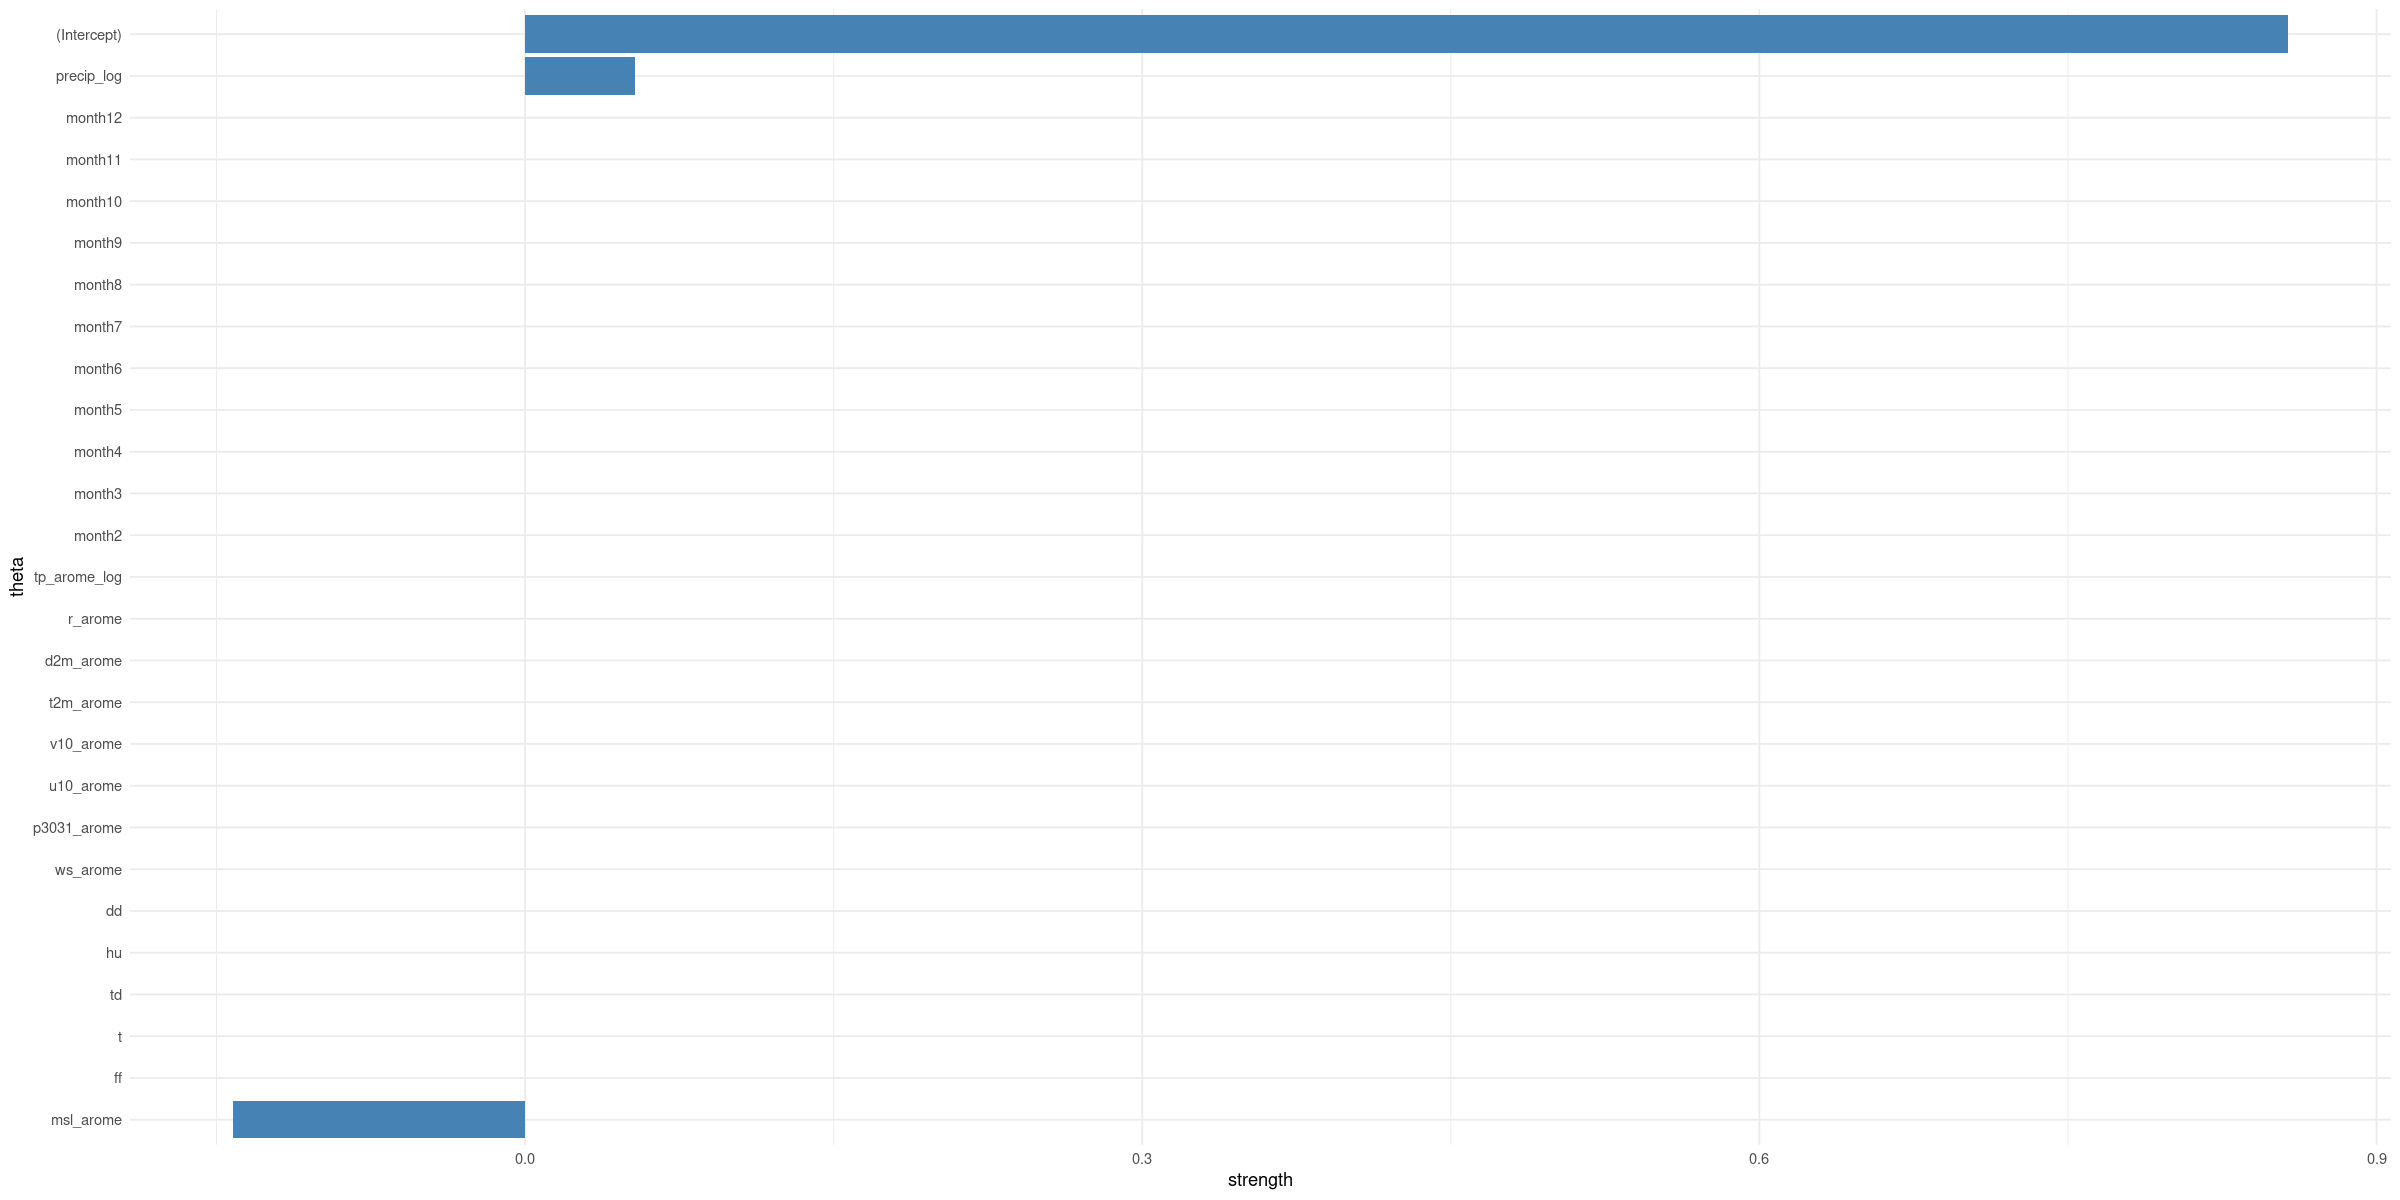

In [114]:
param_plot(coef.poisson.l1.1se)

In [115]:
y_predict_train_min = predict(best.poisson.l1, newx = x_train, type = 'response' , s = poisson.l1.lamb.min)
y_predict_test_min = predict(best.poisson.l1, newx = x_test, type = 'response' , s = poisson.l1.lamb.min)

y_predict_train_1se = predict(best.poisson.l1, newx = x_train, type = 'response' , s = poisson.l1.lamb.1se)
y_predict_test_1se = predict(best.poisson.l1, newx = x_test, type = 'response' , s = poisson.l1.lamb.1se)

In [116]:
print('TRAINING ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_train_min, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_min, y_train)))

print('TRAINING ERROR ')
print(paste('Mean Square Error : ', MSE(y_predict_train_1se, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_1se, y_train)))


print('TEST ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_test_min, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_min, y_test)))

print('TEST ERROR 1SE')
print(paste('Mean Square Error : ', MSE(y_predict_test_1se, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_1se, y_test)))

[1] "TRAINING ERROR MIN"
[1] "Mean Square Error :  15.2699319869971"
[1] "MAPE :  Inf"
[1] "TRAINING ERROR "
[1] "Mean Square Error :  18.3271621229876"
[1] "MAPE :  Inf"
[1] "TEST ERROR MIN"
[1] "Mean Square Error :  17.8994842849175"
[1] "MAPE :  Inf"
[1] "TEST ERROR 1SE"
[1] "Mean Square Error :  23.4191415653849"
[1] "MAPE :  Inf"


In [117]:
pred_class = to_class(y_predict_train_min, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_train_1se, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_test_min, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

pred_class = to_class(y_predict_test_1se, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       117       82      39
  low_rain         38      152     122
[1] "Prediction accuracy :  0.489090909090909"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       150      196     125
  low_rain          5       38      36
[1] "Prediction accuracy :  0.341818181818182"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        27       25      15
  low_rain          6       33      32
[1] "Prediction accuracy :  0.434782608695652"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        32       50      39
  low_rain          1        8       8
[1] "Prediction accuracy :  0.289855072463768"


### 3.3. Poisson regression with $l_2$ regularisation

In [118]:
lambda_seq = seq(0, 3, by = 0.001)
poisson.reg.l2 = cv.glmnet(x = x_train, y = y_train, family = 'poisson', alpha = 0, lambda = lambda_seq, type.measure = 'mae')

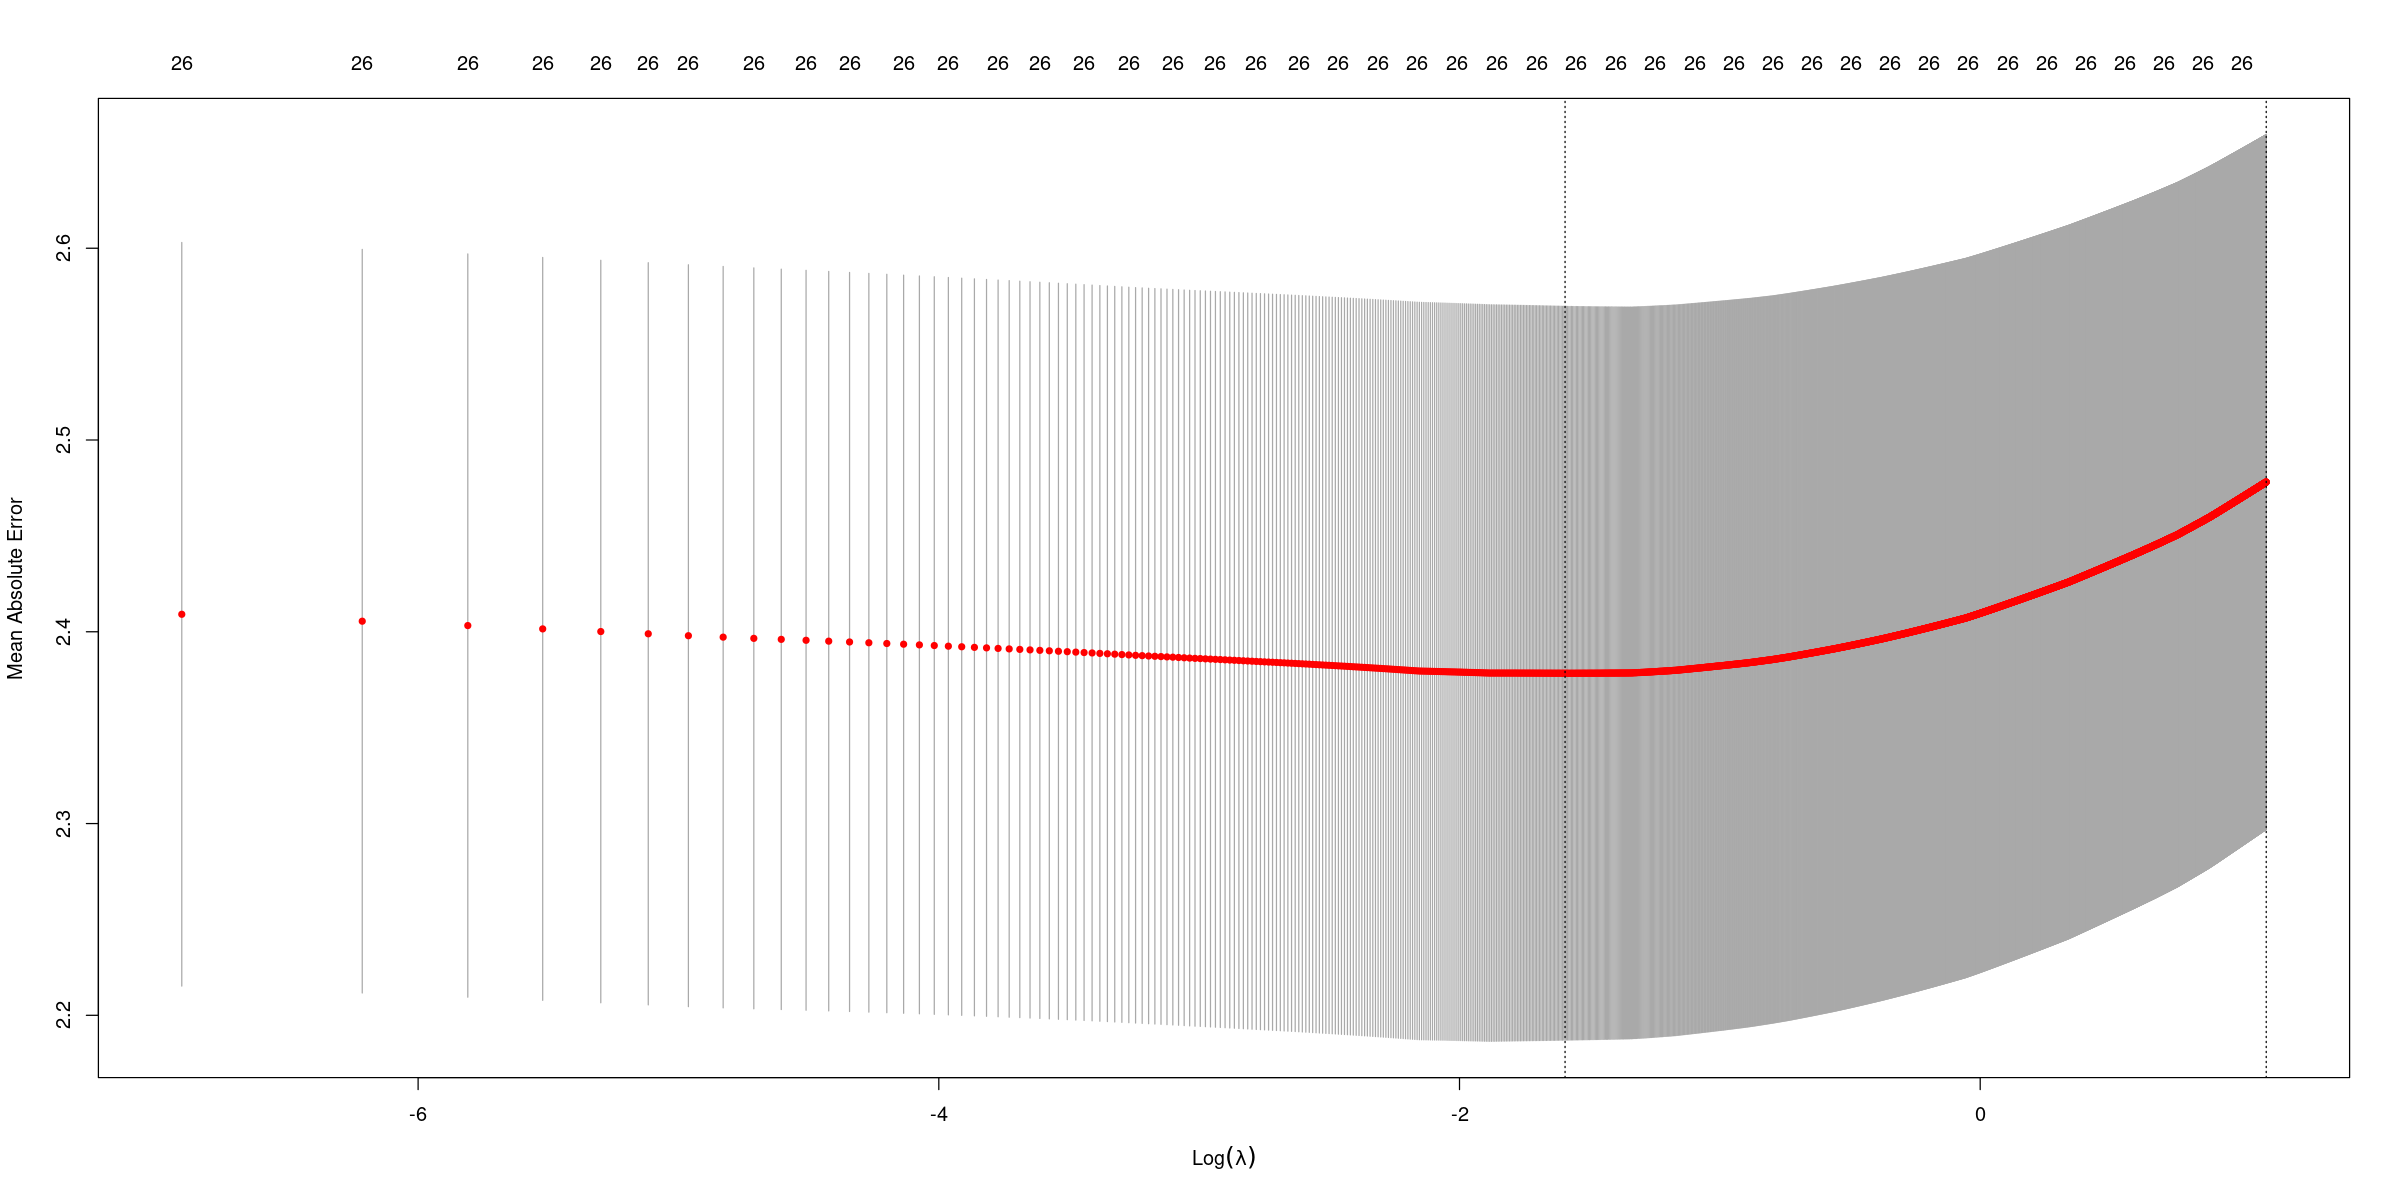

In [119]:
plot(poisson.reg.l2)

In [120]:
poisson.reg.l2$lambda.min
poisson.reg.l2$lambda.1se

[1] 0.203

[1] 3

In [121]:
best.poisson.l2 = cv.glmnet(x = x_train, y = y_train, family = 'poisson', alpha = 2, type.measure = 'mae')

poisson.l2.lamb.min = poisson.reg.l2$lambda.min
poisson.l2.lamb.1se = poisson.reg.l2$lambda.1se

coef.poisson.l2.min = coef(best.poisson.l2, s = poisson.l2.lamb.min, exact = TRUE, x = x_train, y = y_train)
coef.poisson.l2.1se = coef(best.poisson.l2, s = poisson.l2.lamb.1se, exact = TRUE, x = x_train, y = y_train)


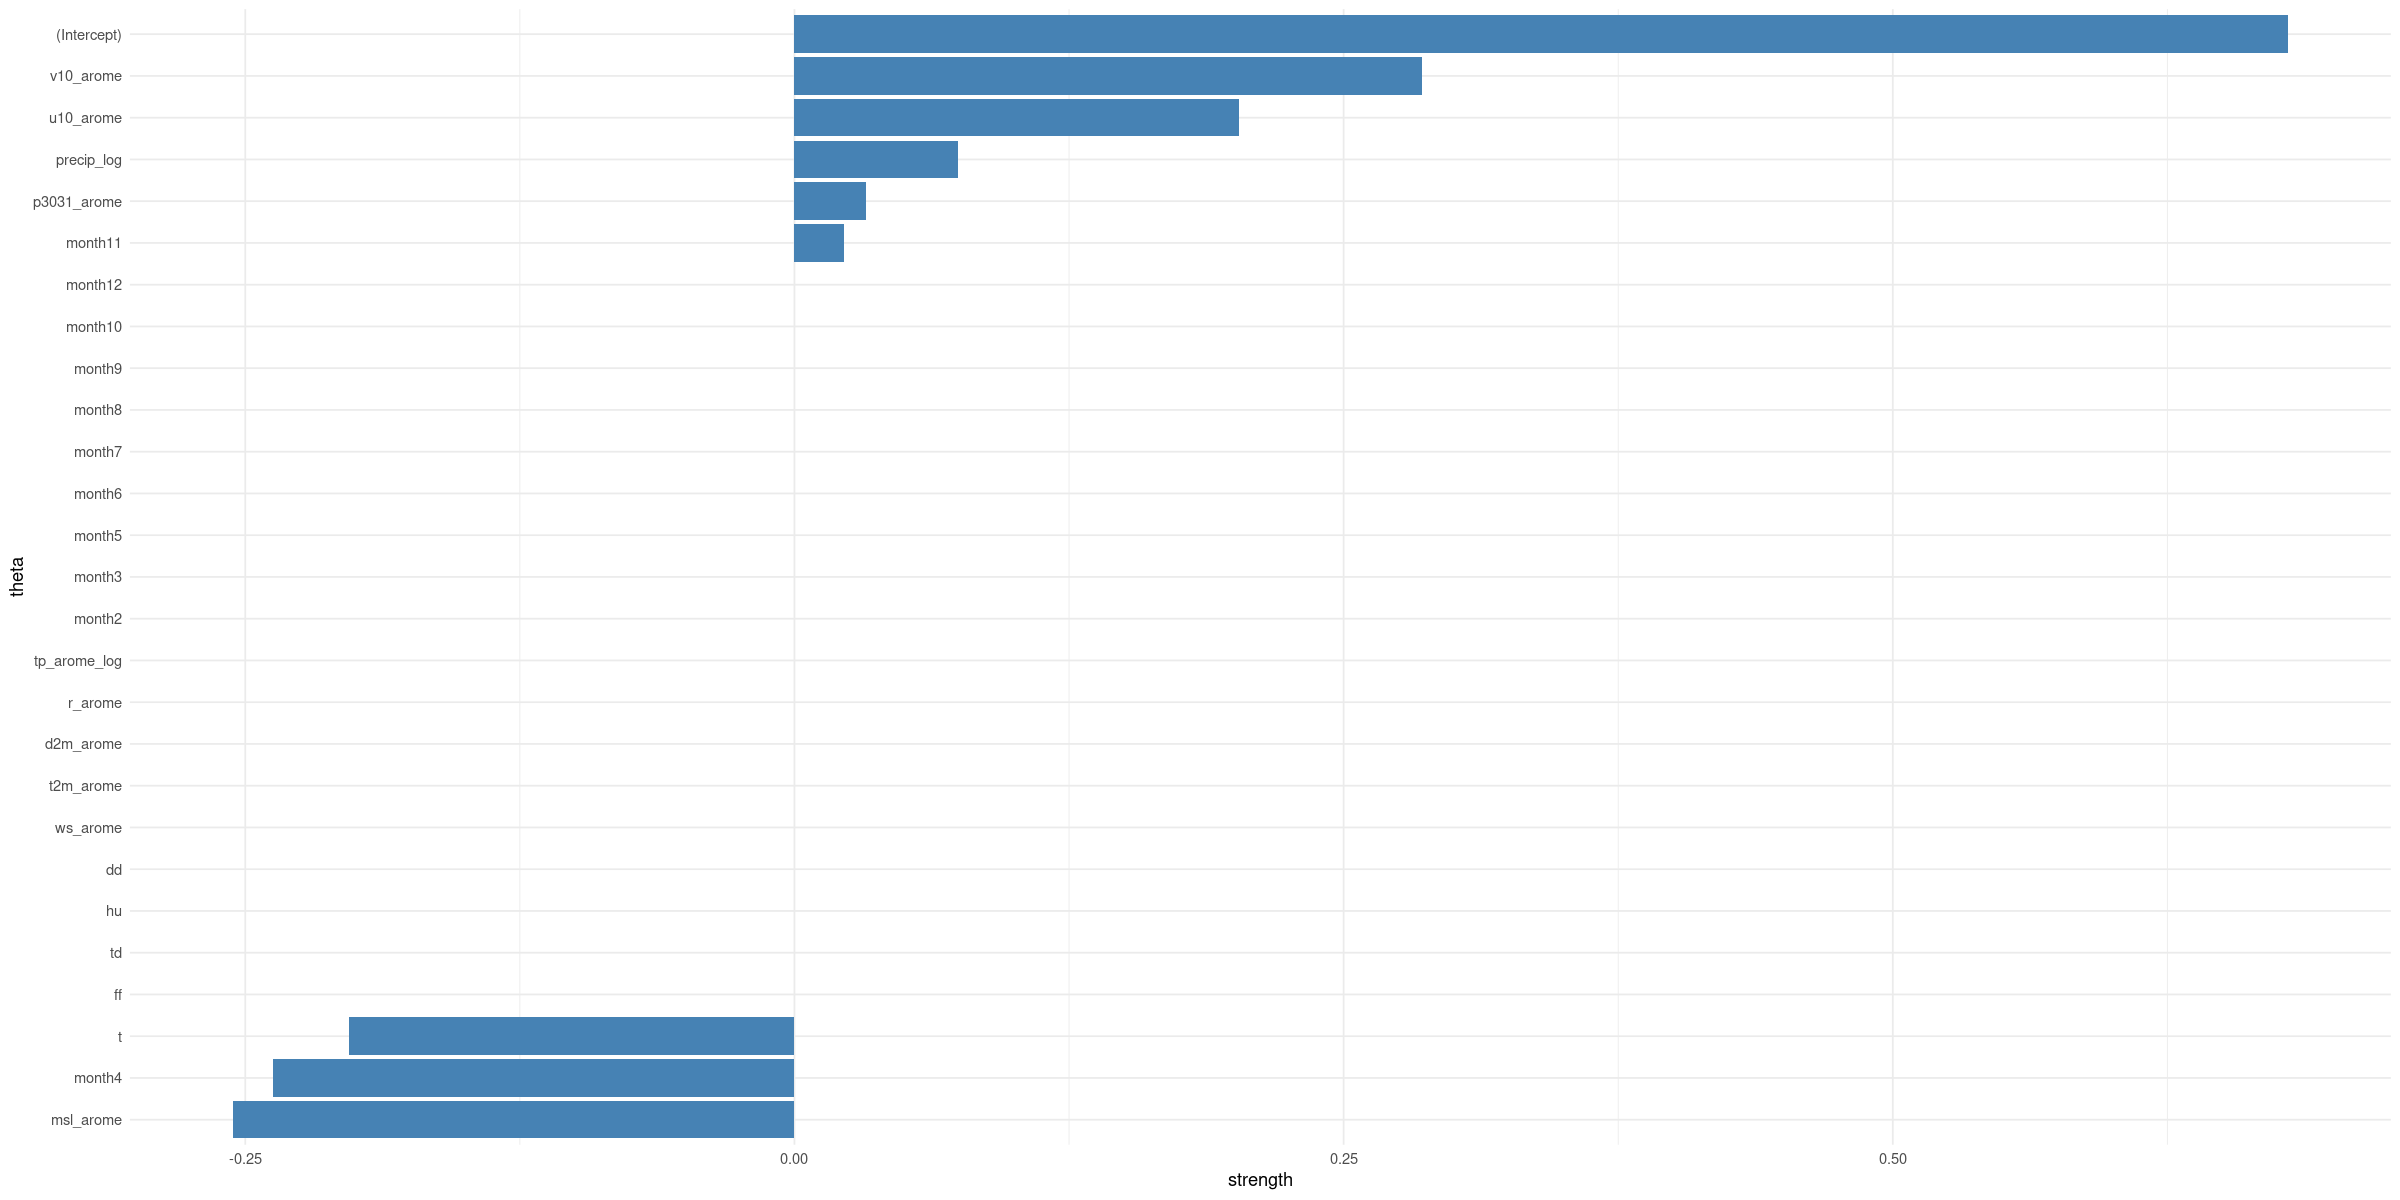

In [122]:
param_plot(coef.poisson.l2.min)

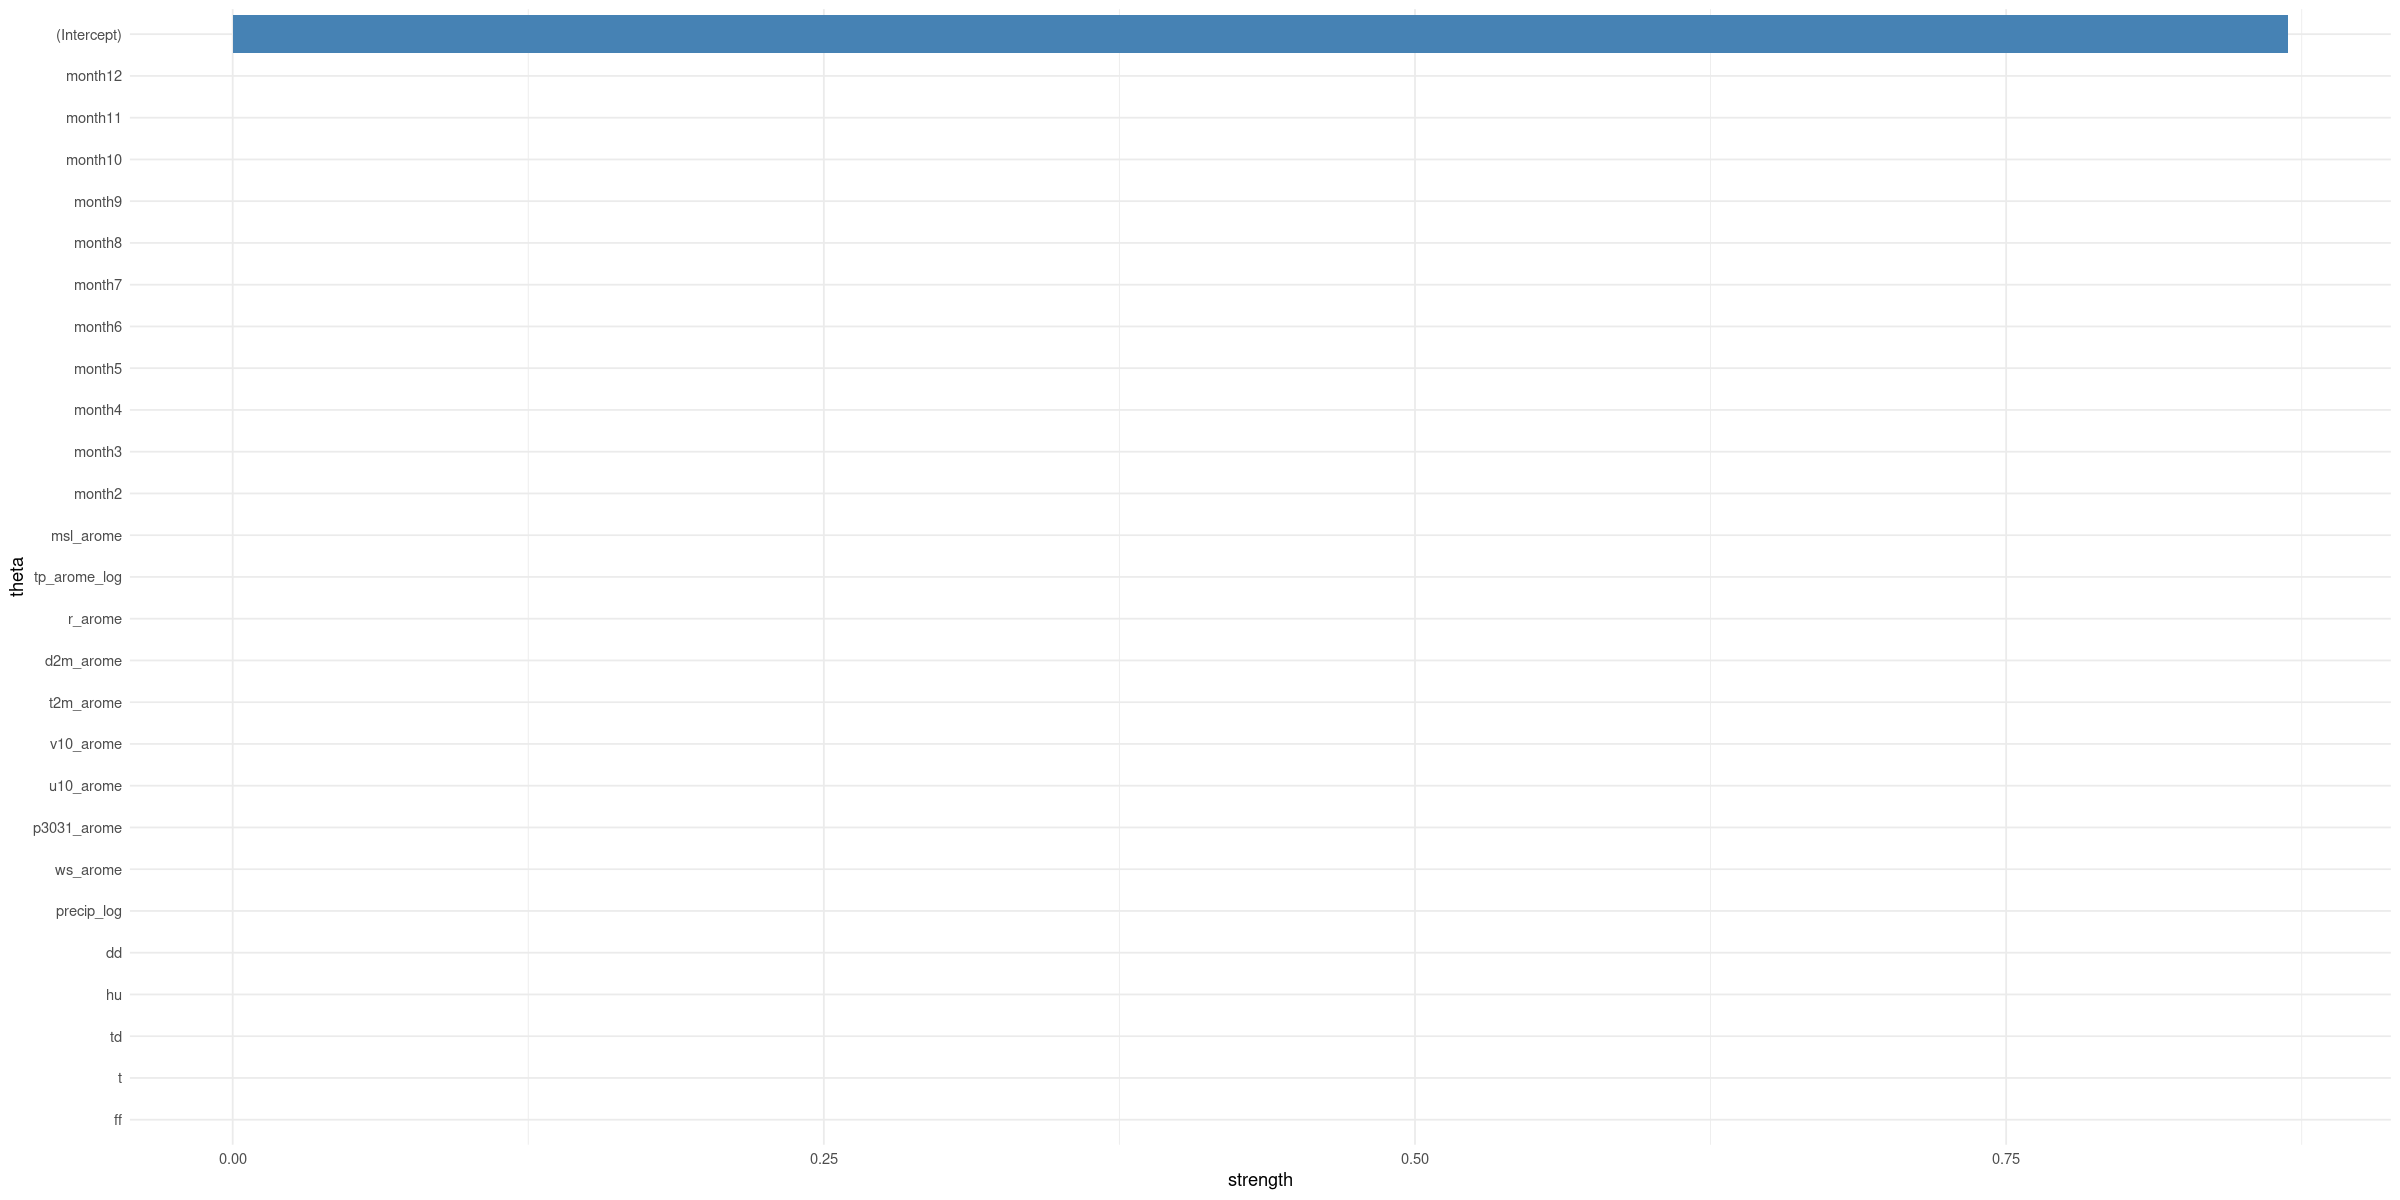

In [123]:
param_plot(coef.poisson.l2.1se)

In [124]:
y_predict_train_min = predict(best.poisson.l1, newx = x_train, type = 'response' , s = poisson.l1.lamb.min)
y_predict_test_min = predict(best.poisson.l1, newx = x_test, type = 'response' , s = poisson.l1.lamb.min)

y_predict_train_1se = predict(best.poisson.l1, newx = x_train, type = 'response' , s = poisson.l1.lamb.1se)
y_predict_test_1se = predict(best.poisson.l1, newx = x_test, type = 'response' , s = poisson.l1.lamb.1se)

In [125]:
print('TRAINING ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_train_min, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_min, y_train)))

print('TRAINING ERROR ')
print(paste('Mean Square Error : ', MSE(y_predict_train_1se, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_1se, y_train)))


print('TEST ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_test_min, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_min, y_test)))

print('TEST ERROR 1SE')
print(paste('Mean Square Error : ', MSE(y_predict_test_1se, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_1se, y_test)))

[1] "TRAINING ERROR MIN"
[1] "Mean Square Error :  15.2699319869971"
[1] "MAPE :  Inf"
[1] "TRAINING ERROR "
[1] "Mean Square Error :  18.3271621229876"
[1] "MAPE :  Inf"
[1] "TEST ERROR MIN"
[1] "Mean Square Error :  17.8994842849175"
[1] "MAPE :  Inf"
[1] "TEST ERROR 1SE"
[1] "Mean Square Error :  23.4191415653849"
[1] "MAPE :  Inf"


In [126]:
pred_class = to_class(y_predict_train_min, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_train_1se, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_test_min, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

pred_class = to_class(y_predict_test_1se, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       117       82      39
  low_rain         38      152     122
[1] "Prediction accuracy :  0.489090909090909"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       150      196     125
  low_rain          5       38      36
[1] "Prediction accuracy :  0.341818181818182"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        27       25      15
  low_rain          6       33      32
[1] "Prediction accuracy :  0.434782608695652"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        32       50      39
  low_rain          1        8       8
[1] "Prediction accuracy :  0.289855072463768"


### 3.4. Poisson regression with $l_1$ and $l_2$ regularisation

In [127]:
lambda_seq = seq(0, 3, by = 0.001)
poisson.reg.net = cv.glmnet(x = x_train, y = y_train, family = 'poisson', alpha = 0.5, lambda = lambda_seq, type.measure = 'mse')

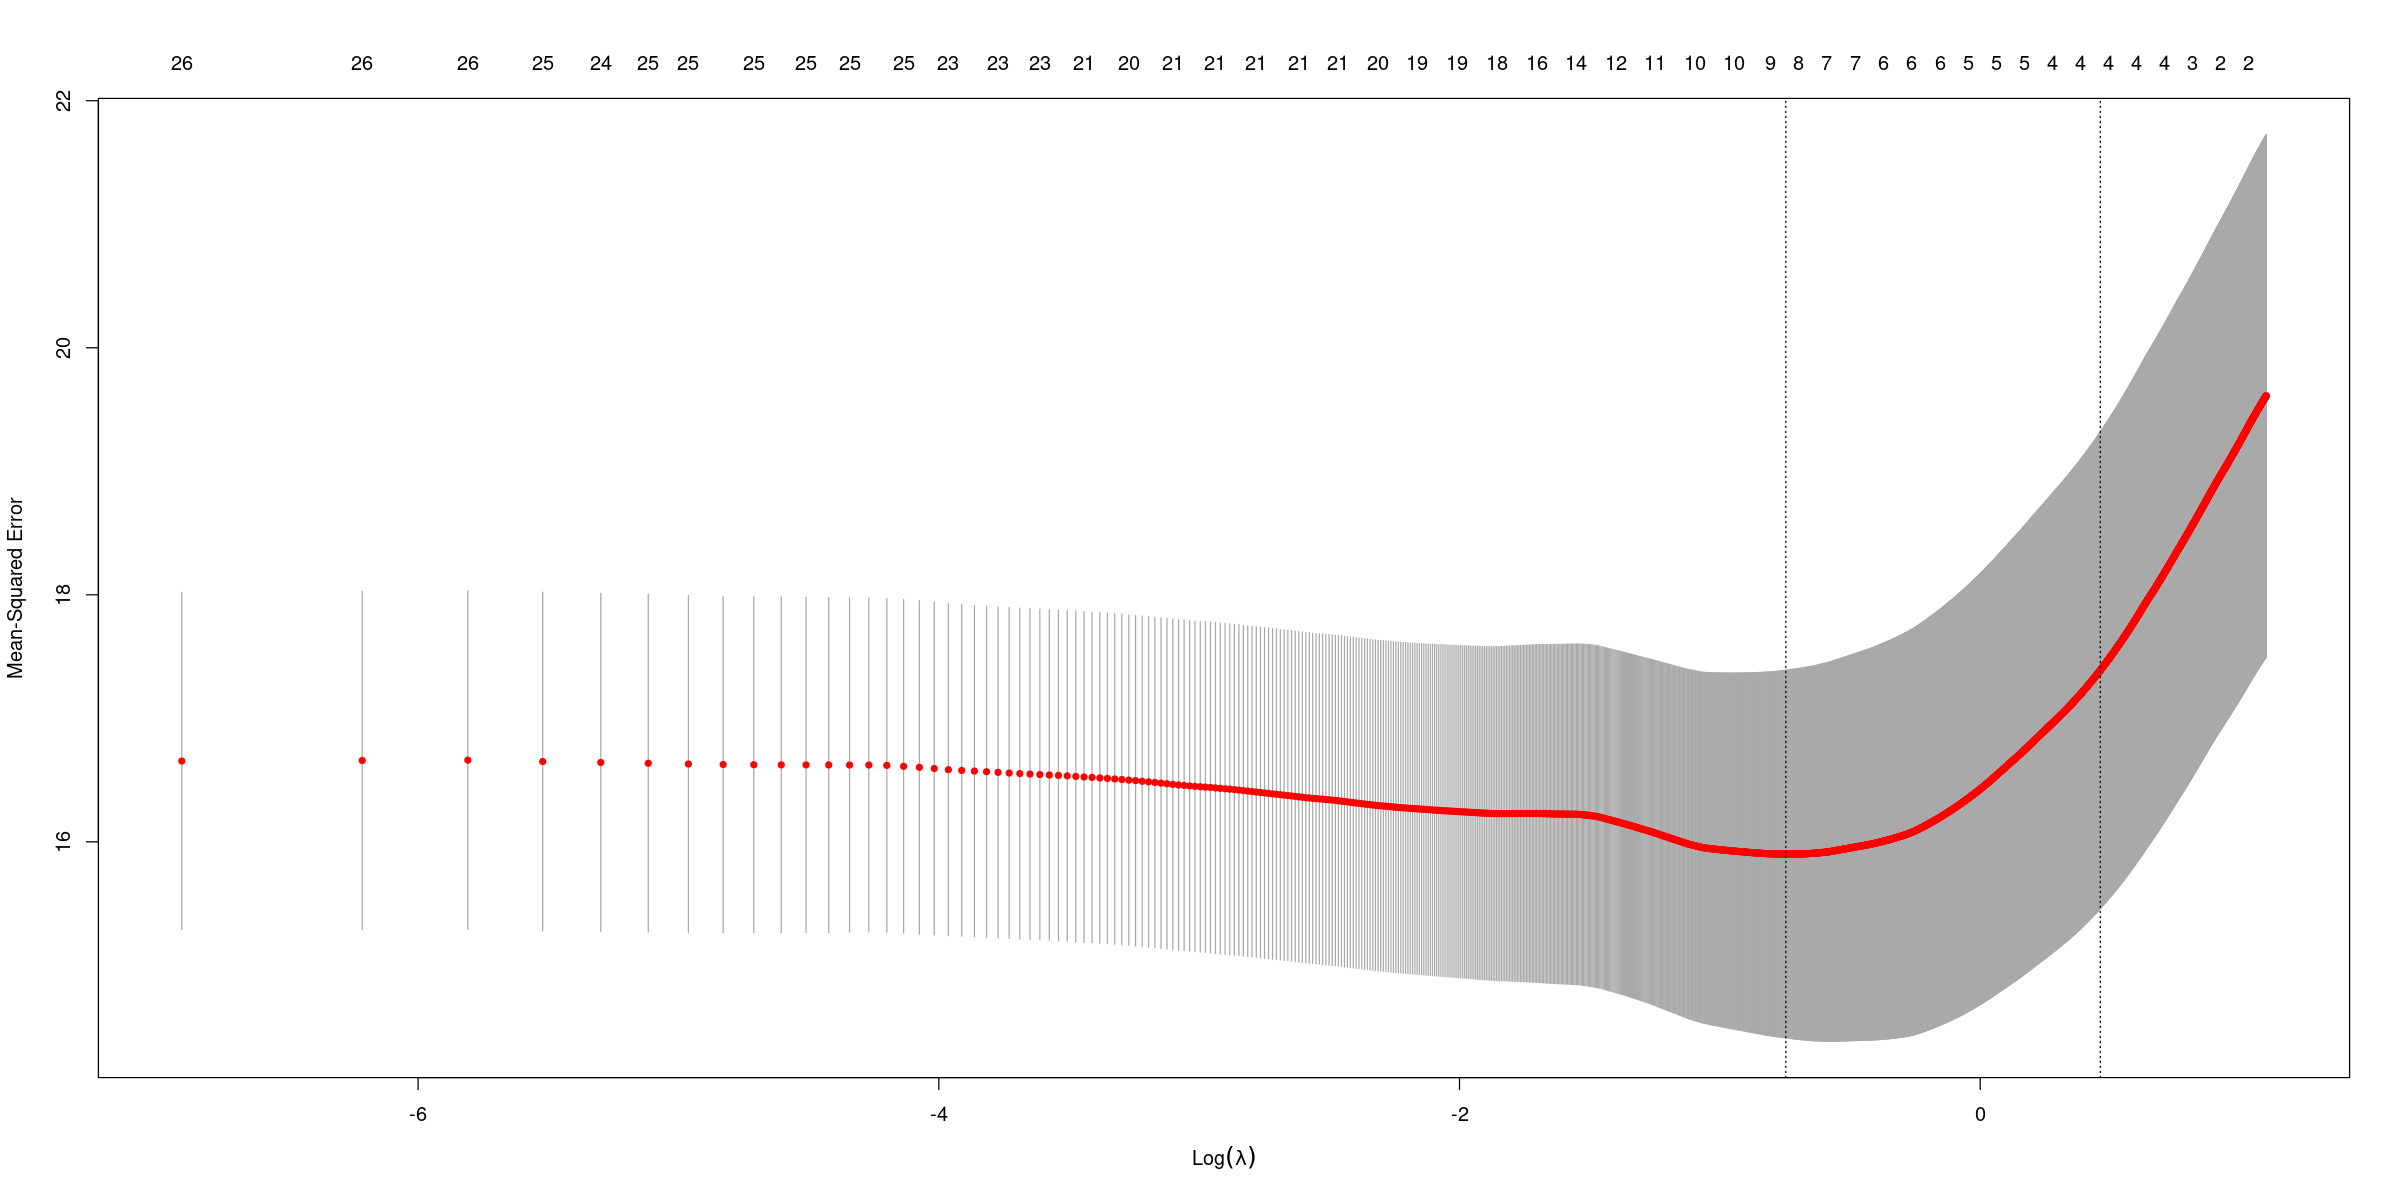

In [128]:
plot(poisson.reg.net)

In [129]:
poisson.reg.net$lambda.min
poisson.reg.net$lambda.1se

[1] 0.474

[1] 1.586

In [130]:
best.poisson.net = cv.glmnet(x = x_train, y = y_train, family = 'poisson', alpha = 0.5, type.measure = 'mse')

poisson.net.lamb.min = poisson.reg.net$lambda.min
poisson.net.lamb.1se = poisson.reg.net$lambda.1se

coef.poisson.net.min = coef(best.poisson.net, s = poisson.net.lamb.min, exact = TRUE, x = x_train, y = y_train)
coef.poisson.net.1se = coef(best.poisson.net, s = poisson.net.lamb.1se, exact = TRUE, x = x_train, y = y_train)


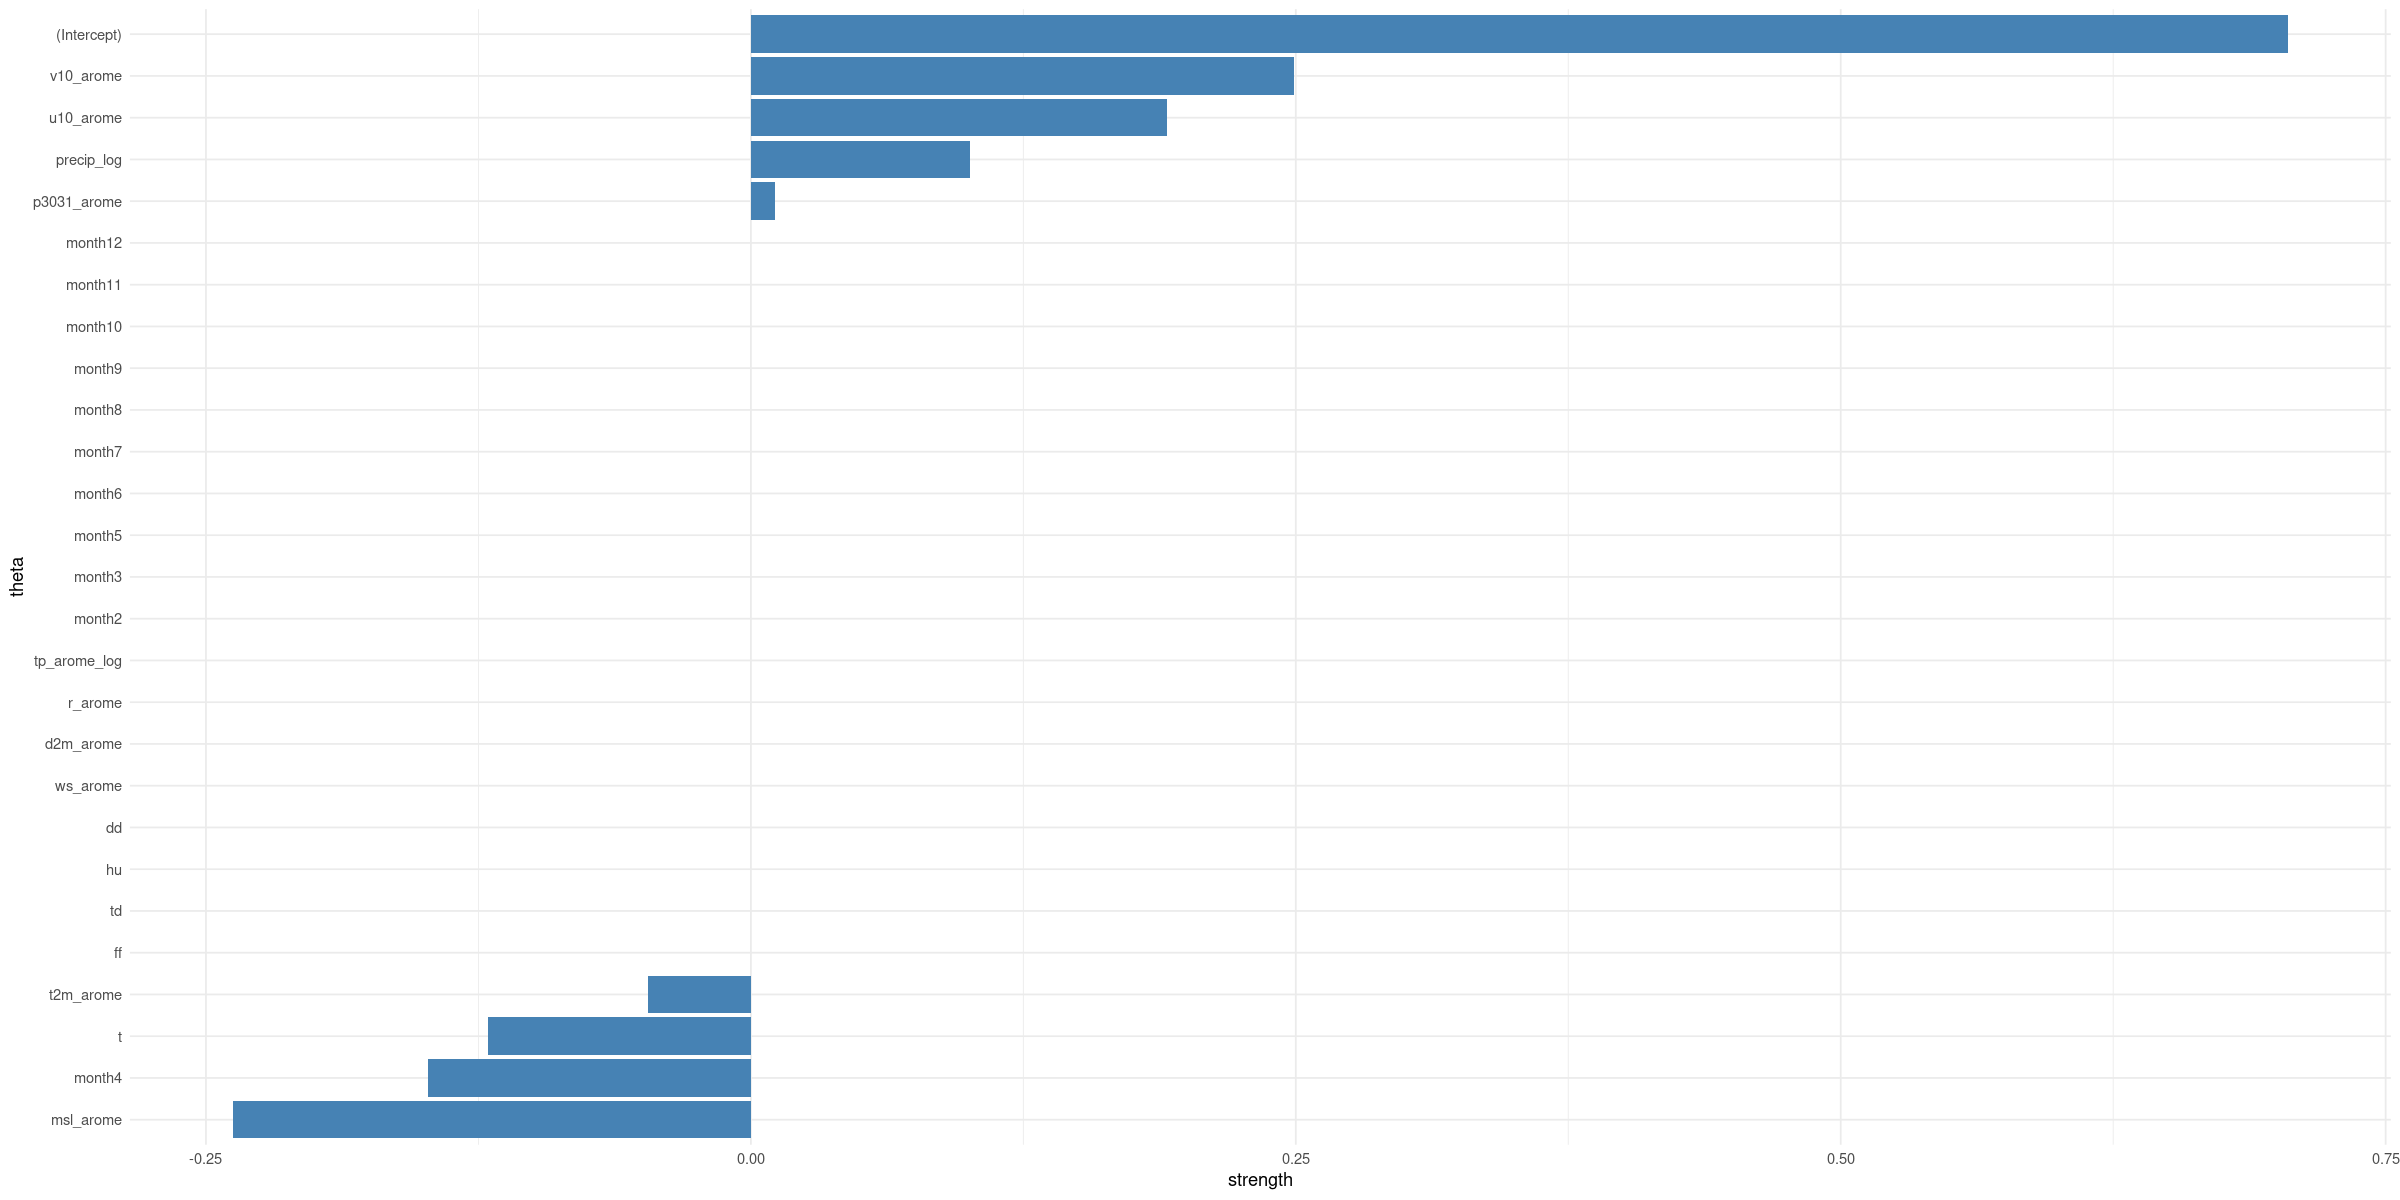

In [131]:
param_plot(coef.poisson.net.min)

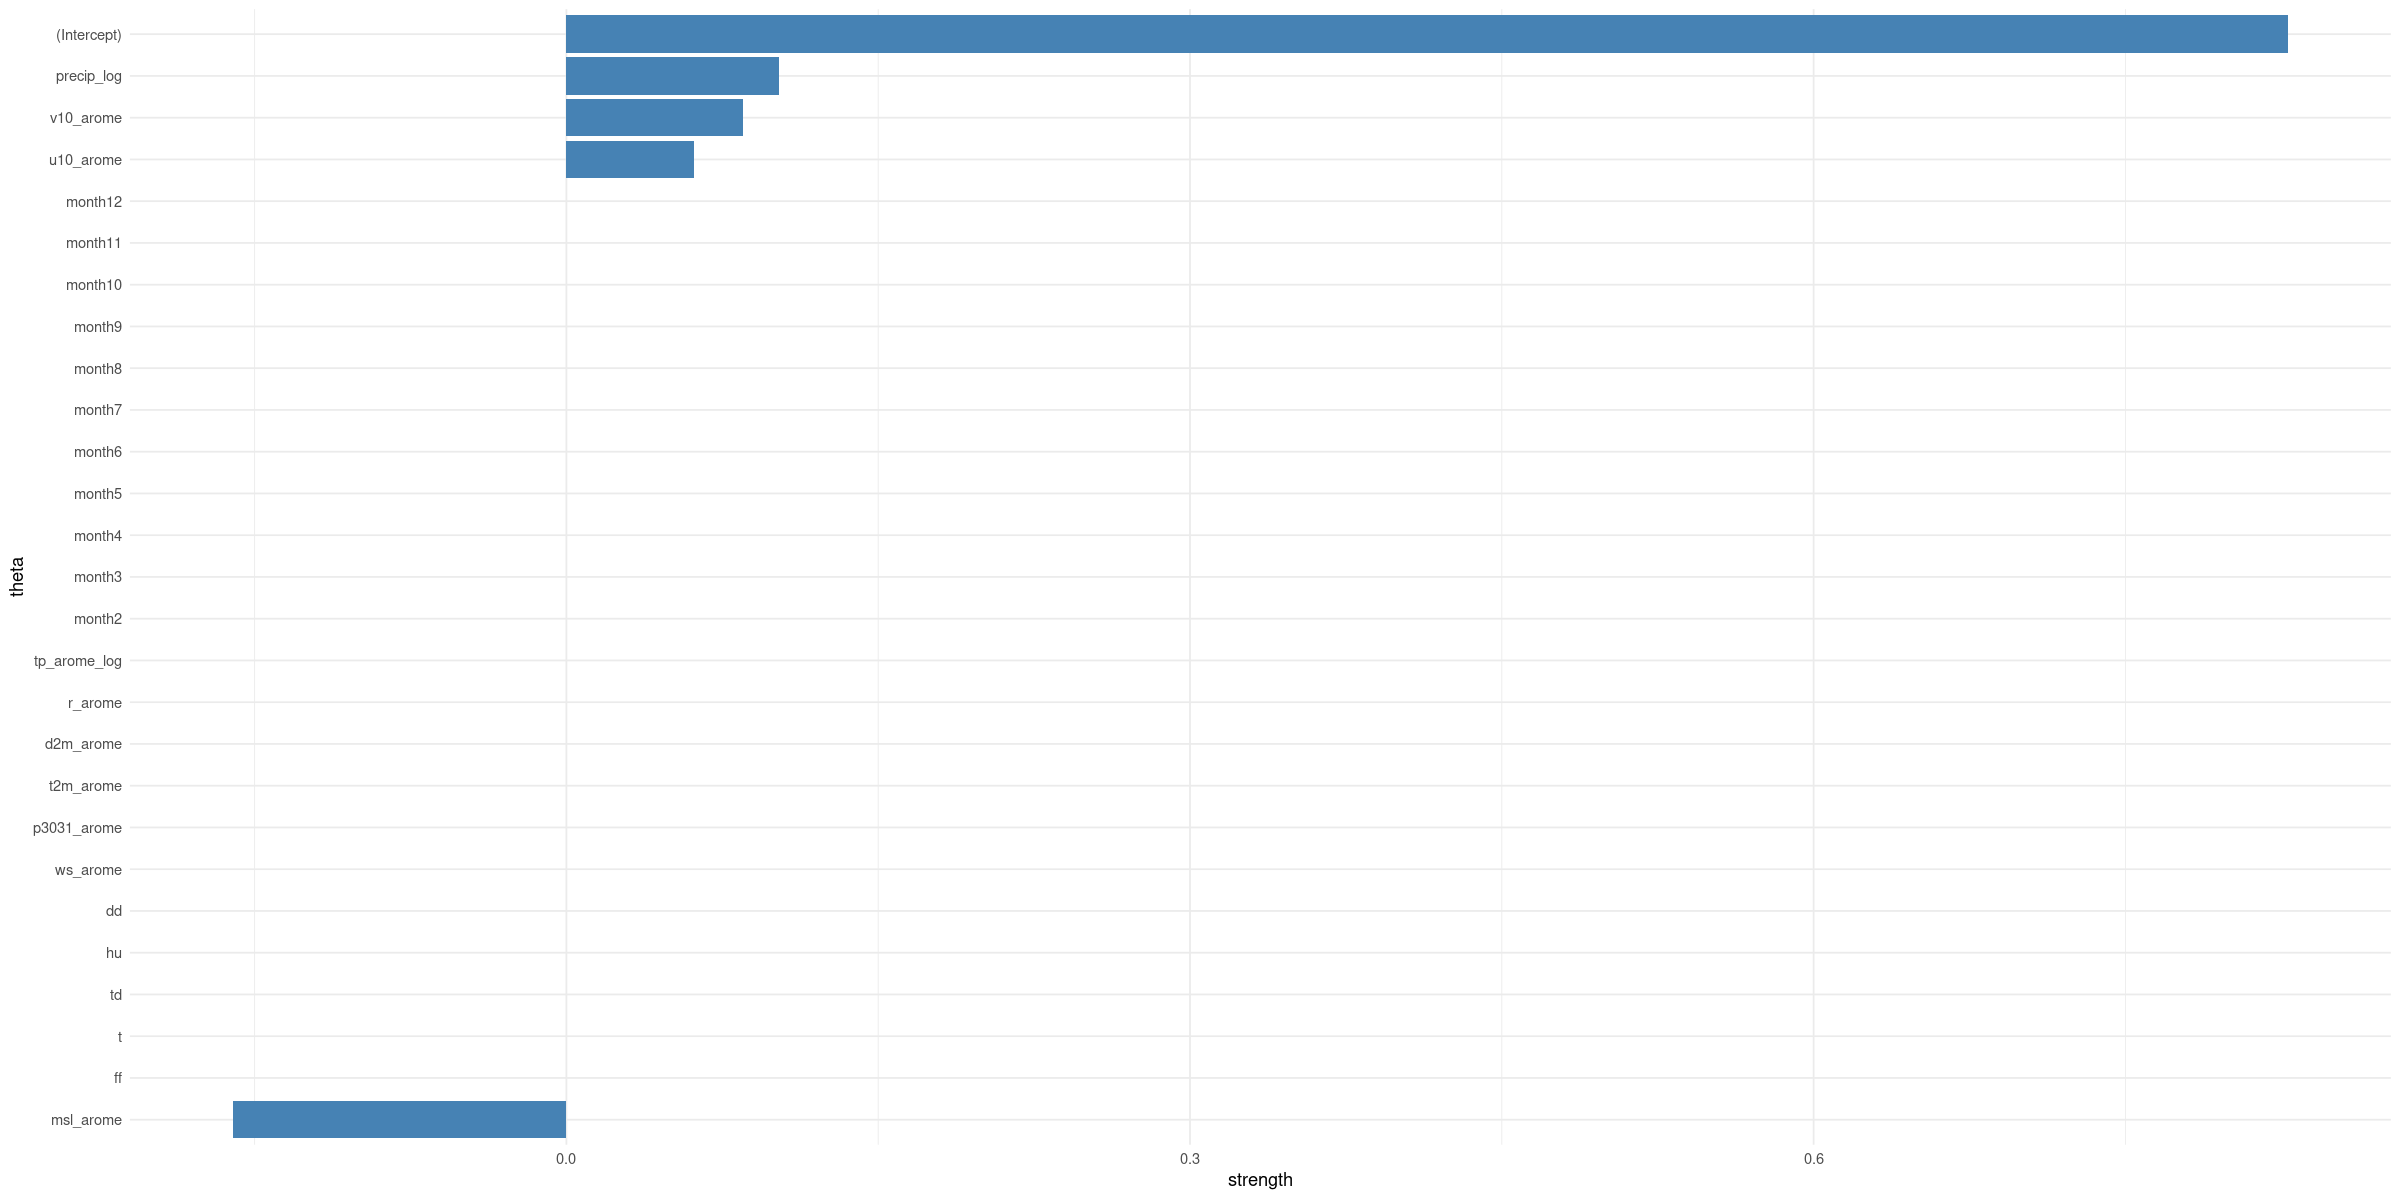

In [132]:
param_plot(coef.poisson.net.1se)

In [133]:
y_predict_train_min = predict(best.poisson.net, newx = x_train, type = 'response' , s = poisson.net.lamb.min)
y_predict_test_min = predict(best.poisson.net, newx = x_test, type = 'response' , s = poisson.net.lamb.min)

y_predict_train_1se = predict(best.poisson.net, newx = x_train, type = 'response' , s = poisson.net.lamb.1se)
y_predict_test_1se = predict(best.poisson.net, newx = x_test, type = 'response' , s = poisson.net.lamb.1se)

In [134]:
print('TRAINING ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_train_min, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_min, y_train)))

print('TRAINING ERROR ')
print(paste('Mean Square Error : ', MSE(y_predict_train_1se, y_train)))
print(paste('MAPE : ', MAPE(y_predict_train_1se, y_train)))


print('TEST ERROR MIN')
print(paste('Mean Square Error : ', MSE(y_predict_test_min, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_min, y_test)))

print('TEST ERROR 1SE')
print(paste('Mean Square Error : ', MSE(y_predict_test_1se, y_test)))
print(paste('MAPE : ', MAPE(y_predict_test_1se, y_test)))

[1] "TRAINING ERROR MIN"
[1] "Mean Square Error :  15.2662098908368"
[1] "MAPE :  Inf"
[1] "TRAINING ERROR "
[1] "Mean Square Error :  17.1258910511415"
[1] "MAPE :  Inf"
[1] "TEST ERROR MIN"
[1] "Mean Square Error :  18.0446484755634"
[1] "MAPE :  Inf"
[1] "TEST ERROR 1SE"
[1] "Mean Square Error :  21.6322881381257"
[1] "MAPE :  Inf"


In [135]:
pred_class = to_class(y_predict_train_min, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_train_1se, eps = 0.01)
confusion_matrix(pred_class, y_train_class)

pred_class = to_class(y_predict_test_min, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

pred_class = to_class(y_predict_test_1se, eps = 0.01)
confusion_matrix(pred_class, y_test_class)

[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       118       84      40
  low_rain         37      150     121
[1] "Prediction accuracy :  0.487272727272727"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain       137      131      64
  low_rain         18      103      97
[1] "Prediction accuracy :  0.436363636363636"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        27       25      15
  low_rain          6       33      32
[1] "Prediction accuracy :  0.434782608695652"
[1] "Confusion matrix"
           true_class
pred_class  high_rain low_rain no_rain
  high_rain        31       32      21
  low_rain          2       26      26
[1] "Prediction accuracy :  0.41304347826087"
